In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.integration import LightGBMPruningCallback
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm
# Suppress specific Optuna warnings about step reporting
warnings.filterwarnings("ignore", message="The reported value is ignored because this `step`")

# Set Optuna logging level to WARNING to suppress detailed logs
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_theme()

path_data = '../labo3/data/'
df_ventas = pd.read_csv(path_data+'sell-in.txt', delimiter='\t',  decimal='.') 
df_detail = pd.read_csv(path_data+'tb_productos.txt', delimiter='\t')  
df_product_to_predict = pd.read_csv(path_data+'productos_a_predecir.txt', delimiter='\t') 
df_stocks = pd.read_csv(path_data+'tb_stocks.txt', delimiter='\t')  

In [2]:
def add_time_features(df):
    df = df.copy()
    df['month'] = pd.to_datetime(df['periodo']).dt.month
    df['year'] = pd.to_datetime(df['periodo']).dt.year
    df['day_of_week'] = pd.to_datetime(df['periodo']).dt.dayofweek
    df['day_of_month'] = pd.to_datetime(df['periodo']).dt.day
    df['week_of_year'] = pd.to_datetime(df['periodo']).dt.isocalendar().week.astype(int)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df

def create_lag_features(df, num_lags, column_name):
    df = df.copy()
    for i in range(1, num_lags + 1):
        df[f'{column_name}_lag{i}'] = df[column_name].shift(i)
    return df

def create_rolling_features(df, windows, column_name):
    df = df.copy()
    for window in windows:
        df[f'{column_name}_roll_mean_{window}'] = df[column_name].rolling(window=window).mean()
        df[f'{column_name}_roll_std_{window}'] = df[column_name].rolling(window=window).std()
    return df

def preprocess_data(df, is_train=True):
    df = add_time_features(df)
    df = create_lag_features(df, 12, 'tn')
    df = create_rolling_features(df, [3, 6, 12], 'tn')
    
    if is_train:   
        df['tn_diff'] = df['tn'].diff().fillna(0)
        features = [col for col in df.columns if col not in ['periodo', 'tn', 'tn_diff', 'cat1', 'cat2', 'cat3', 'brand']]
        X = df[features]
        y = df['tn_diff']
        return X, y
    else:
        df['tn_diff'] = df['tn'].diff().fillna(0)
        features = [col for col in df.columns if col not in ['periodo', 'tn', 'tn_diff', 'cat1', 'cat2', 'cat3', 'brand']]
        X = df[features]
        return X

def train_lightgbm_time_series_cv(X, y, optimize_hyper=False, param_dict=None, n_trials=50):
    if len(X) < 10:
        # Use single month validation when data is too small
        print("Using single month validation due to insufficient data for multiple splits.")
        n_splits = 1
    else:
        # Ensure there are enough samples for the number of splits
        n_splits = max(2, min(5, len(X) // 5))

    if n_splits > 1:
        tscv = TimeSeriesSplit(n_splits=n_splits)

        def objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'mae',
                'num_leaves': trial.suggest_int('num_leaves', 20, 40),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                'verbose': -1
            }

            cv_mae = []
            for train_index, valid_index in tscv.split(X):
                X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
                y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

                train_data = lgb.Dataset(X_train, label=y_train)
                valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

                pruning_callback = LightGBMPruningCallback(trial, 'l1', valid_name='valid_0')

                gbm = lgb.train(
                    params,
                    train_data,
                    num_boost_round=100,
                    valid_sets=[valid_data],     
                    callbacks=[pruning_callback]
                )
                cv_mae.append(gbm.best_score['valid_0']['l1'])

            return sum(cv_mae) / len(cv_mae) if cv_mae else float('inf')

        if optimize_hyper:
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=n_trials)
            params = study.best_params
            params['objective'] = 'regression'
            params['metric'] = 'mae'
            params['verbose'] = -1
            # Print the best trial
            print("Best trial:")
            trial = study.best_trial
            print(f"  Value: {trial.value}")
            print("  Params: ")
            for key, value in trial.params.items():
                print(f"    {key}: {value}")
        else:
            if param_dict is None:
                raise ValueError("Parameter dictionary must be provided if not optimizing hyperparameters")
            params = param_dict

        train_data = lgb.Dataset(X, label=y)
        final_model = lgb.train(
            params,
            train_data,
            num_boost_round=100
        )

        if optimize_hyper:
            return final_model, params
        else:
            return final_model
    else:
        # Fallback to using the last month for validation
        if len(X) < 2:
            raise ValueError("Not enough data for single month validation.")

        X_train, X_valid = X.iloc[:-1], X.iloc[-1:]
        y_train, y_valid = y.iloc[:-1], y.iloc[-1:]

        if optimize_hyper:
            def objective(trial):
                params = {
                    'objective': 'regression',
                    'metric': 'mae',
                    'num_leaves': trial.suggest_int('num_leaves', 20, 40),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                    'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
                    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
                    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                    'verbose': -1
                }

                train_data = lgb.Dataset(X_train, label=y_train)
                valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

                gbm = lgb.train(
                    params,
                    train_data,
                    num_boost_round=100,
                    valid_sets=[valid_data]
                )
                return gbm.best_score['valid_0']['l1']

            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=n_trials)
            params = study.best_params
            params['objective'] = 'regression'
            params['metric'] = 'mae'
            params['verbose'] = -1
            # Print the best trial
            print("Best trial:")
            trial = study.best_trial
            print(f"  Value: {trial.value}")
            print("  Params: ")
            for key, value in trial.params.items():
                print(f"    {key}: {value}")
        else:
            if param_dict is None:
                raise ValueError("Parameter dictionary must be provided if not optimizing hyperparameters")
            params = param_dict

        train_data = lgb.Dataset(X_train, label=y_train)
        final_model = lgb.train(
            params,
            train_data,
            num_boost_round=100
        )

        if optimize_hyper:
            return final_model, params
        else:
            return final_model

def predict_with_model(model, X, last_tn):
    if X.empty:
        raise ValueError("The test set is empty. Please check the preprocessing steps.")
    
    y_pred_diff = model.predict(X)
    y_pred_tn = last_tn + y_pred_diff

    return y_pred_tn

def prepare_next_month_prediction(last_train, model, last_tn, next_period):
    # Create a DataFrame for the next period with lag and rolling features
    next_row = last_train.tail(1).copy()
    next_row['periodo'] = next_period
    next_row = add_time_features(next_row)
    next_row = create_lag_features(next_row, 12, 'tn')
    next_row = create_rolling_features(next_row, [3, 6, 12], 'tn')

    # Remove NaN values (created due to lagging)
    next_row = next_row.fillna(0)
    
    features = [col for col in next_row.columns if col not in ['periodo', 'tn', 'tn_diff', 'cat1', 'cat2', 'cat3', 'brand']]
    X_next = next_row[features]

    y_pred_tn = predict_with_model(model, X_next, last_tn)

    next_row['tn'] = y_pred_tn[0]

    return next_row, y_pred_tn[0]

def predict_product(final_df, training_months, cutoff_date,n_trials):
    # Prepare training data
    train = final_df[final_df['periodo'] < cutoff_date]
    train = train.tail(training_months)

    X_train, y_train = preprocess_data(train)
    model, params = train_lightgbm_time_series_cv(X_train, y_train, optimize_hyper=True, n_trials=n_trials)

    # Predict for the first month
    test_1 = final_df[final_df['periodo'] == cutoff_date]
    X_test_1 = preprocess_data(test_1, is_train=False)
    last_tn = train['tn'].tail(1).iloc[0]
    y_pred_tn_1 = predict_with_model(model, X_test_1, last_tn)
    print("Predicted tn for the first month:", y_pred_tn_1[0])

    # Update the dataset with the first prediction
    train = pd.concat([train, test_1], ignore_index=True)
    train.loc[train.index[-1], 'tn'] = y_pred_tn_1[0]

    # Prepare for the second month's prediction
    next_cutoff_date = (pd.to_datetime(cutoff_date) + pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    next_row, y_pred_tn_2 = prepare_next_month_prediction(train, model, y_pred_tn_1[0], next_cutoff_date)
    return y_pred_tn_2

## Preprocessing

In [3]:
df_ventas['periodo'] = pd.to_datetime(df_ventas['periodo'], format='%Y%m')
df_ventas.sort_values(by='periodo', inplace=True)

In [4]:
print(df_ventas.shape)
df_ventas.drop_duplicates(inplace=True)
print(df_ventas.shape)
print(df_detail.shape)
df_detail.drop_duplicates(inplace=True)
print(df_detail.shape)

(2945818, 7)
(2945818, 7)
(1262, 6)
(1253, 6)


In [5]:
df_detail['product_id'].value_counts()

product_id
20230    2
20623    2
20574    1
20451    1
20133    1
        ..
20767    1
20397    1
20529    1
21177    1
20890    1
Name: count, Length: 1251, dtype: int64

### Hay product_id duplicados porque tienen distinto sku_size, normalizar esto antes de mergear!

In [6]:
df_detail[df_detail['product_id'] == 20230]

,cat1,cat2,cat3,brand,sku_size,product_id
917,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,350,20230
983,PC,CABELLO,SHAMPOO,SHAMPOO3,350,20230


In [7]:
df_detail.drop(index=917, inplace=True)

In [8]:
df_detail[df_detail['product_id'] == 20623]

,cat1,cat2,cat3,brand,sku_size,product_id
915,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,350,20623
981,PC,CABELLO,SHAMPOO,SHAMPOO3,350,20623


In [9]:
df_detail.drop(index=981, inplace=True)

## Merge dataframes

In [10]:
df = pd.merge(df_ventas, df_detail, how = 'left', on='product_id')
assert df.shape[0] - df_ventas.shape[0] == 0, 'hay duplicados'

## Normalize cat

In [11]:
columns_to_uppercase = ['cat1', 'cat2', 'cat3']
df[columns_to_uppercase] = df[columns_to_uppercase].apply(lambda x: x.astype(str).str.upper())

## Eda

In [12]:
df['tn'].mean()

0.4497863032984384

<Axes: title={'center': 'log tn'}, ylabel='Frequency'>

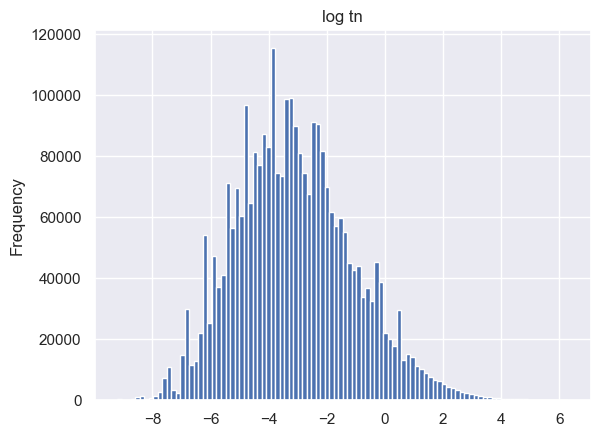

In [13]:
np.log(df['tn']).plot(kind='hist', bins=100, title='log tn')

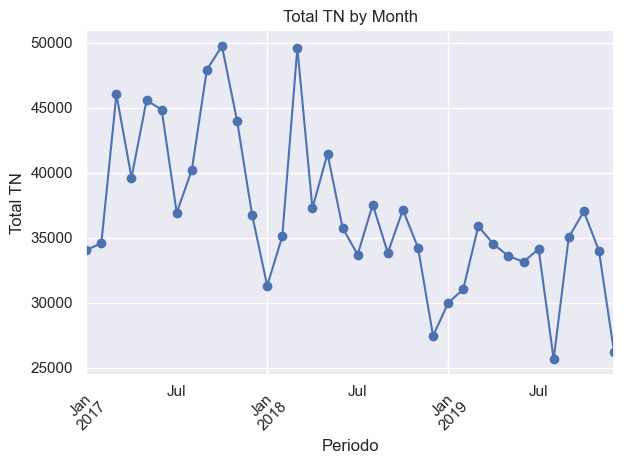

In [14]:
df.groupby('periodo')['tn'].sum().plot(kind='line', marker='o', linestyle='-')

# Enhancing the plot
plt.title('Total TN by Month')
plt.xlabel('Periodo')
plt.ylabel('Total TN')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability if necessary
plt.tight_layout()  # Adjust layout to make room for label rotation

# Show the plot
plt.show()

<Axes: title={'center': 'tn by cust_id'}, xlabel='customer_id'>

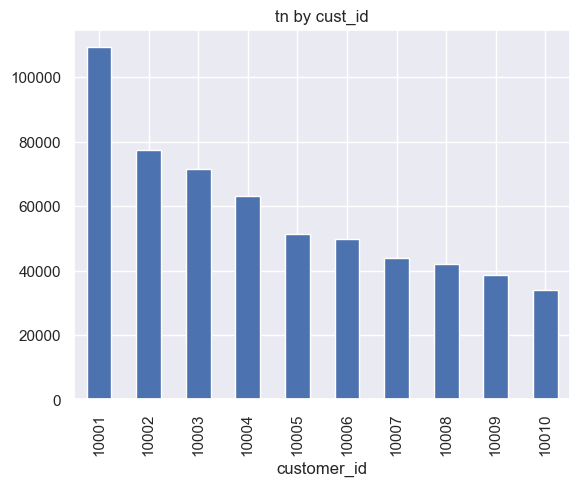

In [15]:
df.groupby('customer_id')['tn'].sum()[:10].plot(kind='bar', title='tn by cust_id')

# Get best_customer - best_selling product

In [16]:
# df.groupby('product_id')['tn'].sum()[:1]
# df_best_prod = df[df['product_id'] == 20001]
# df_best_prod.groupby(['customer_id'])['tn'].sum().sort_values(ascending=False)
# df_best = df_best_prod[df_best_prod['customer_id'] == 10004]
# df_best['tn'].plot()

# Feature engineering

In [17]:
# Parameters
training_months = 12
cutoff_date = '2019-12-01'
n_trials = 100

In [18]:
def get_prod(df, prod_num):
    cols = ['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados','cust_request_qty', 'cust_request_tn', 'tn']
    df = df[cols]
    single_prod = df[df['product_id'] == prod_num].groupby('periodo').sum().reset_index()
    return single_prod.drop(['customer_id','product_id'], axis=1)

In [ ]:
final_dict = {}

for prod in tqdm(df_product_to_predict['product_id'].to_list()):
    try:
        final_dict[prod] = predict_product(get_prod(df, prod), 
                                        training_months = training_months,
                                        cutoff_date = cutoff_date,
                                        n_trials = n_trials)
    except:
        final_dict[prod] = 0        

  0%|                                                                                | 1/780 [00:09<2:01:27,  9.35s/it]

Best trial:
  Value: 301.34454452991486
  Params: 
    num_leaves: 32
    learning_rate: 0.0626162377501664
    feature_fraction: 0.9015314714203134
    bagging_fraction: 0.7437416832399134
    bagging_freq: 9
    min_child_samples: 39
Predicted tn for the first month: 1389.92944113149


  0%|▏                                                                               | 2/780 [00:18<2:00:43,  9.31s/it]

Best trial:
  Value: 334.4654722213745
  Params: 
    num_leaves: 20
    learning_rate: 0.09783803312789627
    feature_fraction: 0.8476023565926751
    bagging_fraction: 0.6882077260404285
    bagging_freq: 3
    min_child_samples: 47
Predicted tn for the first month: 1458.087619110718


  0%|▎                                                                               | 3/780 [00:27<2:00:40,  9.32s/it]

Best trial:
  Value: 118.36411571502686
  Params: 
    num_leaves: 31
    learning_rate: 0.05552959870772644
    feature_fraction: 0.7786223839860048
    bagging_fraction: 0.6807421300325873
    bagging_freq: 5
    min_child_samples: 20
Predicted tn for the first month: 963.1660333732096


  1%|▍                                                                               | 4/780 [00:37<2:00:29,  9.32s/it]

Best trial:
  Value: 182.7405285835266
  Params: 
    num_leaves: 24
    learning_rate: 0.03254459193096741
    feature_fraction: 0.8936217138313709
    bagging_fraction: 0.6269794608857513
    bagging_freq: 4
    min_child_samples: 18
Predicted tn for the first month: 735.4735016885376


  1%|▌                                                                               | 5/780 [00:46<2:00:26,  9.32s/it]

Best trial:
  Value: 202.45373129844666
  Params: 
    num_leaves: 23
    learning_rate: 0.06558991697840238
    feature_fraction: 0.8440471749902089
    bagging_fraction: 0.6109652511197662
    bagging_freq: 8
    min_child_samples: 6
Predicted tn for the first month: 626.4348472243754


  1%|▌                                                                               | 6/780 [00:55<2:00:24,  9.33s/it]

Best trial:
  Value: 168.42823457717896
  Params: 
    num_leaves: 23
    learning_rate: 0.011316312761203392
    feature_fraction: 0.9724610108664248
    bagging_fraction: 0.6838871059833131
    bagging_freq: 1
    min_child_samples: 48
Predicted tn for the first month: 398.93544646504716


  1%|▋                                                                               | 7/780 [01:05<2:00:11,  9.33s/it]

Best trial:
  Value: 110.44204694032669
  Params: 
    num_leaves: 35
    learning_rate: 0.02172076710203531
    feature_fraction: 0.7033839307867211
    bagging_fraction: 0.7827969771949389
    bagging_freq: 1
    min_child_samples: 16
Predicted tn for the first month: 357.52830363802593


  1%|▊                                                                               | 8/780 [01:14<2:00:02,  9.33s/it]

Best trial:
  Value: 103.1317892074585
  Params: 
    num_leaves: 32
    learning_rate: 0.05205648599740742
    feature_fraction: 0.6827769921923329
    bagging_fraction: 0.609123474174208
    bagging_freq: 4
    min_child_samples: 17
Predicted tn for the first month: 394.01244215464277


  1%|▉                                                                               | 9/780 [01:23<2:00:00,  9.34s/it]

Best trial:
  Value: 108.20486590266228
  Params: 
    num_leaves: 21
    learning_rate: 0.01889501576485184
    feature_fraction: 0.8198991193157074
    bagging_fraction: 0.8067249196864066
    bagging_freq: 9
    min_child_samples: 13
Predicted tn for the first month: 724.9414190974236


  1%|█                                                                              | 10/780 [01:33<1:59:50,  9.34s/it]

Best trial:
  Value: 156.17371666431427
  Params: 
    num_leaves: 25
    learning_rate: 0.06315400072902218
    feature_fraction: 0.893089038511979
    bagging_fraction: 0.6647317982205048
    bagging_freq: 8
    min_child_samples: 28
Predicted tn for the first month: 486.46133844701126


  1%|█                                                                              | 11/780 [01:42<1:59:43,  9.34s/it]

Best trial:
  Value: 103.36598873138428
  Params: 
    num_leaves: 30
    learning_rate: 0.01538923076381036
    feature_fraction: 0.818102491229839
    bagging_fraction: 0.860779466816336
    bagging_freq: 6
    min_child_samples: 25
Predicted tn for the first month: 291.9066138220215


  2%|█▏                                                                             | 12/780 [01:52<1:59:41,  9.35s/it]

Best trial:
  Value: 93.06255054473877
  Params: 
    num_leaves: 39
    learning_rate: 0.015256561906874057
    feature_fraction: 0.7540458422023805
    bagging_fraction: 0.6122304075782681
    bagging_freq: 7
    min_child_samples: 21
Predicted tn for the first month: 359.7358927126058


  2%|█▎                                                                             | 13/780 [02:01<1:59:34,  9.35s/it]

Best trial:
  Value: 159.28475189208984
  Params: 
    num_leaves: 28
    learning_rate: 0.06626688044467015
    feature_fraction: 0.7099269238977586
    bagging_fraction: 0.7581746456155822
    bagging_freq: 7
    min_child_samples: 7
Predicted tn for the first month: 336.4076604003906


  2%|█▍                                                                             | 14/780 [02:10<1:59:24,  9.35s/it]

Best trial:
  Value: 121.23657244443893
  Params: 
    num_leaves: 28
    learning_rate: 0.022924486738830848
    feature_fraction: 0.7048461816460481
    bagging_fraction: 0.9037089630553932
    bagging_freq: 5
    min_child_samples: 14
Predicted tn for the first month: 420.29806051582335


  2%|█▌                                                                             | 15/780 [02:20<1:59:17,  9.36s/it]

Best trial:
  Value: 99.38509553670883
  Params: 
    num_leaves: 21
    learning_rate: 0.07001257435524086
    feature_fraction: 0.787498666947712
    bagging_fraction: 0.9500668537929384
    bagging_freq: 1
    min_child_samples: 43
Predicted tn for the first month: 311.64220191460925


  2%|█▌                                                                             | 16/780 [02:29<1:59:03,  9.35s/it]

Best trial:
  Value: 63.4366686521098
  Params: 
    num_leaves: 34
    learning_rate: 0.020408019288334862
    feature_fraction: 0.9472216327225909
    bagging_fraction: 0.968603718248672
    bagging_freq: 7
    min_child_samples: 11
Predicted tn for the first month: 309.29671411812427


  2%|█▋                                                                             | 17/780 [02:38<1:58:52,  9.35s/it]

Best trial:
  Value: 75.65756964683533
  Params: 
    num_leaves: 27
    learning_rate: 0.03036295374365741
    feature_fraction: 0.8501145732635633
    bagging_fraction: 0.9867322173678804
    bagging_freq: 5
    min_child_samples: 23
Predicted tn for the first month: 213.29349289016724


  2%|█▊                                                                             | 18/780 [02:48<1:58:57,  9.37s/it]

Best trial:
  Value: 91.95441508293152
  Params: 
    num_leaves: 21
    learning_rate: 0.016990712746495346
    feature_fraction: 0.9583755542662755
    bagging_fraction: 0.6966944529086017
    bagging_freq: 3
    min_child_samples: 42
Predicted tn for the first month: 248.24233243967691


  2%|█▉                                                                             | 19/780 [02:57<1:58:48,  9.37s/it]

Best trial:
  Value: 69.92011100053787
  Params: 
    num_leaves: 32
    learning_rate: 0.06582878174899347
    feature_fraction: 0.8769788628372828
    bagging_fraction: 0.815702610802297
    bagging_freq: 9
    min_child_samples: 15
Predicted tn for the first month: 369.4439843068695


  3%|██                                                                             | 20/780 [03:06<1:58:44,  9.37s/it]

Best trial:
  Value: 76.36135768890381
  Params: 
    num_leaves: 39
    learning_rate: 0.0174363438093186
    feature_fraction: 0.9059443074548703
    bagging_fraction: 0.8211860846089347
    bagging_freq: 1
    min_child_samples: 41
Predicted tn for the first month: 331.60110163518266


  3%|██▏                                                                            | 21/780 [03:16<1:58:40,  9.38s/it]

Best trial:
  Value: 82.47221755981445
  Params: 
    num_leaves: 35
    learning_rate: 0.015664958553557515
    feature_fraction: 0.918033410712494
    bagging_fraction: 0.9577499872395954
    bagging_freq: 2
    min_child_samples: 9
Predicted tn for the first month: 288.80496663289387


  3%|██▏                                                                            | 22/780 [03:25<1:58:32,  9.38s/it]

Best trial:
  Value: 126.45358628034592
  Params: 
    num_leaves: 39
    learning_rate: 0.013319023465045668
    feature_fraction: 0.9671655966095001
    bagging_fraction: 0.8877034650940505
    bagging_freq: 5
    min_child_samples: 37
Predicted tn for the first month: 353.55462640159607


  3%|██▎                                                                            | 23/780 [03:35<1:58:14,  9.37s/it]

Best trial:
  Value: 41.75500909239054
  Params: 
    num_leaves: 29
    learning_rate: 0.018918783335954478
    feature_fraction: 0.6826977536128886
    bagging_fraction: 0.9004531414346468
    bagging_freq: 5
    min_child_samples: 22
Predicted tn for the first month: 279.00873006549676


  3%|██▍                                                                            | 24/780 [03:44<1:58:17,  9.39s/it]

Best trial:
  Value: 66.12094186618924
  Params: 
    num_leaves: 25
    learning_rate: 0.050024065500065606
    feature_fraction: 0.7434907130384235
    bagging_fraction: 0.850526335344647
    bagging_freq: 7
    min_child_samples: 43
Predicted tn for the first month: 156.47814080659546


  3%|██▌                                                                            | 25/780 [03:53<1:58:03,  9.38s/it]

Best trial:
  Value: 88.60863202810287
  Params: 
    num_leaves: 21
    learning_rate: 0.07652475763566968
    feature_fraction: 0.699341853221507
    bagging_fraction: 0.8419563621220345
    bagging_freq: 1
    min_child_samples: 7
Predicted tn for the first month: 255.27684031871794


  3%|██▋                                                                            | 26/780 [04:03<1:58:00,  9.39s/it]

Best trial:
  Value: 70.76088905334473
  Params: 
    num_leaves: 34
    learning_rate: 0.010099838578802854
    feature_fraction: 0.7709657976510511
    bagging_fraction: 0.675487045226579
    bagging_freq: 3
    min_child_samples: 26
Predicted tn for the first month: 317.6162973414357


  3%|██▋                                                                            | 27/780 [04:12<1:57:50,  9.39s/it]

Best trial:
  Value: 25.534171499311924
  Params: 
    num_leaves: 39
    learning_rate: 0.08518286206124394
    feature_fraction: 0.633465441900869
    bagging_fraction: 0.7256577814236521
    bagging_freq: 4
    min_child_samples: 38
Predicted tn for the first month: 285.2316288010343


  4%|██▊                                                                            | 28/780 [04:22<1:57:53,  9.41s/it]

Best trial:
  Value: 125.57931604236364
  Params: 
    num_leaves: 39
    learning_rate: 0.014992351280705772
    feature_fraction: 0.6709648566297349
    bagging_fraction: 0.9176116895231513
    bagging_freq: 2
    min_child_samples: 28
Predicted tn for the first month: 328.2115192655516


  4%|██▉                                                                            | 29/780 [04:31<1:58:02,  9.43s/it]

Best trial:
  Value: 66.30479443073273
  Params: 
    num_leaves: 20
    learning_rate: 0.09506435340594625
    feature_fraction: 0.9331220854008565
    bagging_fraction: 0.7005560328211276
    bagging_freq: 5
    min_child_samples: 32
Predicted tn for the first month: 163.213228317159


  4%|███                                                                            | 30/780 [04:41<1:58:04,  9.45s/it]

Best trial:
  Value: 31.299449563026428
  Params: 
    num_leaves: 30
    learning_rate: 0.06309698523645922
    feature_fraction: 0.6948369960116382
    bagging_fraction: 0.8210857190694644
    bagging_freq: 7
    min_child_samples: 8
Predicted tn for the first month: 94.16680022188822


  4%|███▏                                                                           | 31/780 [04:50<1:57:45,  9.43s/it]

Best trial:
  Value: 92.44978380203247
  Params: 
    num_leaves: 34
    learning_rate: 0.013287544792959667
    feature_fraction: 0.9571786536380406
    bagging_fraction: 0.7188363948332771
    bagging_freq: 8
    min_child_samples: 35
Predicted tn for the first month: 368.7072107692973


  4%|███▏                                                                           | 32/780 [04:59<1:57:22,  9.42s/it]

Best trial:
  Value: 71.56423091888428
  Params: 
    num_leaves: 30
    learning_rate: 0.04422787296785254
    feature_fraction: 0.8021989704627968
    bagging_fraction: 0.7931388743447536
    bagging_freq: 8
    min_child_samples: 35
Predicted tn for the first month: 972.5681725697326


  4%|███▎                                                                           | 33/780 [05:09<1:57:11,  9.41s/it]

Best trial:
  Value: 41.12540292739868
  Params: 
    num_leaves: 33
    learning_rate: 0.0798785487793816
    feature_fraction: 0.976879130463004
    bagging_fraction: 0.9996674230387784
    bagging_freq: 1
    min_child_samples: 18
Predicted tn for the first month: 187.44544003575643


  4%|███▍                                                                           | 34/780 [05:18<1:56:55,  9.40s/it]

Best trial:
  Value: 45.73896062374115
  Params: 
    num_leaves: 25
    learning_rate: 0.055083542537095374
    feature_fraction: 0.8846999940885065
    bagging_fraction: 0.8089774457425217
    bagging_freq: 8
    min_child_samples: 41
Predicted tn for the first month: 194.17949108317057


  4%|███▌                                                                           | 35/780 [05:28<1:56:43,  9.40s/it]

Best trial:
  Value: 79.6536431312561
  Params: 
    num_leaves: 38
    learning_rate: 0.071321030155831
    feature_fraction: 0.8287776335827789
    bagging_fraction: 0.8169522865765776
    bagging_freq: 9
    min_child_samples: 38
Predicted tn for the first month: 94.00857935821534


  5%|███▋                                                                           | 36/780 [05:37<1:56:34,  9.40s/it]

Best trial:
  Value: 45.233372032642365
  Params: 
    num_leaves: 36
    learning_rate: 0.039519891570857106
    feature_fraction: 0.9238364137367184
    bagging_fraction: 0.8736600566840635
    bagging_freq: 9
    min_child_samples: 41
Predicted tn for the first month: 136.20878306747437


  5%|███▋                                                                           | 37/780 [05:46<1:56:24,  9.40s/it]

Best trial:
  Value: 53.90166562795639
  Params: 
    num_leaves: 32
    learning_rate: 0.01195025246132858
    feature_fraction: 0.8214084764226441
    bagging_fraction: 0.8157071248126468
    bagging_freq: 10
    min_child_samples: 12
Predicted tn for the first month: 113.69942737517039


  5%|███▊                                                                           | 38/780 [05:56<1:56:18,  9.41s/it]

Best trial:
  Value: 58.134825348854065
  Params: 
    num_leaves: 27
    learning_rate: 0.04061414702526418
    feature_fraction: 0.8683874683160584
    bagging_fraction: 0.6155097817706192
    bagging_freq: 1
    min_child_samples: 38
Predicted tn for the first month: 95.36002376496633


  5%|███▉                                                                           | 39/780 [06:05<1:56:07,  9.40s/it]

Best trial:
  Value: 40.12852892279625
  Params: 
    num_leaves: 22
    learning_rate: 0.04097218392795928
    feature_fraction: 0.7672997616128908
    bagging_fraction: 0.7092000663496041
    bagging_freq: 9
    min_child_samples: 24
Predicted tn for the first month: 209.64898438219706


  5%|████                                                                           | 40/780 [06:15<1:56:00,  9.41s/it]

Best trial:
  Value: 42.86481100320816
  Params: 
    num_leaves: 31
    learning_rate: 0.019115644682216566
    feature_fraction: 0.8382767676835731
    bagging_fraction: 0.6102217125789975
    bagging_freq: 2
    min_child_samples: 29
Predicted tn for the first month: 155.4425628086535


  5%|████▏                                                                          | 41/780 [06:24<1:55:40,  9.39s/it]

Best trial:
  Value: 48.33585089445114
  Params: 
    num_leaves: 37
    learning_rate: 0.02323117317355345
    feature_fraction: 0.6814371958006487
    bagging_fraction: 0.8551892132486971
    bagging_freq: 1
    min_child_samples: 23
Predicted tn for the first month: 240.27939265726724


  5%|████▎                                                                          | 42/780 [06:33<1:55:37,  9.40s/it]

Best trial:
  Value: 60.77198922634125
  Params: 
    num_leaves: 38
    learning_rate: 0.014059816699146107
    feature_fraction: 0.987428776544291
    bagging_fraction: 0.7894129382472009
    bagging_freq: 6
    min_child_samples: 8
Predicted tn for the first month: 134.9785443587494


  6%|████▎                                                                          | 43/780 [06:43<1:55:26,  9.40s/it]

Best trial:
  Value: 46.548275619745255
  Params: 
    num_leaves: 28
    learning_rate: 0.036110173951624955
    feature_fraction: 0.7625309387722927
    bagging_fraction: 0.7120964141634821
    bagging_freq: 7
    min_child_samples: 35
Predicted tn for the first month: 147.2736613882192


  6%|████▍                                                                          | 44/780 [06:52<1:55:33,  9.42s/it]

Best trial:
  Value: 67.57889711856842
  Params: 
    num_leaves: 22
    learning_rate: 0.07304053312581814
    feature_fraction: 0.7783899830691023
    bagging_fraction: 0.652297318784359
    bagging_freq: 3
    min_child_samples: 5
Predicted tn for the first month: 238.11160644820524


  6%|████▌                                                                          | 45/780 [07:02<1:55:26,  9.42s/it]

Best trial:
  Value: 41.32264482975006
  Params: 
    num_leaves: 31
    learning_rate: 0.08394522214669291
    feature_fraction: 0.7072855436663292
    bagging_fraction: 0.906525495118219
    bagging_freq: 7
    min_child_samples: 16
Predicted tn for the first month: 149.35830013893127


  6%|████▋                                                                          | 46/780 [07:11<1:55:06,  9.41s/it]

Best trial:
  Value: 63.437556743621826
  Params: 
    num_leaves: 24
    learning_rate: 0.07139022157110696
    feature_fraction: 0.8346365761642625
    bagging_fraction: 0.8351926301425951
    bagging_freq: 3
    min_child_samples: 25
Predicted tn for the first month: 149.72047115281424


  6%|████▊                                                                          | 47/780 [07:20<1:55:02,  9.42s/it]

Best trial:
  Value: 50.47566717863083
  Params: 
    num_leaves: 28
    learning_rate: 0.012305642673826367
    feature_fraction: 0.6330886755650257
    bagging_fraction: 0.9396348507493819
    bagging_freq: 2
    min_child_samples: 21
Predicted tn for the first month: 102.86012754588445


  6%|████▊                                                                          | 48/780 [07:30<1:54:39,  9.40s/it]

Best trial:
  Value: 47.57787215709686
  Params: 
    num_leaves: 29
    learning_rate: 0.013888132926233178
    feature_fraction: 0.8690540443415726
    bagging_fraction: 0.7453600055214898
    bagging_freq: 10
    min_child_samples: 21
Predicted tn for the first month: 73.29675865896225


  6%|████▉                                                                          | 49/780 [07:39<1:54:27,  9.39s/it]

Best trial:
  Value: 33.866830572485924
  Params: 
    num_leaves: 40
    learning_rate: 0.01266270466592834
    feature_fraction: 0.9554447260378023
    bagging_fraction: 0.928819438268516
    bagging_freq: 10
    min_child_samples: 48
Predicted tn for the first month: 177.4975674479548


  6%|█████                                                                          | 50/780 [07:49<1:54:21,  9.40s/it]

Best trial:
  Value: 42.9226690530777
  Params: 
    num_leaves: 24
    learning_rate: 0.06893963993492923
    feature_fraction: 0.8515083751227011
    bagging_fraction: 0.7351804192458514
    bagging_freq: 9
    min_child_samples: 41
Predicted tn for the first month: 179.4847379503123


  7%|█████▏                                                                         | 51/780 [07:58<1:54:07,  9.39s/it]

Best trial:
  Value: 46.12158864736557
  Params: 
    num_leaves: 27
    learning_rate: 0.09783847111043595
    feature_fraction: 0.9248901578174562
    bagging_fraction: 0.7569091901095578
    bagging_freq: 7
    min_child_samples: 50
Predicted tn for the first month: 55.988533273874914


  7%|█████▎                                                                         | 52/780 [08:07<1:54:06,  9.40s/it]

Best trial:
  Value: 51.63965554535389
  Params: 
    num_leaves: 23
    learning_rate: 0.02369229778771999
    feature_fraction: 0.8233739994342887
    bagging_fraction: 0.6041521408025051
    bagging_freq: 6
    min_child_samples: 13
Predicted tn for the first month: 70.56594959173839


  7%|█████▎                                                                         | 53/780 [08:17<1:53:48,  9.39s/it]

Best trial:
  Value: 57.22942087240517
  Params: 
    num_leaves: 27
    learning_rate: 0.08400303216089025
    feature_fraction: 0.8030752988970464
    bagging_fraction: 0.9078964961882808
    bagging_freq: 3
    min_child_samples: 37
Predicted tn for the first month: 96.17055295983155


  7%|█████▍                                                                         | 54/780 [08:26<1:53:41,  9.40s/it]

Best trial:
  Value: 32.802556321024895
  Params: 
    num_leaves: 21
    learning_rate: 0.032836136924299174
    feature_fraction: 0.9421982190120967
    bagging_fraction: 0.6141661701716975
    bagging_freq: 2
    min_child_samples: 11
Predicted tn for the first month: 112.51779357578278


  7%|█████▌                                                                         | 55/780 [08:36<1:53:36,  9.40s/it]

Best trial:
  Value: 27.76587450504303
  Params: 
    num_leaves: 39
    learning_rate: 0.05675528976436955
    feature_fraction: 0.6702531164927298
    bagging_fraction: 0.7054519736484329
    bagging_freq: 2
    min_child_samples: 10
Predicted tn for the first month: 160.3275655894216


  7%|█████▋                                                                         | 56/780 [08:45<1:53:32,  9.41s/it]

Best trial:
  Value: 32.833995938301086
  Params: 
    num_leaves: 38
    learning_rate: 0.07170829564894343
    feature_fraction: 0.6426552099377411
    bagging_fraction: 0.7276629406279873
    bagging_freq: 10
    min_child_samples: 14
Predicted tn for the first month: 149.11521035663606


  7%|█████▊                                                                         | 57/780 [08:54<1:53:26,  9.41s/it]

Best trial:
  Value: 20.52192044025287
  Params: 
    num_leaves: 27
    learning_rate: 0.01693677225471924
    feature_fraction: 0.9052854990867796
    bagging_fraction: 0.849343157284013
    bagging_freq: 1
    min_child_samples: 6
Predicted tn for the first month: 115.57279804822419


  7%|█████▊                                                                         | 58/780 [09:04<1:53:32,  9.44s/it]

Best trial:
  Value: 34.38626119494438
  Params: 
    num_leaves: 26
    learning_rate: 0.024440667238789893
    feature_fraction: 0.8846510704984079
    bagging_fraction: 0.9981042906009713
    bagging_freq: 7
    min_child_samples: 29
Predicted tn for the first month: 147.71889328564964


  8%|█████▉                                                                         | 59/780 [09:13<1:53:15,  9.43s/it]

Best trial:
  Value: 44.49729406833649
  Params: 
    num_leaves: 31
    learning_rate: 0.033596824781890806
    feature_fraction: 0.8469915398376255
    bagging_fraction: 0.9728042206965071
    bagging_freq: 6
    min_child_samples: 16
Predicted tn for the first month: 111.22839029866536


  8%|██████                                                                         | 60/780 [09:23<1:53:04,  9.42s/it]

Best trial:
  Value: 56.91943073272705
  Params: 
    num_leaves: 31
    learning_rate: 0.03031681509921312
    feature_fraction: 0.7866368748130108
    bagging_fraction: 0.8397586409698764
    bagging_freq: 8
    min_child_samples: 11
Predicted tn for the first month: 140.25790981440227


  8%|██████▏                                                                        | 61/780 [09:32<1:53:07,  9.44s/it]

Best trial:
  Value: 74.79328274726868
  Params: 
    num_leaves: 24
    learning_rate: 0.051443312607388506
    feature_fraction: 0.786698929752137
    bagging_fraction: 0.6670848460818386
    bagging_freq: 6
    min_child_samples: 25
Predicted tn for the first month: 141.62369519154868


  8%|██████▎                                                                        | 62/780 [09:42<1:52:51,  9.43s/it]

Best trial:
  Value: 24.909105747938156
  Params: 
    num_leaves: 26
    learning_rate: 0.011474764291524404
    feature_fraction: 0.9226584865271816
    bagging_fraction: 0.9317356205535977
    bagging_freq: 3
    min_child_samples: 28
Predicted tn for the first month: 106.91043491735458


  8%|██████▍                                                                        | 63/780 [09:51<1:52:40,  9.43s/it]

Best trial:
  Value: 53.32784414291382
  Params: 
    num_leaves: 28
    learning_rate: 0.04959026638830367
    feature_fraction: 0.6801451206855611
    bagging_fraction: 0.9892051812923534
    bagging_freq: 5
    min_child_samples: 36
Predicted tn for the first month: 110.83445629788716


  8%|██████▍                                                                        | 64/780 [10:01<1:52:27,  9.42s/it]

Best trial:
  Value: 28.077279448509216
  Params: 
    num_leaves: 20
    learning_rate: 0.0655982321672424
    feature_fraction: 0.8867062013975782
    bagging_fraction: 0.6176024399662849
    bagging_freq: 1
    min_child_samples: 16
Predicted tn for the first month: 126.25541847195943


  8%|██████▌                                                                        | 65/780 [10:10<1:52:13,  9.42s/it]

Best trial:
  Value: 63.422013733536005
  Params: 
    num_leaves: 24
    learning_rate: 0.0686143063347516
    feature_fraction: 0.8880377493495912
    bagging_fraction: 0.9631948086068032
    bagging_freq: 1
    min_child_samples: 41
Predicted tn for the first month: 79.46056041173618


  8%|██████▋                                                                        | 66/780 [10:19<1:52:29,  9.45s/it]

Best trial:
  Value: 20.38695752620697
  Params: 
    num_leaves: 21
    learning_rate: 0.02235387175323232
    feature_fraction: 0.9271899085067812
    bagging_fraction: 0.9127364789843668
    bagging_freq: 6
    min_child_samples: 33
Predicted tn for the first month: 83.98435505805969


  9%|██████▊                                                                        | 67/780 [10:29<1:52:35,  9.47s/it]

Best trial:
  Value: 19.211034439504147
  Params: 
    num_leaves: 39
    learning_rate: 0.01639610346664612
    feature_fraction: 0.6617650487636102
    bagging_fraction: 0.8605689005798702
    bagging_freq: 8
    min_child_samples: 31
Predicted tn for the first month: 123.37389678556602


  9%|██████▉                                                                        | 68/780 [10:39<1:52:42,  9.50s/it]

Best trial:
  Value: 23.380493238568306
  Params: 
    num_leaves: 37
    learning_rate: 0.014056783926555816
    feature_fraction: 0.867606485389238
    bagging_fraction: 0.7366730624563531
    bagging_freq: 7
    min_child_samples: 29
Predicted tn for the first month: 72.37926540458679


  9%|██████▉                                                                        | 69/780 [10:48<1:52:23,  9.48s/it]

Best trial:
  Value: 29.180460393428802
  Params: 
    num_leaves: 21
    learning_rate: 0.01411145027306445
    feature_fraction: 0.6684993542580385
    bagging_fraction: 0.870106820812882
    bagging_freq: 1
    min_child_samples: 27
Predicted tn for the first month: 171.4083150500425


  9%|███████                                                                        | 70/780 [10:57<1:52:06,  9.47s/it]

Best trial:
  Value: 22.943383783102036
  Params: 
    num_leaves: 26
    learning_rate: 0.0348387333430217
    feature_fraction: 0.631864191280743
    bagging_fraction: 0.8737921656302716
    bagging_freq: 4
    min_child_samples: 43
Predicted tn for the first month: 142.71885344209036


  9%|███████▏                                                                       | 71/780 [11:07<1:51:52,  9.47s/it]

Best trial:
  Value: 39.48539665341377
  Params: 
    num_leaves: 20
    learning_rate: 0.011946831445898986
    feature_fraction: 0.8968963022750593
    bagging_fraction: 0.929807408532132
    bagging_freq: 2
    min_child_samples: 22
Predicted tn for the first month: 78.04301438542683


  9%|███████▎                                                                       | 72/780 [11:16<1:51:27,  9.45s/it]

Best trial:
  Value: 24.895728290081024
  Params: 
    num_leaves: 36
    learning_rate: 0.013397194126232106
    feature_fraction: 0.8719380310853051
    bagging_fraction: 0.7274589444941378
    bagging_freq: 5
    min_child_samples: 28
Predicted tn for the first month: 44.355695361213684


  9%|███████▍                                                                       | 73/780 [11:26<1:51:13,  9.44s/it]

Best trial:
  Value: 31.82552171126008
  Params: 
    num_leaves: 31
    learning_rate: 0.0630023378494344
    feature_fraction: 0.6359187464070785
    bagging_fraction: 0.9098472471697255
    bagging_freq: 8
    min_child_samples: 17
Predicted tn for the first month: 126.36555517729839


  9%|███████▍                                                                       | 74/780 [11:35<1:51:02,  9.44s/it]

Best trial:
  Value: 22.072049975395203
  Params: 
    num_leaves: 24
    learning_rate: 0.043753786884422496
    feature_fraction: 0.7630507323000238
    bagging_fraction: 0.8565556911147927
    bagging_freq: 3
    min_child_samples: 48
Predicted tn for the first month: 97.71352497003276


 10%|███████▌                                                                       | 75/780 [11:45<1:51:01,  9.45s/it]

Best trial:
  Value: 32.99150633811951
  Params: 
    num_leaves: 37
    learning_rate: 0.02319119843343653
    feature_fraction: 0.6387077103640786
    bagging_fraction: 0.7408209559757133
    bagging_freq: 7
    min_child_samples: 16
Predicted tn for the first month: 37.46325131853739


 10%|███████▋                                                                       | 76/780 [11:54<1:50:44,  9.44s/it]

Best trial:
  Value: 34.903060644865036
  Params: 
    num_leaves: 22
    learning_rate: 0.056897087625814524
    feature_fraction: 0.6783704375281786
    bagging_fraction: 0.736036884454647
    bagging_freq: 4
    min_child_samples: 7
Predicted tn for the first month: 170.28343863264084


 10%|███████▊                                                                       | 77/780 [12:03<1:50:32,  9.43s/it]

Best trial:
  Value: 73.87230920791626
  Params: 
    num_leaves: 24
    learning_rate: 0.06058002087532665
    feature_fraction: 0.6003611793029029
    bagging_fraction: 0.9043461662783422
    bagging_freq: 3
    min_child_samples: 42
Predicted tn for the first month: 248.07241315210976


 10%|███████▉                                                                       | 78/780 [12:13<1:50:21,  9.43s/it]

Best trial:
  Value: 23.48585593700409
  Params: 
    num_leaves: 28
    learning_rate: 0.04202206283541973
    feature_fraction: 0.648884941747108
    bagging_fraction: 0.7358263075453574
    bagging_freq: 9
    min_child_samples: 24
Predicted tn for the first month: 52.73328006120047


 10%|████████                                                                       | 79/780 [12:22<1:50:11,  9.43s/it]

Best trial:
  Value: 56.24471686081961
  Params: 
    num_leaves: 39
    learning_rate: 0.04538684091366687
    feature_fraction: 0.7093855474088935
    bagging_fraction: 0.7574007269205462
    bagging_freq: 7
    min_child_samples: 12
Predicted tn for the first month: 58.99930127700607


 10%|████████                                                                       | 80/780 [12:32<1:49:57,  9.43s/it]

Best trial:
  Value: 67.453233897686
  Params: 
    num_leaves: 39
    learning_rate: 0.018245182176741932
    feature_fraction: 0.957705344435373
    bagging_fraction: 0.726691174799798
    bagging_freq: 2
    min_child_samples: 19
Predicted tn for the first month: 261.57446163173677


 10%|████████▏                                                                      | 81/780 [12:41<1:49:35,  9.41s/it]

Best trial:
  Value: 28.614632293581963
  Params: 
    num_leaves: 29
    learning_rate: 0.015815479556329597
    feature_fraction: 0.6367591468229612
    bagging_fraction: 0.9918250203106199
    bagging_freq: 6
    min_child_samples: 7
Predicted tn for the first month: 56.732751564257946


 11%|████████▎                                                                      | 82/780 [12:51<1:49:41,  9.43s/it]

Best trial:
  Value: 33.97323727607727
  Params: 
    num_leaves: 32
    learning_rate: 0.043220946256055555
    feature_fraction: 0.640860988666831
    bagging_fraction: 0.6263721919838371
    bagging_freq: 7
    min_child_samples: 25
Predicted tn for the first month: 115.35458196767807


 11%|████████▍                                                                      | 83/780 [13:00<1:49:29,  9.42s/it]

Best trial:
  Value: 24.88275556266308
  Params: 
    num_leaves: 32
    learning_rate: 0.051633120413888914
    feature_fraction: 0.7144949564349152
    bagging_fraction: 0.9692499765149845
    bagging_freq: 2
    min_child_samples: 48
Predicted tn for the first month: 64.14749239081382


 11%|████████▌                                                                      | 84/780 [13:09<1:49:16,  9.42s/it]

Best trial:
  Value: 23.682408928871155
  Params: 
    num_leaves: 23
    learning_rate: 0.06530186492063943
    feature_fraction: 0.7674107540884141
    bagging_fraction: 0.8291839698242972
    bagging_freq: 4
    min_child_samples: 12
Predicted tn for the first month: 105.39642740910847


 11%|████████▌                                                                      | 85/780 [13:19<1:49:11,  9.43s/it]

Best trial:
  Value: 26.341864317655563
  Params: 
    num_leaves: 33
    learning_rate: 0.02376680919427901
    feature_fraction: 0.6366423163878873
    bagging_fraction: 0.9872360531936426
    bagging_freq: 5
    min_child_samples: 47
Predicted tn for the first month: 129.4850030209287


 11%|████████▋                                                                      | 86/780 [13:28<1:49:28,  9.47s/it]

Best trial:
  Value: 44.006123438477516
  Params: 
    num_leaves: 35
    learning_rate: 0.01698223114149891
    feature_fraction: 0.9901878115395819
    bagging_fraction: 0.7504283189392863
    bagging_freq: 1
    min_child_samples: 5
Predicted tn for the first month: 85.08604084491448


 11%|████████▊                                                                      | 87/780 [13:38<1:49:11,  9.45s/it]

Best trial:
  Value: 33.69243460893631
  Params: 
    num_leaves: 22
    learning_rate: 0.019292264130939787
    feature_fraction: 0.6904606538775526
    bagging_fraction: 0.9059531217118436
    bagging_freq: 3
    min_child_samples: 31
Predicted tn for the first month: 62.36974155682882


 11%|████████▉                                                                      | 88/780 [13:47<1:48:54,  9.44s/it]

Best trial:
  Value: 23.346294924616814
  Params: 
    num_leaves: 23
    learning_rate: 0.0472136609834706
    feature_fraction: 0.8276284448945681
    bagging_fraction: 0.8629961305126864
    bagging_freq: 3
    min_child_samples: 6
Predicted tn for the first month: 38.6162758564982


 11%|█████████                                                                      | 89/780 [13:57<1:48:45,  9.44s/it]

Best trial:
  Value: 27.05861485004425
  Params: 
    num_leaves: 38
    learning_rate: 0.05026981820716447
    feature_fraction: 0.7217217087771014
    bagging_fraction: 0.6286114060647766
    bagging_freq: 4
    min_child_samples: 15
Predicted tn for the first month: 62.44780896876017


 12%|█████████                                                                      | 90/780 [14:06<1:48:36,  9.44s/it]

Best trial:
  Value: 37.380583342164755
  Params: 
    num_leaves: 31
    learning_rate: 0.01851560142687423
    feature_fraction: 0.7509845490461784
    bagging_fraction: 0.8172991708355144
    bagging_freq: 1
    min_child_samples: 7
Predicted tn for the first month: 19.82613150689602


 12%|█████████▏                                                                     | 91/780 [14:16<1:48:23,  9.44s/it]

Best trial:
  Value: 19.734829053282738
  Params: 
    num_leaves: 33
    learning_rate: 0.02487140872963787
    feature_fraction: 0.8184874887505741
    bagging_fraction: 0.7750956148997723
    bagging_freq: 5
    min_child_samples: 30
Predicted tn for the first month: 90.12071238585472


 12%|█████████▎                                                                     | 92/780 [14:25<1:48:11,  9.44s/it]

Best trial:
  Value: 9.070203930139542
  Params: 
    num_leaves: 37
    learning_rate: 0.09182005638326195
    feature_fraction: 0.7905371157154859
    bagging_fraction: 0.7738133358336643
    bagging_freq: 3
    min_child_samples: 6
Predicted tn for the first month: 46.25433723045914


 12%|█████████▍                                                                     | 93/780 [14:34<1:47:56,  9.43s/it]

Best trial:
  Value: 20.002005100250244
  Params: 
    num_leaves: 20
    learning_rate: 0.017423129057900735
    feature_fraction: 0.951869436224887
    bagging_fraction: 0.6410832599471927
    bagging_freq: 3
    min_child_samples: 14
Predicted tn for the first month: 84.73230674931366


 12%|█████████▌                                                                     | 94/780 [14:44<1:48:05,  9.45s/it]

Best trial:
  Value: 14.524965271353722
  Params: 
    num_leaves: 40
    learning_rate: 0.04143528858745049
    feature_fraction: 0.818002769035146
    bagging_fraction: 0.7575503701514515
    bagging_freq: 2
    min_child_samples: 13
Predicted tn for the first month: 63.637665030329224


 12%|█████████▌                                                                     | 95/780 [14:53<1:48:00,  9.46s/it]

Best trial:
  Value: 22.02682138979435
  Params: 
    num_leaves: 28
    learning_rate: 0.041390588390724146
    feature_fraction: 0.9818900432252509
    bagging_fraction: 0.9692964067092945
    bagging_freq: 4
    min_child_samples: 50
Predicted tn for the first month: 73.14616006455739


 12%|█████████▋                                                                     | 96/780 [15:03<1:47:48,  9.46s/it]

Best trial:
  Value: 9.438689470291138
  Params: 
    num_leaves: 20
    learning_rate: 0.0804404711670124
    feature_fraction: 0.8367433929071934
    bagging_fraction: 0.730976326667677
    bagging_freq: 9
    min_child_samples: 37
Predicted tn for the first month: 78.84620676358382


 12%|█████████▊                                                                     | 97/780 [15:12<1:47:35,  9.45s/it]

Best trial:
  Value: 11.884024161845446
  Params: 
    num_leaves: 23
    learning_rate: 0.01608327460486883
    feature_fraction: 0.7354254632234805
    bagging_fraction: 0.8800654430056292
    bagging_freq: 5
    min_child_samples: 42
Predicted tn for the first month: 43.1306066291968


 13%|█████████▉                                                                     | 98/780 [15:22<1:47:19,  9.44s/it]

Best trial:
  Value: 18.544558584690094
  Params: 
    num_leaves: 34
    learning_rate: 0.04844631087935538
    feature_fraction: 0.7004102200206781
    bagging_fraction: 0.8424879967921017
    bagging_freq: 4
    min_child_samples: 41
Predicted tn for the first month: 61.63506407802582


 13%|██████████                                                                     | 99/780 [15:31<1:47:03,  9.43s/it]

Best trial:
  Value: 13.87319616600871
  Params: 
    num_leaves: 36
    learning_rate: 0.03758252779612978
    feature_fraction: 0.6767138311698229
    bagging_fraction: 0.6334680549673911
    bagging_freq: 3
    min_child_samples: 40
Predicted tn for the first month: 90.85251327012698


 13%|██████████                                                                    | 100/780 [15:41<1:46:53,  9.43s/it]

Best trial:
  Value: 16.729610435664654
  Params: 
    num_leaves: 30
    learning_rate: 0.05718337572491501
    feature_fraction: 0.6581818240877245
    bagging_fraction: 0.8913279882748629
    bagging_freq: 8
    min_child_samples: 13
Predicted tn for the first month: 73.18311001070022


 13%|██████████                                                                    | 101/780 [15:50<1:46:43,  9.43s/it]

Best trial:
  Value: 55.76200333610177
  Params: 
    num_leaves: 29
    learning_rate: 0.04239189496971989
    feature_fraction: 0.6116860567725391
    bagging_fraction: 0.7455896783032198
    bagging_freq: 6
    min_child_samples: 29
Predicted tn for the first month: 134.66887567994198


 13%|██████████▏                                                                   | 102/780 [15:59<1:46:31,  9.43s/it]

Best trial:
  Value: 12.559569075703621
  Params: 
    num_leaves: 35
    learning_rate: 0.07147681808044955
    feature_fraction: 0.9869223156281872
    bagging_fraction: 0.7211408192333812
    bagging_freq: 9
    min_child_samples: 18
Predicted tn for the first month: 63.987153124005


 13%|██████████▎                                                                   | 103/780 [16:09<1:46:30,  9.44s/it]

Best trial:
  Value: 11.299873607233167
  Params: 
    num_leaves: 37
    learning_rate: 0.013514427898287608
    feature_fraction: 0.8094339100103358
    bagging_fraction: 0.8887117692048647
    bagging_freq: 2
    min_child_samples: 37
Predicted tn for the first month: 69.23720474820335


 13%|██████████▍                                                                   | 104/780 [16:18<1:46:16,  9.43s/it]

Best trial:
  Value: 35.114743039011955
  Params: 
    num_leaves: 28
    learning_rate: 0.06989262401205623
    feature_fraction: 0.9876791574576915
    bagging_fraction: 0.9643952101494662
    bagging_freq: 6
    min_child_samples: 32
Predicted tn for the first month: 57.919423432998656


 13%|██████████▌                                                                   | 105/780 [16:28<1:46:43,  9.49s/it]

Best trial:
  Value: 17.786758095026016
  Params: 
    num_leaves: 36
    learning_rate: 0.05032933982936831
    feature_fraction: 0.993444455164886
    bagging_fraction: 0.7115748616860101
    bagging_freq: 5
    min_child_samples: 28
Predicted tn for the first month: 67.93388768645605


 14%|██████████▌                                                                   | 106/780 [16:37<1:46:23,  9.47s/it]

Best trial:
  Value: 28.516825735569
  Params: 
    num_leaves: 38
    learning_rate: 0.015371669419223726
    feature_fraction: 0.8702718638132916
    bagging_fraction: 0.8350964241948119
    bagging_freq: 4
    min_child_samples: 47
Predicted tn for the first month: 111.75790196453731


 14%|██████████▋                                                                   | 107/780 [16:47<1:46:00,  9.45s/it]

Best trial:
  Value: 10.140021570026875
  Params: 
    num_leaves: 34
    learning_rate: 0.0953160110036361
    feature_fraction: 0.638937674963069
    bagging_fraction: 0.6107237285522654
    bagging_freq: 8
    min_child_samples: 47
Predicted tn for the first month: 85.76679257528305


 14%|██████████▊                                                                   | 108/780 [16:56<1:45:52,  9.45s/it]

Best trial:
  Value: 15.78980815783143
  Params: 
    num_leaves: 23
    learning_rate: 0.03039111096773359
    feature_fraction: 0.7799712879257223
    bagging_fraction: 0.6130331049694276
    bagging_freq: 4
    min_child_samples: 42
Predicted tn for the first month: 64.9200825968774


 14%|██████████▉                                                                   | 109/780 [17:06<1:45:44,  9.45s/it]

Best trial:
  Value: 10.71986499428749
  Params: 
    num_leaves: 35
    learning_rate: 0.02463843583975297
    feature_fraction: 0.6044174569859456
    bagging_fraction: 0.8772831561281906
    bagging_freq: 2
    min_child_samples: 10
Predicted tn for the first month: 65.86596747749647


 14%|███████████                                                                   | 110/780 [17:15<1:45:17,  9.43s/it]

Best trial:
  Value: 8.894340045750141
  Params: 
    num_leaves: 25
    learning_rate: 0.027277734369544403
    feature_fraction: 0.8861706810113437
    bagging_fraction: 0.726339375084795
    bagging_freq: 5
    min_child_samples: 33
Predicted tn for the first month: 75.73907259054978


 14%|███████████                                                                   | 111/780 [17:24<1:45:07,  9.43s/it]

Best trial:
  Value: 51.06448316574097
  Params: 
    num_leaves: 24
    learning_rate: 0.024309479867042606
    feature_fraction: 0.8899928434703471
    bagging_fraction: 0.9605155357115652
    bagging_freq: 6
    min_child_samples: 8
Predicted tn for the first month: 163.67777974700928
Using single month validation due to insufficient data for multiple splits.


 14%|███████████▏                                                                  | 112/780 [17:29<1:27:15,  7.84s/it]

Best trial:
  Value: 189.97650146484375
  Params: 
    num_leaves: 30
    learning_rate: 0.036161536834294794
    feature_fraction: 0.7500710606498533
    bagging_fraction: 0.7537850795696576
    bagging_freq: 3
    min_child_samples: 14
Predicted tn for the first month: 550.8072233496093


 14%|███████████▎                                                                  | 113/780 [17:38<1:32:26,  8.32s/it]

Best trial:
  Value: 17.694140195846558
  Params: 
    num_leaves: 29
    learning_rate: 0.01835091329360413
    feature_fraction: 0.7069581700646095
    bagging_fraction: 0.968592799702341
    bagging_freq: 10
    min_child_samples: 24
Predicted tn for the first month: 60.66986006224314


 15%|███████████▍                                                                  | 114/780 [17:47<1:36:13,  8.67s/it]

Best trial:
  Value: 32.308611400425434
  Params: 
    num_leaves: 26
    learning_rate: 0.09719757899544446
    feature_fraction: 0.8303701012279685
    bagging_fraction: 0.975074400208466
    bagging_freq: 3
    min_child_samples: 11
Predicted tn for the first month: 152.39065371505103


 15%|███████████▌                                                                  | 115/780 [17:57<1:38:35,  8.90s/it]

Best trial:
  Value: 10.416461288928986
  Params: 
    num_leaves: 36
    learning_rate: 0.04797138307882547
    feature_fraction: 0.6652604265651221
    bagging_fraction: 0.7540046037446048
    bagging_freq: 3
    min_child_samples: 23
Predicted tn for the first month: 79.24986663188298


 15%|███████████▌                                                                  | 116/780 [18:06<1:40:15,  9.06s/it]

Best trial:
  Value: 24.535960108041763
  Params: 
    num_leaves: 26
    learning_rate: 0.05088543455608772
    feature_fraction: 0.6750684739484969
    bagging_fraction: 0.9027016404269652
    bagging_freq: 8
    min_child_samples: 38
Predicted tn for the first month: 69.18229503288269


 15%|███████████▋                                                                  | 117/780 [18:16<1:41:26,  9.18s/it]

Best trial:
  Value: 18.211488962173462
  Params: 
    num_leaves: 23
    learning_rate: 0.027145513007642993
    feature_fraction: 0.6611740104420946
    bagging_fraction: 0.6398854558906731
    bagging_freq: 7
    min_child_samples: 36
Predicted tn for the first month: 79.43822238479615


 15%|███████████▊                                                                  | 118/780 [18:25<1:42:00,  9.25s/it]

Best trial:
  Value: 45.15290284156799
  Params: 
    num_leaves: 34
    learning_rate: 0.011767735203546554
    feature_fraction: 0.668583769251677
    bagging_fraction: 0.7068028113233453
    bagging_freq: 6
    min_child_samples: 8
Predicted tn for the first month: 137.67567351133346


 15%|███████████▉                                                                  | 119/780 [18:35<1:42:24,  9.30s/it]

Best trial:
  Value: 15.406885176897049
  Params: 
    num_leaves: 25
    learning_rate: 0.027303996692297165
    feature_fraction: 0.8370796955510468
    bagging_fraction: 0.6610610279561314
    bagging_freq: 4
    min_child_samples: 16
Predicted tn for the first month: 61.92525582769394


 15%|████████████                                                                  | 120/780 [18:44<1:42:48,  9.35s/it]

Best trial:
  Value: 15.583129778504372
  Params: 
    num_leaves: 34
    learning_rate: 0.02249559554624528
    feature_fraction: 0.6909072989735432
    bagging_fraction: 0.7753715369072876
    bagging_freq: 4
    min_child_samples: 17
Predicted tn for the first month: 52.32350996718088


 16%|████████████                                                                  | 121/780 [18:54<1:42:56,  9.37s/it]

Best trial:
  Value: 23.663469687104225
  Params: 
    num_leaves: 26
    learning_rate: 0.03150899312614459
    feature_fraction: 0.9033428792199768
    bagging_fraction: 0.7374026615007385
    bagging_freq: 6
    min_child_samples: 26
Predicted tn for the first month: 62.3634374048233


 16%|████████████▏                                                                 | 122/780 [19:03<1:43:01,  9.39s/it]

Best trial:
  Value: 17.273222234100103
  Params: 
    num_leaves: 27
    learning_rate: 0.029307744754573054
    feature_fraction: 0.6096326982466438
    bagging_fraction: 0.7935482201137138
    bagging_freq: 9
    min_child_samples: 24
Predicted tn for the first month: 66.28849514473914


 16%|████████████▎                                                                 | 123/780 [19:12<1:43:01,  9.41s/it]

Best trial:
  Value: 17.38137373328209
  Params: 
    num_leaves: 31
    learning_rate: 0.09649599753381279
    feature_fraction: 0.6985685345320798
    bagging_fraction: 0.9675276822733778
    bagging_freq: 8
    min_child_samples: 7
Predicted tn for the first month: 52.07056173764229


 16%|████████████▍                                                                 | 124/780 [19:22<1:43:02,  9.42s/it]

Best trial:
  Value: 33.755034774541855
  Params: 
    num_leaves: 26
    learning_rate: 0.03175529825905279
    feature_fraction: 0.713661004824491
    bagging_fraction: 0.7305230757027112
    bagging_freq: 10
    min_child_samples: 47
Predicted tn for the first month: 150.79376787949244


 16%|████████████▌                                                                 | 125/780 [19:31<1:42:45,  9.41s/it]

Best trial:
  Value: 15.079017532989383
  Params: 
    num_leaves: 27
    learning_rate: 0.0110293159902469
    feature_fraction: 0.8430391388713921
    bagging_fraction: 0.8891860567246822
    bagging_freq: 10
    min_child_samples: 43
Predicted tn for the first month: 69.32904903751533


 16%|████████████▌                                                                 | 126/780 [19:41<1:42:38,  9.42s/it]

Best trial:
  Value: 28.311957746744156
  Params: 
    num_leaves: 20
    learning_rate: 0.038944106094794706
    feature_fraction: 0.6261732267304494
    bagging_fraction: 0.776227179178126
    bagging_freq: 1
    min_child_samples: 23
Predicted tn for the first month: 101.97438217053731


 16%|████████████▋                                                                 | 127/780 [19:50<1:42:42,  9.44s/it]

Best trial:
  Value: 5.984671821817756
  Params: 
    num_leaves: 20
    learning_rate: 0.01153526906444005
    feature_fraction: 0.9861887281190563
    bagging_fraction: 0.7093331315920597
    bagging_freq: 4
    min_child_samples: 39
Predicted tn for the first month: 62.175750090454024


 16%|████████████▊                                                                 | 128/780 [20:00<1:42:26,  9.43s/it]

Best trial:
  Value: 34.522061854600906
  Params: 
    num_leaves: 24
    learning_rate: 0.01534279084381876
    feature_fraction: 0.9117985129904147
    bagging_fraction: 0.6039301746184546
    bagging_freq: 4
    min_child_samples: 21
Predicted tn for the first month: 85.08202277844747


 17%|████████████▉                                                                 | 129/780 [20:09<1:42:12,  9.42s/it]

Best trial:
  Value: 73.63116231560707
  Params: 
    num_leaves: 31
    learning_rate: 0.018005117443707218
    feature_fraction: 0.6784419181323297
    bagging_fraction: 0.6639986740092919
    bagging_freq: 7
    min_child_samples: 20
Predicted tn for the first month: 269.8648325134977


 17%|█████████████                                                                 | 130/780 [20:18<1:42:02,  9.42s/it]

Best trial:
  Value: 20.40735074877739
  Params: 
    num_leaves: 32
    learning_rate: 0.011581486948272553
    feature_fraction: 0.812025489581114
    bagging_fraction: 0.9830070772111663
    bagging_freq: 8
    min_child_samples: 17
Predicted tn for the first month: 30.1387257318147


 17%|█████████████                                                                 | 131/780 [20:28<1:41:54,  9.42s/it]

Best trial:
  Value: 17.329771757125854
  Params: 
    num_leaves: 38
    learning_rate: 0.047416065540633066
    feature_fraction: 0.8797595443598882
    bagging_fraction: 0.7682988657754172
    bagging_freq: 1
    min_child_samples: 31
Predicted tn for the first month: 29.04248341471672


 17%|█████████████▏                                                                | 132/780 [20:37<1:41:52,  9.43s/it]

Best trial:
  Value: 17.513509191572666
  Params: 
    num_leaves: 31
    learning_rate: 0.044172936483267235
    feature_fraction: 0.9864095089775587
    bagging_fraction: 0.9332315231609077
    bagging_freq: 7
    min_child_samples: 9
Predicted tn for the first month: 123.06579521505833


 17%|█████████████▎                                                                | 133/780 [20:47<1:41:42,  9.43s/it]

Best trial:
  Value: 16.396613895893097
  Params: 
    num_leaves: 25
    learning_rate: 0.0525084469827741
    feature_fraction: 0.9549840133929361
    bagging_fraction: 0.970790116507129
    bagging_freq: 6
    min_child_samples: 13
Predicted tn for the first month: 93.62307922684987


 17%|█████████████▍                                                                | 134/780 [20:56<1:41:36,  9.44s/it]

Best trial:
  Value: 24.273096688091755
  Params: 
    num_leaves: 37
    learning_rate: 0.09195949761521258
    feature_fraction: 0.7529682686004536
    bagging_fraction: 0.9373511805279552
    bagging_freq: 5
    min_child_samples: 16
Predicted tn for the first month: 128.78974985788346


 17%|█████████████▌                                                                | 135/780 [21:06<1:41:20,  9.43s/it]

Best trial:
  Value: 26.506252646446228
  Params: 
    num_leaves: 23
    learning_rate: 0.06634291310731977
    feature_fraction: 0.7802258619532303
    bagging_fraction: 0.640645713920593
    bagging_freq: 7
    min_child_samples: 33
Predicted tn for the first month: 69.25281992993672


 17%|█████████████▌                                                                | 136/780 [21:15<1:41:13,  9.43s/it]

Best trial:
  Value: 30.949799418449402
  Params: 
    num_leaves: 24
    learning_rate: 0.02911749654827385
    feature_fraction: 0.6585267208224173
    bagging_fraction: 0.6660367750625977
    bagging_freq: 1
    min_child_samples: 22
Predicted tn for the first month: 89.47040754981994


 18%|█████████████▋                                                                | 137/780 [21:24<1:41:00,  9.43s/it]

Best trial:
  Value: 10.23740018159151
  Params: 
    num_leaves: 21
    learning_rate: 0.09715399679699323
    feature_fraction: 0.6256024860043065
    bagging_fraction: 0.6201431029852186
    bagging_freq: 10
    min_child_samples: 50
Predicted tn for the first month: 43.953527454435026


 18%|█████████████▊                                                                | 138/780 [21:34<1:41:04,  9.45s/it]

Best trial:
  Value: 8.4259616099298
  Params: 
    num_leaves: 20
    learning_rate: 0.03624585732875413
    feature_fraction: 0.6058757025997515
    bagging_fraction: 0.925053397647977
    bagging_freq: 3
    min_child_samples: 48
Predicted tn for the first month: 68.75207251445134


 18%|█████████████▉                                                                | 139/780 [21:43<1:40:55,  9.45s/it]

Best trial:
  Value: 18.901153072714806
  Params: 
    num_leaves: 24
    learning_rate: 0.04775822801255018
    feature_fraction: 0.7890673226056182
    bagging_fraction: 0.813332172208615
    bagging_freq: 9
    min_child_samples: 44
Predicted tn for the first month: 66.75877268829028


 18%|██████████████                                                                | 140/780 [21:53<1:40:52,  9.46s/it]

Best trial:
  Value: 15.308190792798996
  Params: 
    num_leaves: 29
    learning_rate: 0.01375885770887185
    feature_fraction: 0.7175090853352522
    bagging_fraction: 0.8750922545005393
    bagging_freq: 4
    min_child_samples: 47
Predicted tn for the first month: 58.858041604169216


 18%|██████████████                                                                | 141/780 [22:02<1:40:43,  9.46s/it]

Best trial:
  Value: 31.22850000858307
  Params: 
    num_leaves: 27
    learning_rate: 0.038926098575565456
    feature_fraction: 0.8865119907166197
    bagging_fraction: 0.6169005381293873
    bagging_freq: 8
    min_child_samples: 10
Predicted tn for the first month: 40.399018048032126


 18%|██████████████▏                                                               | 142/780 [22:12<1:40:47,  9.48s/it]

Best trial:
  Value: 14.867792531847954
  Params: 
    num_leaves: 23
    learning_rate: 0.018448605969526542
    feature_fraction: 0.9804473555798827
    bagging_fraction: 0.928639993593902
    bagging_freq: 5
    min_child_samples: 6
Predicted tn for the first month: 66.78554179254328


 18%|██████████████▎                                                               | 143/780 [22:21<1:40:18,  9.45s/it]

Best trial:
  Value: 8.826627559959888
  Params: 
    num_leaves: 40
    learning_rate: 0.010379670819257298
    feature_fraction: 0.6068458867415529
    bagging_fraction: 0.9081204322166947
    bagging_freq: 6
    min_child_samples: 48
Predicted tn for the first month: 32.282271590711275


 18%|██████████████▍                                                               | 144/780 [22:31<1:40:07,  9.45s/it]

Best trial:
  Value: 25.06793736666441
  Params: 
    num_leaves: 29
    learning_rate: 0.038372873933387834
    feature_fraction: 0.9351913885008689
    bagging_fraction: 0.6113815046709382
    bagging_freq: 2
    min_child_samples: 14
Predicted tn for the first month: 118.18482755861442
Using single month validation due to insufficient data for multiple splits.


 19%|██████████████▌                                                               | 145/780 [22:35<1:23:12,  7.86s/it]

Best trial:
  Value: 93.37204875946045
  Params: 
    num_leaves: 27
    learning_rate: 0.019332964948837048
    feature_fraction: 0.825451880498752
    bagging_fraction: 0.9236506094809602
    bagging_freq: 10
    min_child_samples: 43
Predicted tn for the first month: 83.55115935760499


 19%|██████████████▌                                                               | 146/780 [22:44<1:28:06,  8.34s/it]

Best trial:
  Value: 10.16902306303382
  Params: 
    num_leaves: 30
    learning_rate: 0.03199646584690997
    feature_fraction: 0.6195484001277033
    bagging_fraction: 0.6220525316066219
    bagging_freq: 9
    min_child_samples: 10
Predicted tn for the first month: 31.38955001133919


 19%|██████████████▋                                                               | 147/780 [22:54<1:31:28,  8.67s/it]

Best trial:
  Value: 12.140518680214882
  Params: 
    num_leaves: 36
    learning_rate: 0.011517896538483874
    feature_fraction: 0.6705668128550129
    bagging_fraction: 0.7178794689710152
    bagging_freq: 10
    min_child_samples: 50
Predicted tn for the first month: 51.015164029062


 19%|██████████████▊                                                               | 148/780 [23:03<1:33:47,  8.90s/it]

Best trial:
  Value: 14.191501811146736
  Params: 
    num_leaves: 25
    learning_rate: 0.016076709384328713
    feature_fraction: 0.7055654309685832
    bagging_fraction: 0.7535985832004923
    bagging_freq: 6
    min_child_samples: 12
Predicted tn for the first month: 58.26142250420889


 19%|██████████████▉                                                               | 149/780 [23:13<1:35:25,  9.07s/it]

Best trial:
  Value: 27.10515435039997
  Params: 
    num_leaves: 30
    learning_rate: 0.027922386111974427
    feature_fraction: 0.9490332298311586
    bagging_fraction: 0.6780833519529424
    bagging_freq: 2
    min_child_samples: 13
Predicted tn for the first month: 17.20865270707448


 19%|███████████████                                                               | 150/780 [23:22<1:36:26,  9.18s/it]

Best trial:
  Value: 7.132385462522507
  Params: 
    num_leaves: 25
    learning_rate: 0.08274850153395431
    feature_fraction: 0.9911338630626422
    bagging_fraction: 0.8993428680950859
    bagging_freq: 2
    min_child_samples: 16
Predicted tn for the first month: 31.57952417652766


 19%|███████████████                                                               | 151/780 [23:31<1:37:05,  9.26s/it]

Best trial:
  Value: 9.101506274193525
  Params: 
    num_leaves: 38
    learning_rate: 0.023069270706789366
    feature_fraction: 0.9516688734028352
    bagging_fraction: 0.6370756879749936
    bagging_freq: 1
    min_child_samples: 45
Predicted tn for the first month: 44.99149986810048


 19%|███████████████▏                                                              | 152/780 [23:41<1:37:38,  9.33s/it]

Best trial:
  Value: 11.746244912967086
  Params: 
    num_leaves: 23
    learning_rate: 0.04567030930591629
    feature_fraction: 0.7135754365535862
    bagging_fraction: 0.6810361605075519
    bagging_freq: 5
    min_child_samples: 28
Predicted tn for the first month: 35.34520323694587


 20%|███████████████▎                                                              | 153/780 [23:50<1:37:50,  9.36s/it]

Best trial:
  Value: 8.485531184822321
  Params: 
    num_leaves: 20
    learning_rate: 0.045188054022284055
    feature_fraction: 0.7835242137279689
    bagging_fraction: 0.9434139496616435
    bagging_freq: 2
    min_child_samples: 12
Predicted tn for the first month: 20.732559988981087


 20%|███████████████▍                                                              | 154/780 [24:00<1:37:58,  9.39s/it]

Best trial:
  Value: 15.098681584000587
  Params: 
    num_leaves: 38
    learning_rate: 0.08753660935248517
    feature_fraction: 0.7007996060340198
    bagging_fraction: 0.9411921864682022
    bagging_freq: 10
    min_child_samples: 12
Predicted tn for the first month: 48.824993413756694


 20%|███████████████▍                                                              | 155/780 [24:09<1:38:11,  9.43s/it]

Best trial:
  Value: 11.362119898200035
  Params: 
    num_leaves: 29
    learning_rate: 0.0739025382021942
    feature_fraction: 0.9273857437287224
    bagging_fraction: 0.7953398376799076
    bagging_freq: 5
    min_child_samples: 35
Predicted tn for the first month: 34.616322544358574


 20%|███████████████▌                                                              | 156/780 [24:19<1:38:07,  9.44s/it]

Best trial:
  Value: 14.261470712721348
  Params: 
    num_leaves: 21
    learning_rate: 0.01657542956543084
    feature_fraction: 0.7841613910612683
    bagging_fraction: 0.7405030508899787
    bagging_freq: 4
    min_child_samples: 21
Predicted tn for the first month: 33.46136826644739


 20%|███████████████▋                                                              | 157/780 [24:28<1:37:57,  9.43s/it]

Best trial:
  Value: 12.606158837676048
  Params: 
    num_leaves: 20
    learning_rate: 0.04501818616541926
    feature_fraction: 0.9367931317039715
    bagging_fraction: 0.61026353600311
    bagging_freq: 5
    min_child_samples: 27
Predicted tn for the first month: 45.87369472806613


 20%|███████████████▊                                                              | 158/780 [24:38<1:37:47,  9.43s/it]

Best trial:
  Value: 25.353768395259976
  Params: 
    num_leaves: 37
    learning_rate: 0.012948530154604574
    feature_fraction: 0.8609778848815534
    bagging_fraction: 0.7138011094550609
    bagging_freq: 6
    min_child_samples: 28
Predicted tn for the first month: 24.3492608230416


 20%|███████████████▉                                                              | 159/780 [24:47<1:37:49,  9.45s/it]

Best trial:
  Value: 12.062044307589531
  Params: 
    num_leaves: 36
    learning_rate: 0.054582966230686904
    feature_fraction: 0.6234693090414898
    bagging_fraction: 0.6499731949245144
    bagging_freq: 4
    min_child_samples: 39
Predicted tn for the first month: 48.49305179171562


 21%|████████████████                                                              | 160/780 [24:57<1:37:48,  9.47s/it]

Best trial:
  Value: 8.896103296428919
  Params: 
    num_leaves: 35
    learning_rate: 0.029719111288159277
    feature_fraction: 0.6150264559098175
    bagging_fraction: 0.631710378483786
    bagging_freq: 9
    min_child_samples: 27
Predicted tn for the first month: 27.605608395465214


 21%|████████████████                                                              | 161/780 [25:06<1:37:32,  9.45s/it]

Best trial:
  Value: 5.088359490968287
  Params: 
    num_leaves: 25
    learning_rate: 0.022009985039737612
    feature_fraction: 0.7165555540343809
    bagging_fraction: 0.8992976614277631
    bagging_freq: 1
    min_child_samples: 26
Predicted tn for the first month: 27.127764197394054


 21%|████████████████▏                                                             | 162/780 [25:16<1:37:17,  9.45s/it]

Best trial:
  Value: 8.130211867392063
  Params: 
    num_leaves: 22
    learning_rate: 0.017383197123292542
    feature_fraction: 0.8187836806248459
    bagging_fraction: 0.9588105260909411
    bagging_freq: 6
    min_child_samples: 28
Predicted tn for the first month: 34.31245981036345


 21%|████████████████▎                                                             | 163/780 [25:25<1:37:10,  9.45s/it]

Best trial:
  Value: 5.32262871414423
  Params: 
    num_leaves: 29
    learning_rate: 0.04532661992735794
    feature_fraction: 0.6871879773750051
    bagging_fraction: 0.946373184223685
    bagging_freq: 5
    min_child_samples: 10
Predicted tn for the first month: 31.441184158933957


 21%|████████████████▍                                                             | 164/780 [25:34<1:36:52,  9.44s/it]

Best trial:
  Value: 13.475186683237553
  Params: 
    num_leaves: 37
    learning_rate: 0.03529578673367479
    feature_fraction: 0.6236150565899643
    bagging_fraction: 0.7655366927331351
    bagging_freq: 1
    min_child_samples: 22
Predicted tn for the first month: 34.72601677501043


 21%|████████████████▌                                                             | 165/780 [25:44<1:36:41,  9.43s/it]

Best trial:
  Value: 18.254786748439074
  Params: 
    num_leaves: 40
    learning_rate: 0.013049318458657495
    feature_fraction: 0.79040178487033
    bagging_fraction: 0.8745190707168384
    bagging_freq: 7
    min_child_samples: 38
Predicted tn for the first month: 26.767183049332303


 21%|████████████████▌                                                             | 166/780 [25:53<1:37:10,  9.50s/it]

Best trial:
  Value: 25.50388738512993
  Params: 
    num_leaves: 27
    learning_rate: 0.05863764130837397
    feature_fraction: 0.9048508004789321
    bagging_fraction: 0.7651054150923986
    bagging_freq: 3
    min_child_samples: 35
Predicted tn for the first month: 77.76025866270065


 21%|████████████████▋                                                             | 167/780 [26:04<1:41:26,  9.93s/it]

Best trial:
  Value: 19.225153416395187
  Params: 
    num_leaves: 37
    learning_rate: 0.05559022241674562
    feature_fraction: 0.8284077931814633
    bagging_fraction: 0.7151697251508352
    bagging_freq: 2
    min_child_samples: 36
Predicted tn for the first month: 28.005793371569315


 22%|████████████████▊                                                             | 168/780 [26:15<1:42:25, 10.04s/it]

Best trial:
  Value: 7.549473822116852
  Params: 
    num_leaves: 32
    learning_rate: 0.03347226772842836
    feature_fraction: 0.9224319442208474
    bagging_fraction: 0.8157329004787431
    bagging_freq: 3
    min_child_samples: 20
Predicted tn for the first month: 21.058310032513937


 22%|████████████████▉                                                             | 169/780 [26:24<1:41:10,  9.93s/it]

Best trial:
  Value: 3.0845857225358486
  Params: 
    num_leaves: 30
    learning_rate: 0.06176794476665791
    feature_fraction: 0.7087011251598198
    bagging_fraction: 0.7877943154811344
    bagging_freq: 4
    min_child_samples: 26
Predicted tn for the first month: 13.053613327302932


 22%|█████████████████                                                             | 170/780 [26:34<1:40:10,  9.85s/it]

Best trial:
  Value: 6.985649965703487
  Params: 
    num_leaves: 25
    learning_rate: 0.018495863104921215
    feature_fraction: 0.6757284284674038
    bagging_fraction: 0.9848447103150549
    bagging_freq: 10
    min_child_samples: 16
Predicted tn for the first month: 28.958310814391773


 22%|█████████████████                                                             | 171/780 [26:44<1:39:14,  9.78s/it]

Best trial:
  Value: 12.403252303600311
  Params: 
    num_leaves: 20
    learning_rate: 0.028828095799370585
    feature_fraction: 0.779045373882503
    bagging_fraction: 0.7714062036513624
    bagging_freq: 4
    min_child_samples: 37
Predicted tn for the first month: 28.24499726175944
Using single month validation due to insufficient data for multiple splits.


 22%|█████████████████▏                                                            | 172/780 [26:48<1:22:21,  8.13s/it]

Best trial:
  Value: 53.35506534576416
  Params: 
    num_leaves: 40
    learning_rate: 0.01730877562309782
    feature_fraction: 0.6545228112755725
    bagging_fraction: 0.8199511344033619
    bagging_freq: 4
    min_child_samples: 13
Predicted tn for the first month: 194.37787536499025


 22%|█████████████████▎                                                            | 173/780 [26:59<1:30:14,  8.92s/it]

Best trial:
  Value: 13.920264732092619
  Params: 
    num_leaves: 22
    learning_rate: 0.030675149737217935
    feature_fraction: 0.6416187845933736
    bagging_fraction: 0.9025847120999718
    bagging_freq: 5
    min_child_samples: 44
Predicted tn for the first month: 17.009404935059546


 22%|█████████████████▍                                                            | 174/780 [27:09<1:34:38,  9.37s/it]

Best trial:
  Value: 12.95608065649867
  Params: 
    num_leaves: 40
    learning_rate: 0.013714472325603175
    feature_fraction: 0.8011792846469414
    bagging_fraction: 0.6258321343850467
    bagging_freq: 3
    min_child_samples: 41
Predicted tn for the first month: 34.83025837189039
Using single month validation due to insufficient data for multiple splits.


 22%|█████████████████▌                                                            | 175/780 [27:14<1:19:26,  7.88s/it]

Best trial:
  Value: 13.228920141855877
  Params: 
    num_leaves: 31
    learning_rate: 0.02116198642067863
    feature_fraction: 0.9222007976430082
    bagging_fraction: 0.8654292442719247
    bagging_freq: 2
    min_child_samples: 5
Predicted tn for the first month: 122.86592036173504


 23%|█████████████████▌                                                            | 176/780 [27:23<1:25:29,  8.49s/it]

Best trial:
  Value: 5.317491667345166
  Params: 
    num_leaves: 30
    learning_rate: 0.020331283893339755
    feature_fraction: 0.9446000021333425
    bagging_fraction: 0.7335536576643085
    bagging_freq: 6
    min_child_samples: 24
Predicted tn for the first month: 22.53158429545164


 23%|█████████████████▋                                                            | 177/780 [27:33<1:29:33,  8.91s/it]

Best trial:
  Value: 7.081828095018864
  Params: 
    num_leaves: 34
    learning_rate: 0.015205443874088174
    feature_fraction: 0.7177210003301937
    bagging_fraction: 0.973495628032202
    bagging_freq: 1
    min_child_samples: 25
Predicted tn for the first month: 20.200429250804586


 23%|█████████████████▊                                                            | 178/780 [27:43<1:31:58,  9.17s/it]

Best trial:
  Value: 14.114282608032227
  Params: 
    num_leaves: 25
    learning_rate: 0.06856134656615238
    feature_fraction: 0.9487139384548521
    bagging_fraction: 0.6716322745811237
    bagging_freq: 2
    min_child_samples: 22
Predicted tn for the first month: 33.10355663912455


 23%|█████████████████▉                                                            | 179/780 [27:53<1:33:39,  9.35s/it]

Best trial:
  Value: 7.170176353305578
  Params: 
    num_leaves: 33
    learning_rate: 0.04083974122542966
    feature_fraction: 0.8235174529899335
    bagging_fraction: 0.7174636628409605
    bagging_freq: 9
    min_child_samples: 27
Predicted tn for the first month: 31.427805901436013


 23%|██████████████████                                                            | 180/780 [28:02<1:34:01,  9.40s/it]

Best trial:
  Value: 5.668819390237331
  Params: 
    num_leaves: 28
    learning_rate: 0.03671916586512997
    feature_fraction: 0.9301759031669634
    bagging_fraction: 0.7448257597948827
    bagging_freq: 1
    min_child_samples: 8
Predicted tn for the first month: 31.50463827738921


 23%|██████████████████                                                            | 181/780 [28:12<1:34:14,  9.44s/it]

Best trial:
  Value: 9.668712947517633
  Params: 
    num_leaves: 29
    learning_rate: 0.08116635419988037
    feature_fraction: 0.8854443526938024
    bagging_fraction: 0.669420306844183
    bagging_freq: 10
    min_child_samples: 5
Predicted tn for the first month: 23.538145801670492


 23%|██████████████████▏                                                           | 182/780 [28:22<1:35:00,  9.53s/it]

Best trial:
  Value: 4.484280904754996
  Params: 
    num_leaves: 32
    learning_rate: 0.03605565959951905
    feature_fraction: 0.7277156904026791
    bagging_fraction: 0.7078252567242054
    bagging_freq: 6
    min_child_samples: 46
Predicted tn for the first month: 30.168320031558675


 23%|██████████████████▎                                                           | 183/780 [28:32<1:36:02,  9.65s/it]

Best trial:
  Value: 6.9398263692855835
  Params: 
    num_leaves: 36
    learning_rate: 0.08399094054330739
    feature_fraction: 0.8602885052665635
    bagging_fraction: 0.6198532924753782
    bagging_freq: 6
    min_child_samples: 34
Predicted tn for the first month: 29.4574807484595


 24%|██████████████████▍                                                           | 184/780 [28:42<1:37:06,  9.78s/it]

Best trial:
  Value: 6.912721365690231
  Params: 
    num_leaves: 20
    learning_rate: 0.016436372314963442
    feature_fraction: 0.6858809215635272
    bagging_fraction: 0.7737683492875859
    bagging_freq: 8
    min_child_samples: 10
Predicted tn for the first month: 24.834170861504873


 24%|██████████████████▌                                                           | 185/780 [28:52<1:38:12,  9.90s/it]

Best trial:
  Value: 12.666698828339577
  Params: 
    num_leaves: 35
    learning_rate: 0.02753285701493097
    feature_fraction: 0.8925946523339163
    bagging_fraction: 0.6099425607850419
    bagging_freq: 1
    min_child_samples: 19
Predicted tn for the first month: 72.48760093060811


 24%|██████████████████▌                                                           | 186/780 [29:01<1:36:57,  9.79s/it]

Best trial:
  Value: 6.023533208295703
  Params: 
    num_leaves: 35
    learning_rate: 0.0558369806714209
    feature_fraction: 0.6264083728560089
    bagging_fraction: 0.8322944176219774
    bagging_freq: 4
    min_child_samples: 27
Predicted tn for the first month: 8.732341614069938


 24%|██████████████████▋                                                           | 187/780 [29:12<1:37:48,  9.90s/it]

Best trial:
  Value: 5.6035300474613905
  Params: 
    num_leaves: 27
    learning_rate: 0.011604032647744372
    feature_fraction: 0.7964355215109795
    bagging_fraction: 0.6440752984432446
    bagging_freq: 9
    min_child_samples: 15
Predicted tn for the first month: 25.731549977050225


 24%|██████████████████▊                                                           | 188/780 [29:21<1:37:19,  9.86s/it]

Best trial:
  Value: 6.088865026831627
  Params: 
    num_leaves: 27
    learning_rate: 0.07105550355825532
    feature_fraction: 0.9368047371572961
    bagging_fraction: 0.6608238400157773
    bagging_freq: 7
    min_child_samples: 49
Predicted tn for the first month: 21.28631081121127


 24%|██████████████████▉                                                           | 189/780 [29:31<1:36:47,  9.83s/it]

Best trial:
  Value: 11.827383804367855
  Params: 
    num_leaves: 24
    learning_rate: 0.07450709055091168
    feature_fraction: 0.8712773790421083
    bagging_fraction: 0.7486791841239897
    bagging_freq: 9
    min_child_samples: 17
Predicted tn for the first month: 37.0765850178584


 24%|███████████████████                                                           | 190/780 [29:41<1:36:37,  9.83s/it]

Best trial:
  Value: 19.498957335948944
  Params: 
    num_leaves: 24
    learning_rate: 0.028261796226270938
    feature_fraction: 0.6604622824228604
    bagging_fraction: 0.8910519529101893
    bagging_freq: 4
    min_child_samples: 36
Predicted tn for the first month: 26.678358381849925


 24%|███████████████████                                                           | 191/780 [29:50<1:35:28,  9.73s/it]

Best trial:
  Value: 10.989040829241276
  Params: 
    num_leaves: 35
    learning_rate: 0.02090348876638141
    feature_fraction: 0.7059326560937765
    bagging_fraction: 0.8398941357085252
    bagging_freq: 2
    min_child_samples: 6
Predicted tn for the first month: 6.416788821451815


 25%|███████████████████▏                                                          | 192/780 [30:00<1:35:03,  9.70s/it]

Best trial:
  Value: 7.355608817189932
  Params: 
    num_leaves: 40
    learning_rate: 0.05496536957046286
    feature_fraction: 0.9470358369466398
    bagging_fraction: 0.6209205276569397
    bagging_freq: 8
    min_child_samples: 9
Predicted tn for the first month: 61.09870248086611
Using single month validation due to insufficient data for multiple splits.


 25%|███████████████████▎                                                          | 193/780 [30:04<1:18:51,  8.06s/it]

Best trial:
  Value: 10.803900003433228
  Params: 
    num_leaves: 24
    learning_rate: 0.06387392133038254
    feature_fraction: 0.6322572673723438
    bagging_fraction: 0.8352537593351602
    bagging_freq: 1
    min_child_samples: 39
Predicted tn for the first month: 40.76353020362854


 25%|███████████████████▍                                                          | 194/780 [30:14<1:23:36,  8.56s/it]

Best trial:
  Value: 13.848982552066445
  Params: 
    num_leaves: 38
    learning_rate: 0.015992723135029252
    feature_fraction: 0.8734836126940166
    bagging_fraction: 0.9939560525994229
    bagging_freq: 4
    min_child_samples: 32
Predicted tn for the first month: 46.900690774471364


 25%|███████████████████▌                                                          | 195/780 [30:24<1:27:36,  8.99s/it]

Best trial:
  Value: 13.130406689830124
  Params: 
    num_leaves: 25
    learning_rate: 0.026243317578502963
    feature_fraction: 0.6349602841101913
    bagging_fraction: 0.7924522768419938
    bagging_freq: 1
    min_child_samples: 11
Predicted tn for the first month: 31.67896499047081


 25%|███████████████████▌                                                          | 196/780 [30:34<1:29:46,  9.22s/it]

Best trial:
  Value: 7.7866147588938475
  Params: 
    num_leaves: 30
    learning_rate: 0.04167281337449085
    feature_fraction: 0.7808812812912098
    bagging_fraction: 0.8828988876909873
    bagging_freq: 9
    min_child_samples: 18
Predicted tn for the first month: 21.198759071946938


 25%|███████████████████▋                                                          | 197/780 [30:44<1:31:36,  9.43s/it]

Best trial:
  Value: 6.10406993329525
  Params: 
    num_leaves: 40
    learning_rate: 0.02974562179141208
    feature_fraction: 0.8684498944888768
    bagging_fraction: 0.7678459823054922
    bagging_freq: 4
    min_child_samples: 42
Predicted tn for the first month: 12.172219232765833


 25%|███████████████████▊                                                          | 198/780 [30:53<1:31:58,  9.48s/it]

Best trial:
  Value: 2.663591216201894
  Params: 
    num_leaves: 24
    learning_rate: 0.012870458850201133
    feature_fraction: 0.8409194522131811
    bagging_fraction: 0.7181053315108359
    bagging_freq: 9
    min_child_samples: 14
Predicted tn for the first month: 21.083897529478147


 26%|███████████████████▉                                                          | 199/780 [31:03<1:32:08,  9.51s/it]

Best trial:
  Value: 5.956327594816685
  Params: 
    num_leaves: 24
    learning_rate: 0.02755884210806474
    feature_fraction: 0.6459376824934453
    bagging_fraction: 0.6963337557432303
    bagging_freq: 5
    min_child_samples: 9
Predicted tn for the first month: 13.572124201750755


 26%|████████████████████                                                          | 200/780 [31:13<1:32:46,  9.60s/it]

Best trial:
  Value: 6.495976742357016
  Params: 
    num_leaves: 20
    learning_rate: 0.032205311365807975
    feature_fraction: 0.7052605572277284
    bagging_fraction: 0.847353685742372
    bagging_freq: 2
    min_child_samples: 15
Predicted tn for the first month: 14.021025870990753


 26%|████████████████████                                                          | 201/780 [31:22<1:32:47,  9.62s/it]

Best trial:
  Value: 7.4283061269670725
  Params: 
    num_leaves: 21
    learning_rate: 0.03146997463973007
    feature_fraction: 0.7383580802062761
    bagging_fraction: 0.8734653072762092
    bagging_freq: 7
    min_child_samples: 8
Predicted tn for the first month: 11.678604892576535


 26%|████████████████████▏                                                         | 202/780 [31:32<1:32:20,  9.59s/it]

Best trial:
  Value: 8.939295078162104
  Params: 
    num_leaves: 38
    learning_rate: 0.049063409794662845
    feature_fraction: 0.8815688507527507
    bagging_fraction: 0.6079310331110642
    bagging_freq: 9
    min_child_samples: 6
Predicted tn for the first month: 10.239259956489503


 26%|████████████████████▎                                                         | 203/780 [31:42<1:32:39,  9.64s/it]

Best trial:
  Value: 10.772623300552368
  Params: 
    num_leaves: 30
    learning_rate: 0.035964403623032486
    feature_fraction: 0.6262297022514262
    bagging_fraction: 0.9354024233408221
    bagging_freq: 1
    min_child_samples: 30
Predicted tn for the first month: 36.65818663597107


 26%|████████████████████▍                                                         | 204/780 [31:51<1:32:22,  9.62s/it]

Best trial:
  Value: 6.496896604541689
  Params: 
    num_leaves: 28
    learning_rate: 0.02779485224089841
    feature_fraction: 0.9507517739999148
    bagging_fraction: 0.7383629030100989
    bagging_freq: 7
    min_child_samples: 41
Predicted tn for the first month: 16.73718329538862


 26%|████████████████████▌                                                         | 205/780 [32:01<1:32:22,  9.64s/it]

Best trial:
  Value: 9.001493640244007
  Params: 
    num_leaves: 34
    learning_rate: 0.018712399439447806
    feature_fraction: 0.9994256831317531
    bagging_fraction: 0.6360739145623523
    bagging_freq: 10
    min_child_samples: 18
Predicted tn for the first month: 21.146913210213977


 26%|████████████████████▌                                                         | 206/780 [32:11<1:32:17,  9.65s/it]

Best trial:
  Value: 5.394221544265747
  Params: 
    num_leaves: 38
    learning_rate: 0.05650068492993203
    feature_fraction: 0.9296960931464091
    bagging_fraction: 0.762261231043389
    bagging_freq: 6
    min_child_samples: 47
Predicted tn for the first month: 19.844729197638827


 27%|████████████████████▋                                                         | 207/780 [32:20<1:31:48,  9.61s/it]

Best trial:
  Value: 4.0026933355256915
  Params: 
    num_leaves: 29
    learning_rate: 0.018669721062852362
    feature_fraction: 0.6937274800799531
    bagging_fraction: 0.6549612896870531
    bagging_freq: 3
    min_child_samples: 20
Predicted tn for the first month: 8.945690045068265


 27%|████████████████████▊                                                         | 208/780 [32:30<1:32:11,  9.67s/it]

Best trial:
  Value: 5.546967521309853
  Params: 
    num_leaves: 30
    learning_rate: 0.030654815820029827
    feature_fraction: 0.914009651741045
    bagging_fraction: 0.6411662639936049
    bagging_freq: 9
    min_child_samples: 32
Predicted tn for the first month: 17.734115046195985
Using single month validation due to insufficient data for multiple splits.


 27%|████████████████████▉                                                         | 209/780 [32:34<1:16:42,  8.06s/it]

Best trial:
  Value: 38.00421078999837
  Params: 
    num_leaves: 32
    learning_rate: 0.014166896691897345
    feature_fraction: 0.9275815357182804
    bagging_fraction: 0.9974874114978155
    bagging_freq: 3
    min_child_samples: 49
Predicted tn for the first month: 80.17510985432942


 27%|█████████████████████                                                         | 210/780 [32:44<1:20:44,  8.50s/it]

Best trial:
  Value: 9.123938765376806
  Params: 
    num_leaves: 20
    learning_rate: 0.012088785077607054
    feature_fraction: 0.8425412155785159
    bagging_fraction: 0.8703965682574306
    bagging_freq: 7
    min_child_samples: 5
Predicted tn for the first month: 10.107924160188345
Using single month validation due to insufficient data for multiple splits.


 27%|█████████████████████                                                         | 211/780 [32:48<1:08:12,  7.19s/it]

Best trial:
  Value: 5.690169811248779
  Params: 
    num_leaves: 22
    learning_rate: 0.032010017567520616
    feature_fraction: 0.8258915833067181
    bagging_fraction: 0.8156765601375222
    bagging_freq: 6
    min_child_samples: 12
Predicted tn for the first month: 45.1756100956726


 27%|█████████████████████▏                                                        | 212/780 [32:57<1:15:01,  7.93s/it]

Best trial:
  Value: 10.94968674739357
  Params: 
    num_leaves: 28
    learning_rate: 0.05798280220111341
    feature_fraction: 0.6834763788033171
    bagging_fraction: 0.7351789073736972
    bagging_freq: 5
    min_child_samples: 28
Predicted tn for the first month: 29.091215042808553


 27%|█████████████████████▎                                                        | 213/780 [33:07<1:19:13,  8.38s/it]

Best trial:
  Value: 6.956333465874195
  Params: 
    num_leaves: 32
    learning_rate: 0.06597398314182172
    feature_fraction: 0.8028920996216904
    bagging_fraction: 0.6588922879893003
    bagging_freq: 2
    min_child_samples: 40
Predicted tn for the first month: 18.930811613709132


 27%|█████████████████████▍                                                        | 214/780 [33:16<1:22:20,  8.73s/it]

Best trial:
  Value: 3.673972174525261
  Params: 
    num_leaves: 29
    learning_rate: 0.03294162220156115
    feature_fraction: 0.9543909489389466
    bagging_fraction: 0.6640339535625607
    bagging_freq: 9
    min_child_samples: 14
Predicted tn for the first month: 20.847854156751634


 28%|█████████████████████▌                                                        | 215/780 [33:26<1:24:23,  8.96s/it]

Best trial:
  Value: 10.803053103387356
  Params: 
    num_leaves: 40
    learning_rate: 0.02699829989446454
    feature_fraction: 0.6354472298018218
    bagging_fraction: 0.6647933453114132
    bagging_freq: 9
    min_child_samples: 43
Predicted tn for the first month: 6.619625811592738


 28%|█████████████████████▌                                                        | 216/780 [33:36<1:25:59,  9.15s/it]

Best trial:
  Value: 17.614556847140193
  Params: 
    num_leaves: 25
    learning_rate: 0.01284092178278417
    feature_fraction: 0.9299802028115195
    bagging_fraction: 0.9704560596233328
    bagging_freq: 1
    min_child_samples: 17
Predicted tn for the first month: 9.323404986246429


 28%|█████████████████████▋                                                        | 217/780 [33:45<1:26:52,  9.26s/it]

Best trial:
  Value: 5.0466805920004845
  Params: 
    num_leaves: 24
    learning_rate: 0.016306019167235244
    feature_fraction: 0.6175700152337762
    bagging_fraction: 0.6014292091621901
    bagging_freq: 6
    min_child_samples: 27
Predicted tn for the first month: 24.20894910533428


 28%|█████████████████████▊                                                        | 218/780 [33:55<1:27:19,  9.32s/it]

Best trial:
  Value: 8.225722305476665
  Params: 
    num_leaves: 28
    learning_rate: 0.03372902736256688
    feature_fraction: 0.8925092061179452
    bagging_fraction: 0.698102933598857
    bagging_freq: 10
    min_child_samples: 43
Predicted tn for the first month: 23.716076777070363


 28%|█████████████████████▉                                                        | 219/780 [34:04<1:28:06,  9.42s/it]

Best trial:
  Value: 3.9323406817857176
  Params: 
    num_leaves: 27
    learning_rate: 0.0930501204393536
    feature_fraction: 0.9879672045649592
    bagging_fraction: 0.6591501029488799
    bagging_freq: 3
    min_child_samples: 24
Predicted tn for the first month: 0.9054741794615984


 28%|██████████████████████                                                        | 220/780 [34:14<1:28:28,  9.48s/it]

Best trial:
  Value: 12.710680413991213
  Params: 
    num_leaves: 31
    learning_rate: 0.0614949524386954
    feature_fraction: 0.8472745284110699
    bagging_fraction: 0.6340728446457072
    bagging_freq: 3
    min_child_samples: 17
Predicted tn for the first month: 23.486482660010655


 28%|██████████████████████                                                        | 221/780 [34:24<1:29:20,  9.59s/it]

Best trial:
  Value: 11.309742540121078
  Params: 
    num_leaves: 37
    learning_rate: 0.01506630345865489
    feature_fraction: 0.696304284478496
    bagging_fraction: 0.9631494869720509
    bagging_freq: 5
    min_child_samples: 9
Predicted tn for the first month: 12.974511730683645


 28%|██████████████████████▏                                                       | 222/780 [34:33<1:29:40,  9.64s/it]

Best trial:
  Value: 7.361788108944893
  Params: 
    num_leaves: 31
    learning_rate: 0.019086397170318885
    feature_fraction: 0.9518746285595722
    bagging_fraction: 0.6039947750357693
    bagging_freq: 3
    min_child_samples: 10
Predicted tn for the first month: 19.787138410031


 29%|██████████████████████▎                                                       | 223/780 [34:43<1:29:32,  9.65s/it]

Best trial:
  Value: 6.128386212512851
  Params: 
    num_leaves: 25
    learning_rate: 0.06312252637185282
    feature_fraction: 0.8012647497791182
    bagging_fraction: 0.8741309907276396
    bagging_freq: 7
    min_child_samples: 8
Predicted tn for the first month: 18.576300867673556


 29%|██████████████████████▍                                                       | 224/780 [34:53<1:29:41,  9.68s/it]

Best trial:
  Value: 7.449466083198786
  Params: 
    num_leaves: 35
    learning_rate: 0.07571439763048626
    feature_fraction: 0.681422246366193
    bagging_fraction: 0.6109250931880944
    bagging_freq: 5
    min_child_samples: 18
Predicted tn for the first month: 19.4306566549174


 29%|██████████████████████▍                                                       | 225/780 [35:03<1:29:45,  9.70s/it]

Best trial:
  Value: 4.823714438825846
  Params: 
    num_leaves: 25
    learning_rate: 0.02138630697488963
    feature_fraction: 0.8465836904526994
    bagging_fraction: 0.9438222828927603
    bagging_freq: 9
    min_child_samples: 7
Predicted tn for the first month: 20.212238348345757


 29%|██████████████████████▌                                                       | 226/780 [35:12<1:29:32,  9.70s/it]

Best trial:
  Value: 10.470818474888802
  Params: 
    num_leaves: 25
    learning_rate: 0.022377237918263727
    feature_fraction: 0.7401559036652783
    bagging_fraction: 0.8104034364830988
    bagging_freq: 4
    min_child_samples: 19
Predicted tn for the first month: 18.86128525096178


 29%|██████████████████████▋                                                       | 227/780 [35:22<1:30:18,  9.80s/it]

Best trial:
  Value: 8.303628108464181
  Params: 
    num_leaves: 22
    learning_rate: 0.07442790284024592
    feature_fraction: 0.7152199554919689
    bagging_fraction: 0.7599095129277303
    bagging_freq: 2
    min_child_samples: 48
Predicted tn for the first month: 9.73849576066196


 29%|██████████████████████▊                                                       | 228/780 [35:32<1:30:12,  9.81s/it]

Best trial:
  Value: 6.842071534600109
  Params: 
    num_leaves: 38
    learning_rate: 0.055790329280360144
    feature_fraction: 0.6250022614183763
    bagging_fraction: 0.7095493152363965
    bagging_freq: 2
    min_child_samples: 11
Predicted tn for the first month: 11.041992585161925


 29%|██████████████████████▉                                                       | 229/780 [35:42<1:29:44,  9.77s/it]

Best trial:
  Value: 6.85581137612462
  Params: 
    num_leaves: 21
    learning_rate: 0.04973058929378186
    feature_fraction: 0.7015214779948876
    bagging_fraction: 0.8184139893724193
    bagging_freq: 8
    min_child_samples: 43
Predicted tn for the first month: 11.275884218850932


 29%|███████████████████████                                                       | 230/780 [35:51<1:29:17,  9.74s/it]

Best trial:
  Value: 9.280419434886426
  Params: 
    num_leaves: 20
    learning_rate: 0.03351770772054928
    feature_fraction: 0.6987324477769907
    bagging_fraction: 0.762336408223095
    bagging_freq: 3
    min_child_samples: 14
Predicted tn for the first month: 23.54454420521617


 30%|███████████████████████                                                       | 231/780 [36:02<1:30:25,  9.88s/it]

Best trial:
  Value: 5.284790605306625
  Params: 
    num_leaves: 37
    learning_rate: 0.011910890542421664
    feature_fraction: 0.9105746109164917
    bagging_fraction: 0.6487155118499536
    bagging_freq: 3
    min_child_samples: 10
Predicted tn for the first month: 14.455941619183221


 30%|███████████████████████▏                                                      | 232/780 [36:12<1:30:13,  9.88s/it]

Best trial:
  Value: 5.022210329305381
  Params: 
    num_leaves: 40
    learning_rate: 0.014422519759292804
    feature_fraction: 0.9670765545209266
    bagging_fraction: 0.9456160820617449
    bagging_freq: 1
    min_child_samples: 46
Predicted tn for the first month: 15.550255922387839


 30%|███████████████████████▎                                                      | 233/780 [36:22<1:32:35, 10.16s/it]

Best trial:
  Value: 7.0491435043513775
  Params: 
    num_leaves: 21
    learning_rate: 0.09581219906859297
    feature_fraction: 0.6922646690212415
    bagging_fraction: 0.6987560257865961
    bagging_freq: 3
    min_child_samples: 21
Predicted tn for the first month: 7.333078340616226
Using single month validation due to insufficient data for multiple splits.


 30%|███████████████████████▍                                                      | 234/780 [36:27<1:17:11,  8.48s/it]

Best trial:
  Value: 8.31921535730362
  Params: 
    num_leaves: 21
    learning_rate: 0.01469226025255068
    feature_fraction: 0.8274662918037788
    bagging_fraction: 0.7900614818326006
    bagging_freq: 6
    min_child_samples: 43
Predicted tn for the first month: 41.63141493738175


 30%|███████████████████████▌                                                      | 235/780 [36:37<1:22:34,  9.09s/it]

Best trial:
  Value: 9.132221281528473
  Params: 
    num_leaves: 38
    learning_rate: 0.012500809241325605
    feature_fraction: 0.7863802008937515
    bagging_fraction: 0.7224033878954286
    bagging_freq: 5
    min_child_samples: 9
Predicted tn for the first month: 14.680520095354716


 30%|███████████████████████▌                                                      | 236/780 [36:49<1:28:17,  9.74s/it]

Best trial:
  Value: 3.9912031344138086
  Params: 
    num_leaves: 33
    learning_rate: 0.07266710903742836
    feature_fraction: 0.7200861175835592
    bagging_fraction: 0.6197150025818501
    bagging_freq: 4
    min_child_samples: 5
Predicted tn for the first month: 19.57415593255489


 30%|███████████████████████▋                                                      | 237/780 [37:00<1:31:34, 10.12s/it]

Best trial:
  Value: 9.448436230421066
  Params: 
    num_leaves: 38
    learning_rate: 0.04783864620456962
    feature_fraction: 0.7249328853882534
    bagging_fraction: 0.7097791558398314
    bagging_freq: 8
    min_child_samples: 33
Predicted tn for the first month: 8.376556753190359


 31%|███████████████████████▊                                                      | 238/780 [37:11<1:33:15, 10.32s/it]

Best trial:
  Value: 4.162207571789622
  Params: 
    num_leaves: 25
    learning_rate: 0.011773230128508413
    feature_fraction: 0.8787694360165722
    bagging_fraction: 0.9694055191824057
    bagging_freq: 1
    min_child_samples: 19
Predicted tn for the first month: 16.502655002446573


 31%|███████████████████████▉                                                      | 239/780 [37:22<1:34:54, 10.53s/it]

Best trial:
  Value: 4.459341342560947
  Params: 
    num_leaves: 38
    learning_rate: 0.05287042137612231
    feature_fraction: 0.9679329231776197
    bagging_fraction: 0.7533413822142144
    bagging_freq: 4
    min_child_samples: 23
Predicted tn for the first month: 18.959208298582833


 31%|████████████████████████                                                      | 240/780 [37:32<1:35:22, 10.60s/it]

Best trial:
  Value: 4.414689970202744
  Params: 
    num_leaves: 33
    learning_rate: 0.016573149246534007
    feature_fraction: 0.8406415066004155
    bagging_fraction: 0.9570628734370394
    bagging_freq: 4
    min_child_samples: 9
Predicted tn for the first month: 15.520931777918936


 31%|████████████████████████                                                      | 241/780 [37:43<1:35:10, 10.59s/it]

Best trial:
  Value: 3.919916285201907
  Params: 
    num_leaves: 21
    learning_rate: 0.05111532627338358
    feature_fraction: 0.789727008889869
    bagging_fraction: 0.9164369735365923
    bagging_freq: 6
    min_child_samples: 16
Predicted tn for the first month: 17.209269987187785


 31%|████████████████████████▏                                                     | 242/780 [37:54<1:35:44, 10.68s/it]

Best trial:
  Value: 11.82682617008686
  Params: 
    num_leaves: 20
    learning_rate: 0.023700700772107616
    feature_fraction: 0.7743412490112235
    bagging_fraction: 0.8420527090910614
    bagging_freq: 10
    min_child_samples: 34
Predicted tn for the first month: 50.09029999821981


 31%|████████████████████████▎                                                     | 243/780 [38:04<1:35:30, 10.67s/it]

Best trial:
  Value: 6.413364979438484
  Params: 
    num_leaves: 38
    learning_rate: 0.07409415501409616
    feature_fraction: 0.871580440705414
    bagging_fraction: 0.7741663193256973
    bagging_freq: 8
    min_child_samples: 9
Predicted tn for the first month: 17.981859972946047


 31%|████████████████████████▍                                                     | 244/780 [38:15<1:35:24, 10.68s/it]

Best trial:
  Value: 12.120176162570715
  Params: 
    num_leaves: 27
    learning_rate: 0.026401547456285087
    feature_fraction: 0.6671104267584941
    bagging_fraction: 0.92674880999847
    bagging_freq: 4
    min_child_samples: 46
Predicted tn for the first month: 11.049674892880121


 31%|████████████████████████▌                                                     | 245/780 [38:26<1:35:10, 10.67s/it]

Best trial:
  Value: 5.823315046727657
  Params: 
    num_leaves: 27
    learning_rate: 0.04695388787254076
    feature_fraction: 0.7111534133483168
    bagging_fraction: 0.718403905542755
    bagging_freq: 6
    min_child_samples: 8
Predicted tn for the first month: 15.655724172779719


 32%|████████████████████████▌                                                     | 246/780 [38:36<1:34:34, 10.63s/it]

Best trial:
  Value: 5.26557981967926
  Params: 
    num_leaves: 40
    learning_rate: 0.052949551876544744
    feature_fraction: 0.747785986245178
    bagging_fraction: 0.6638612071378732
    bagging_freq: 4
    min_child_samples: 14
Predicted tn for the first month: 15.680635045356752


 32%|████████████████████████▋                                                     | 247/780 [38:47<1:33:23, 10.51s/it]

Best trial:
  Value: 9.010485053062439
  Params: 
    num_leaves: 30
    learning_rate: 0.050671811899356996
    feature_fraction: 0.9197563344642304
    bagging_fraction: 0.9202643902585366
    bagging_freq: 4
    min_child_samples: 13
Predicted tn for the first month: 2.6828900638516746


 32%|████████████████████████▊                                                     | 248/780 [38:56<1:31:33, 10.33s/it]

Best trial:
  Value: 8.330611297744326
  Params: 
    num_leaves: 30
    learning_rate: 0.029715013097851194
    feature_fraction: 0.6349593521807894
    bagging_fraction: 0.6492386276681043
    bagging_freq: 7
    min_child_samples: 22
Predicted tn for the first month: 18.107803397984405


 32%|████████████████████████▉                                                     | 249/780 [39:06<1:29:46, 10.14s/it]

Best trial:
  Value: 12.450506262481213
  Params: 
    num_leaves: 32
    learning_rate: 0.07325642077917464
    feature_fraction: 0.9905051410207317
    bagging_fraction: 0.81318351160927
    bagging_freq: 1
    min_child_samples: 37
Predicted tn for the first month: 4.304299924284617


 32%|█████████████████████████                                                     | 250/780 [39:16<1:28:41, 10.04s/it]

Best trial:
  Value: 8.685857448726892
  Params: 
    num_leaves: 28
    learning_rate: 0.05285817416784597
    feature_fraction: 0.799396700576249
    bagging_fraction: 0.8265211784890404
    bagging_freq: 3
    min_child_samples: 6
Predicted tn for the first month: 1.65187819767692


 32%|█████████████████████████                                                     | 251/780 [39:27<1:30:37, 10.28s/it]

Best trial:
  Value: 6.582344670285238
  Params: 
    num_leaves: 37
    learning_rate: 0.028771007636886062
    feature_fraction: 0.9158064400402666
    bagging_fraction: 0.8447258421013146
    bagging_freq: 1
    min_child_samples: 23
Predicted tn for the first month: 44.370005815791316


 32%|█████████████████████████▏                                                    | 252/780 [39:38<1:32:01, 10.46s/it]

Best trial:
  Value: 7.3985080905258656
  Params: 
    num_leaves: 31
    learning_rate: 0.06925130354251076
    feature_fraction: 0.717743670998007
    bagging_fraction: 0.6790748897057071
    bagging_freq: 7
    min_child_samples: 41
Predicted tn for the first month: 14.53213828586658


 32%|█████████████████████████▎                                                    | 253/780 [39:48<1:30:56, 10.35s/it]

Best trial:
  Value: 4.090763837099075
  Params: 
    num_leaves: 20
    learning_rate: 0.017615274001406625
    feature_fraction: 0.784961592476157
    bagging_fraction: 0.6681434938529027
    bagging_freq: 9
    min_child_samples: 6
Predicted tn for the first month: 23.110677483067512


 33%|█████████████████████████▍                                                    | 254/780 [39:58<1:31:07, 10.40s/it]

Best trial:
  Value: 8.933152556419373
  Params: 
    num_leaves: 36
    learning_rate: 0.013330847781838417
    feature_fraction: 0.8265755278367136
    bagging_fraction: 0.6299967286579148
    bagging_freq: 4
    min_child_samples: 48
Predicted tn for the first month: 25.95347426387787


 33%|█████████████████████████▌                                                    | 255/780 [40:08<1:30:32, 10.35s/it]

Best trial:
  Value: 6.81609904859215
  Params: 
    num_leaves: 36
    learning_rate: 0.058774597126504916
    feature_fraction: 0.8793265177086114
    bagging_fraction: 0.9295239055430431
    bagging_freq: 4
    min_child_samples: 13
Predicted tn for the first month: 19.736383386450807


 33%|█████████████████████████▌                                                    | 256/780 [40:19<1:29:51, 10.29s/it]

Best trial:
  Value: 4.70720249414444
  Params: 
    num_leaves: 21
    learning_rate: 0.011601730546551484
    feature_fraction: 0.7043090635605023
    bagging_fraction: 0.9890637712971055
    bagging_freq: 10
    min_child_samples: 41
Predicted tn for the first month: 26.29399495141983


 33%|█████████████████████████▋                                                    | 257/780 [40:29<1:28:43, 10.18s/it]

Best trial:
  Value: 4.709091505035758
  Params: 
    num_leaves: 29
    learning_rate: 0.02381017091634542
    feature_fraction: 0.6667713900737439
    bagging_fraction: 0.810376088633092
    bagging_freq: 5
    min_child_samples: 30
Predicted tn for the first month: 17.1495542009751


 33%|█████████████████████████▊                                                    | 258/780 [40:39<1:29:16, 10.26s/it]

Best trial:
  Value: 4.257641315460205
  Params: 
    num_leaves: 29
    learning_rate: 0.01979984253489371
    feature_fraction: 0.9926455943550709
    bagging_fraction: 0.6572058260749002
    bagging_freq: 5
    min_child_samples: 40
Predicted tn for the first month: 13.62434254969279


 33%|█████████████████████████▉                                                    | 259/780 [40:49<1:28:34, 10.20s/it]

Best trial:
  Value: 3.6394819086417556
  Params: 
    num_leaves: 38
    learning_rate: 0.019967256917721922
    feature_fraction: 0.9030647837258666
    bagging_fraction: 0.7007495128539307
    bagging_freq: 5
    min_child_samples: 10
Predicted tn for the first month: 40.53272334501525


 33%|██████████████████████████                                                    | 260/780 [40:59<1:27:05, 10.05s/it]

Best trial:
  Value: 3.5158749371767044
  Params: 
    num_leaves: 29
    learning_rate: 0.03054819959827484
    feature_fraction: 0.9980971400174083
    bagging_fraction: 0.9429872551969382
    bagging_freq: 2
    min_child_samples: 19
Predicted tn for the first month: 11.428955010779699


 33%|██████████████████████████                                                    | 261/780 [41:08<1:25:48,  9.92s/it]

Best trial:
  Value: 3.366957489401102
  Params: 
    num_leaves: 22
    learning_rate: 0.06502060939911862
    feature_fraction: 0.9603876977013089
    bagging_fraction: 0.766422857773767
    bagging_freq: 2
    min_child_samples: 11
Predicted tn for the first month: 13.999821729957262


 34%|██████████████████████████▏                                                   | 262/780 [41:18<1:25:03,  9.85s/it]

Best trial:
  Value: 5.809141907840967
  Params: 
    num_leaves: 37
    learning_rate: 0.06014828001696524
    feature_fraction: 0.7579374218553183
    bagging_fraction: 0.9581534636383742
    bagging_freq: 8
    min_child_samples: 29
Predicted tn for the first month: 14.51260164831241


 34%|██████████████████████████▎                                                   | 263/780 [41:28<1:25:09,  9.88s/it]

Best trial:
  Value: 3.3438293440267444
  Params: 
    num_leaves: 29
    learning_rate: 0.03505765785631499
    feature_fraction: 0.6872372950934025
    bagging_fraction: 0.7032724976319601
    bagging_freq: 10
    min_child_samples: 44
Predicted tn for the first month: 32.14552084729751


 34%|██████████████████████████▍                                                   | 264/780 [41:38<1:24:19,  9.81s/it]

Best trial:
  Value: 2.189965020865202
  Params: 
    num_leaves: 29
    learning_rate: 0.03510827451936528
    feature_fraction: 0.7165642458764486
    bagging_fraction: 0.8765953846565024
    bagging_freq: 6
    min_child_samples: 26
Predicted tn for the first month: 7.345831688117186


 34%|██████████████████████████▌                                                   | 265/780 [41:47<1:23:28,  9.73s/it]

Best trial:
  Value: 11.914556384086609
  Params: 
    num_leaves: 36
    learning_rate: 0.06236325388564713
    feature_fraction: 0.9540488095420068
    bagging_fraction: 0.7692968096669772
    bagging_freq: 9
    min_child_samples: 48
Predicted tn for the first month: 29.796211682395935


 34%|██████████████████████████▌                                                   | 266/780 [41:57<1:23:01,  9.69s/it]

Best trial:
  Value: 3.3746468871831894
  Params: 
    num_leaves: 35
    learning_rate: 0.07812994650689437
    feature_fraction: 0.6854971878582135
    bagging_fraction: 0.9828526440308682
    bagging_freq: 10
    min_child_samples: 16
Predicted tn for the first month: 17.72436168442726


 34%|██████████████████████████▋                                                   | 267/780 [42:06<1:22:20,  9.63s/it]

Best trial:
  Value: 5.095542527735233
  Params: 
    num_leaves: 27
    learning_rate: 0.04986753214071624
    feature_fraction: 0.9631918119804046
    bagging_fraction: 0.8273828097563053
    bagging_freq: 3
    min_child_samples: 32
Predicted tn for the first month: 4.817919169473648


 34%|██████████████████████████▊                                                   | 268/780 [42:16<1:22:04,  9.62s/it]

Best trial:
  Value: 4.6123800333589315
  Params: 
    num_leaves: 29
    learning_rate: 0.021743638112017537
    feature_fraction: 0.6597127275617793
    bagging_fraction: 0.6444072075920676
    bagging_freq: 4
    min_child_samples: 19
Predicted tn for the first month: 14.65708754153212


 34%|██████████████████████████▉                                                   | 269/780 [42:26<1:22:05,  9.64s/it]

Best trial:
  Value: 4.717991796322167
  Params: 
    num_leaves: 26
    learning_rate: 0.022214669984966347
    feature_fraction: 0.8079581354384139
    bagging_fraction: 0.6612629688912746
    bagging_freq: 4
    min_child_samples: 42
Predicted tn for the first month: 18.903669149500328


 35%|███████████████████████████                                                   | 270/780 [42:36<1:22:49,  9.74s/it]

Best trial:
  Value: 5.0139009756967425
  Params: 
    num_leaves: 28
    learning_rate: 0.026897516492756866
    feature_fraction: 0.71028561726505
    bagging_fraction: 0.7575578411634902
    bagging_freq: 4
    min_child_samples: 41
Predicted tn for the first month: 7.562327491072813


 35%|███████████████████████████                                                   | 271/780 [42:46<1:23:21,  9.83s/it]

Best trial:
  Value: 7.975246608257294
  Params: 
    num_leaves: 23
    learning_rate: 0.01509851150426859
    feature_fraction: 0.812191000893789
    bagging_fraction: 0.9146625801821777
    bagging_freq: 7
    min_child_samples: 9
Predicted tn for the first month: 14.233853411458334


 35%|███████████████████████████▏                                                  | 272/780 [42:55<1:23:21,  9.84s/it]

Best trial:
  Value: 2.4517675042152405
  Params: 
    num_leaves: 40
    learning_rate: 0.011420325341548224
    feature_fraction: 0.8071427839832923
    bagging_fraction: 0.9580050478528355
    bagging_freq: 4
    min_child_samples: 41
Predicted tn for the first month: 16.662341657621067


 35%|███████████████████████████▎                                                  | 273/780 [43:05<1:23:19,  9.86s/it]

Best trial:
  Value: 6.619099542498589
  Params: 
    num_leaves: 36
    learning_rate: 0.048439529119077215
    feature_fraction: 0.6589004031566971
    bagging_fraction: 0.8229917475185555
    bagging_freq: 4
    min_child_samples: 47
Predicted tn for the first month: 14.289122511507669


 35%|███████████████████████████▍                                                  | 274/780 [43:15<1:23:45,  9.93s/it]

Best trial:
  Value: 9.12465787678957
  Params: 
    num_leaves: 37
    learning_rate: 0.0980414458675104
    feature_fraction: 0.780754375170589
    bagging_fraction: 0.7263965859279822
    bagging_freq: 8
    min_child_samples: 36
Predicted tn for the first month: 37.873312561728156


 35%|███████████████████████████▌                                                  | 275/780 [43:26<1:24:42, 10.06s/it]

Best trial:
  Value: 5.470413709059358
  Params: 
    num_leaves: 39
    learning_rate: 0.04716822481843304
    feature_fraction: 0.6061510493847754
    bagging_fraction: 0.8472681637554889
    bagging_freq: 6
    min_child_samples: 15
Predicted tn for the first month: 15.476334220430852


 35%|███████████████████████████▌                                                  | 276/780 [43:36<1:23:49,  9.98s/it]

Best trial:
  Value: 3.9924261271953583
  Params: 
    num_leaves: 31
    learning_rate: 0.08083727715297977
    feature_fraction: 0.8824715210197749
    bagging_fraction: 0.8152068926269533
    bagging_freq: 8
    min_child_samples: 49
Predicted tn for the first month: 14.779430866187415


 36%|███████████████████████████▋                                                  | 277/780 [43:45<1:23:12,  9.93s/it]

Best trial:
  Value: 3.371388800442219
  Params: 
    num_leaves: 37
    learning_rate: 0.02628032500041288
    feature_fraction: 0.6411377756292987
    bagging_fraction: 0.7645660541821307
    bagging_freq: 9
    min_child_samples: 18
Predicted tn for the first month: 23.86443423646132


 36%|███████████████████████████▊                                                  | 278/780 [43:55<1:23:21,  9.96s/it]

Best trial:
  Value: 4.13898529112339
  Params: 
    num_leaves: 23
    learning_rate: 0.08084067062432268
    feature_fraction: 0.8733292847160028
    bagging_fraction: 0.987407307493802
    bagging_freq: 5
    min_child_samples: 35
Predicted tn for the first month: 12.828110803263984


 36%|███████████████████████████▉                                                  | 279/780 [44:05<1:23:08,  9.96s/it]

Best trial:
  Value: 9.316941320896149
  Params: 
    num_leaves: 23
    learning_rate: 0.09252349223969619
    feature_fraction: 0.9236878942194017
    bagging_fraction: 0.6492373914366226
    bagging_freq: 10
    min_child_samples: 26
Predicted tn for the first month: 41.87813506414413


 36%|████████████████████████████                                                  | 280/780 [44:15<1:22:10,  9.86s/it]

Best trial:
  Value: 4.597899243235588
  Params: 
    num_leaves: 25
    learning_rate: 0.029182908065455124
    feature_fraction: 0.9640994475882739
    bagging_fraction: 0.9706264202235053
    bagging_freq: 5
    min_child_samples: 12
Predicted tn for the first month: 19.10578909022649


 36%|████████████████████████████                                                  | 281/780 [44:25<1:22:03,  9.87s/it]

Best trial:
  Value: 5.769737144932151
  Params: 
    num_leaves: 37
    learning_rate: 0.010439911155385282
    feature_fraction: 0.7830964782708834
    bagging_fraction: 0.8335257325136712
    bagging_freq: 1
    min_child_samples: 23
Predicted tn for the first month: 22.29211577915986


 36%|████████████████████████████▏                                                 | 282/780 [44:36<1:23:53, 10.11s/it]

Best trial:
  Value: 6.8458662033081055
  Params: 
    num_leaves: 30
    learning_rate: 0.027666533054665123
    feature_fraction: 0.7426091973034441
    bagging_fraction: 0.6021852659599934
    bagging_freq: 2
    min_child_samples: 36
Predicted tn for the first month: 13.30230251230965


 36%|████████████████████████████▎                                                 | 283/780 [44:46<1:24:45, 10.23s/it]

Best trial:
  Value: 4.417242206633091
  Params: 
    num_leaves: 31
    learning_rate: 0.0167283755593028
    feature_fraction: 0.9122956370278033
    bagging_fraction: 0.848233357057292
    bagging_freq: 4
    min_child_samples: 45
Predicted tn for the first month: 9.783119250904718


 36%|████████████████████████████▍                                                 | 284/780 [44:56<1:24:01, 10.16s/it]

Best trial:
  Value: 3.1865625167265534
  Params: 
    num_leaves: 38
    learning_rate: 0.010359253330187428
    feature_fraction: 0.7043814519814278
    bagging_fraction: 0.8454264474584525
    bagging_freq: 5
    min_child_samples: 49
Predicted tn for the first month: 8.71103997865677


 37%|████████████████████████████▌                                                 | 285/780 [45:06<1:22:17,  9.97s/it]

Best trial:
  Value: 2.9790487810969353
  Params: 
    num_leaves: 32
    learning_rate: 0.06685819920435349
    feature_fraction: 0.9671450536089519
    bagging_fraction: 0.9760564918905297
    bagging_freq: 5
    min_child_samples: 43
Predicted tn for the first month: 21.04582581725915


 37%|████████████████████████████▌                                                 | 286/780 [45:15<1:21:16,  9.87s/it]

Best trial:
  Value: 4.741104915738106
  Params: 
    num_leaves: 35
    learning_rate: 0.012332404932230187
    feature_fraction: 0.7494360321908136
    bagging_fraction: 0.9841932850279701
    bagging_freq: 1
    min_child_samples: 30
Predicted tn for the first month: 10.755184209868112


 37%|████████████████████████████▋                                                 | 287/780 [45:25<1:20:28,  9.80s/it]

Best trial:
  Value: 7.951894383877516
  Params: 
    num_leaves: 33
    learning_rate: 0.08296635454618065
    feature_fraction: 0.7660784824157794
    bagging_fraction: 0.6951281789241068
    bagging_freq: 1
    min_child_samples: 7
Predicted tn for the first month: 2.031702470093568


 37%|████████████████████████████▊                                                 | 288/780 [45:35<1:21:53,  9.99s/it]

Best trial:
  Value: 9.462752249091864
  Params: 
    num_leaves: 27
    learning_rate: 0.036996165429265586
    feature_fraction: 0.7943538672465724
    bagging_fraction: 0.7704050887335047
    bagging_freq: 10
    min_child_samples: 30
Predicted tn for the first month: 21.473621559551557


 37%|████████████████████████████▉                                                 | 289/780 [45:45<1:21:55, 10.01s/it]

Best trial:
  Value: 3.137657538987696
  Params: 
    num_leaves: 21
    learning_rate: 0.05044781719776855
    feature_fraction: 0.6271830671053322
    bagging_fraction: 0.9357608334524175
    bagging_freq: 8
    min_child_samples: 13
Predicted tn for the first month: 16.6570674827981


 37%|█████████████████████████████                                                 | 290/780 [45:55<1:21:52, 10.03s/it]

Best trial:
  Value: 8.766761362552643
  Params: 
    num_leaves: 38
    learning_rate: 0.08212126626126727
    feature_fraction: 0.7118575168514959
    bagging_fraction: 0.9991505731961661
    bagging_freq: 6
    min_child_samples: 48
Predicted tn for the first month: 14.326320717608134


 37%|█████████████████████████████                                                 | 291/780 [46:05<1:20:33,  9.88s/it]

Best trial:
  Value: 2.64006310980767
  Params: 
    num_leaves: 33
    learning_rate: 0.04889742481565338
    feature_fraction: 0.7572557318717477
    bagging_fraction: 0.6798271573177967
    bagging_freq: 2
    min_child_samples: 17
Predicted tn for the first month: 16.42425663813551
Using single month validation due to insufficient data for multiple splits.


 37%|█████████████████████████████▏                                                | 292/780 [46:09<1:06:35,  8.19s/it]

Best trial:
  Value: 9.172558631215777
  Params: 
    num_leaves: 35
    learning_rate: 0.044918211908563085
    feature_fraction: 0.6139123916033352
    bagging_fraction: 0.6882684927901759
    bagging_freq: 9
    min_child_samples: 14
Predicted tn for the first month: 53.89392862747737


 38%|█████████████████████████████▎                                                | 293/780 [46:19<1:09:40,  8.58s/it]

Best trial:
  Value: 4.995299942791462
  Params: 
    num_leaves: 33
    learning_rate: 0.09324933610030235
    feature_fraction: 0.8409738716225972
    bagging_fraction: 0.8290611361054452
    bagging_freq: 3
    min_child_samples: 7
Predicted tn for the first month: 15.747663298919996


 38%|█████████████████████████████▍                                                | 294/780 [46:29<1:13:17,  9.05s/it]

Best trial:
  Value: 3.238082565367222
  Params: 
    num_leaves: 27
    learning_rate: 0.0403025813481081
    feature_fraction: 0.9534300189713578
    bagging_fraction: 0.8996094216519634
    bagging_freq: 8
    min_child_samples: 27
Predicted tn for the first month: 11.846251699150404


 38%|█████████████████████████████▌                                                | 295/780 [46:39<1:15:15,  9.31s/it]

Best trial:
  Value: 3.4534499645233154
  Params: 
    num_leaves: 23
    learning_rate: 0.04765338358546846
    feature_fraction: 0.8447680148168495
    bagging_fraction: 0.9542444059170552
    bagging_freq: 8
    min_child_samples: 38
Predicted tn for the first month: 5.47638005100886


 38%|█████████████████████████████▌                                                | 296/780 [46:49<1:16:17,  9.46s/it]

Best trial:
  Value: 3.7003127904608846
  Params: 
    num_leaves: 24
    learning_rate: 0.04341888322721895
    feature_fraction: 0.9522266746391741
    bagging_fraction: 0.9399497153195417
    bagging_freq: 8
    min_child_samples: 18
Predicted tn for the first month: 14.800174210019907


 38%|█████████████████████████████▋                                                | 297/780 [46:59<1:17:12,  9.59s/it]

Best trial:
  Value: 8.653591951355338
  Params: 
    num_leaves: 20
    learning_rate: 0.022800366811439172
    feature_fraction: 0.9221179772309114
    bagging_fraction: 0.8491212446557256
    bagging_freq: 5
    min_child_samples: 37
Predicted tn for the first month: 23.540619187859296


 38%|█████████████████████████████▊                                                | 298/780 [47:08<1:17:56,  9.70s/it]

Best trial:
  Value: 2.62060936819762
  Params: 
    num_leaves: 20
    learning_rate: 0.06086780529015613
    feature_fraction: 0.8881757898443698
    bagging_fraction: 0.766397351418237
    bagging_freq: 9
    min_child_samples: 11
Predicted tn for the first month: 4.122761673106551


 38%|█████████████████████████████▉                                                | 299/780 [47:18<1:17:19,  9.64s/it]

Best trial:
  Value: 11.282020085025579
  Params: 
    num_leaves: 23
    learning_rate: 0.09984849798119617
    feature_fraction: 0.8516116067347728
    bagging_fraction: 0.8180012092872454
    bagging_freq: 1
    min_child_samples: 22
Predicted tn for the first month: 41.91627653451085


 38%|██████████████████████████████                                                | 300/780 [47:27<1:16:47,  9.60s/it]

Best trial:
  Value: 3.6687718452885747
  Params: 
    num_leaves: 39
    learning_rate: 0.020932784199192738
    feature_fraction: 0.8182187070247511
    bagging_fraction: 0.6992149083226452
    bagging_freq: 10
    min_child_samples: 29
Predicted tn for the first month: 15.590213340728482


 39%|██████████████████████████████                                                | 301/780 [47:37<1:16:20,  9.56s/it]

Best trial:
  Value: 1.1387212495319545
  Params: 
    num_leaves: 31
    learning_rate: 0.07856463286709958
    feature_fraction: 0.885786066588944
    bagging_fraction: 0.665929403876315
    bagging_freq: 3
    min_child_samples: 26
Predicted tn for the first month: 9.537608327800035


 39%|██████████████████████████████▏                                               | 302/780 [47:46<1:15:56,  9.53s/it]

Best trial:
  Value: 3.1128487698733807
  Params: 
    num_leaves: 38
    learning_rate: 0.011725154457935821
    feature_fraction: 0.8650283748024248
    bagging_fraction: 0.7068819045861603
    bagging_freq: 4
    min_child_samples: 26
Predicted tn for the first month: 14.182900016933283


 39%|██████████████████████████████▎                                               | 303/780 [47:56<1:15:40,  9.52s/it]

Best trial:
  Value: 8.93856592476368
  Params: 
    num_leaves: 40
    learning_rate: 0.05500212868765082
    feature_fraction: 0.62995562149478
    bagging_fraction: 0.6727745862440276
    bagging_freq: 4
    min_child_samples: 9
Predicted tn for the first month: 20.94152503478686


 39%|██████████████████████████████▍                                               | 304/780 [48:05<1:15:33,  9.53s/it]

Best trial:
  Value: 4.237835266627371
  Params: 
    num_leaves: 37
    learning_rate: 0.09508365453734688
    feature_fraction: 0.8963877108201495
    bagging_fraction: 0.6913979821966456
    bagging_freq: 10
    min_child_samples: 48
Predicted tn for the first month: 11.490167471985021


 39%|██████████████████████████████▌                                               | 305/780 [48:15<1:15:27,  9.53s/it]

Best trial:
  Value: 2.2325912453234196
  Params: 
    num_leaves: 30
    learning_rate: 0.010984539112545653
    feature_fraction: 0.8988009318916123
    bagging_fraction: 0.6104571255450252
    bagging_freq: 8
    min_child_samples: 48
Predicted tn for the first month: 6.260502492273648


 39%|██████████████████████████████▌                                               | 306/780 [48:25<1:16:04,  9.63s/it]

Best trial:
  Value: 4.332838797941804
  Params: 
    num_leaves: 29
    learning_rate: 0.022301639306029943
    feature_fraction: 0.8589234882332479
    bagging_fraction: 0.6365117153760375
    bagging_freq: 4
    min_child_samples: 6
Predicted tn for the first month: 14.146715002279281


 39%|██████████████████████████████▋                                               | 307/780 [48:34<1:15:41,  9.60s/it]

Best trial:
  Value: 6.896289378404617
  Params: 
    num_leaves: 23
    learning_rate: 0.06976559057729213
    feature_fraction: 0.8685709642818482
    bagging_fraction: 0.7002510447867131
    bagging_freq: 10
    min_child_samples: 27
Predicted tn for the first month: 33.36737500068664


 39%|██████████████████████████████▊                                               | 308/780 [48:44<1:15:18,  9.57s/it]

Best trial:
  Value: 3.9263450475409627
  Params: 
    num_leaves: 39
    learning_rate: 0.08237425975885204
    feature_fraction: 0.7891184492770973
    bagging_fraction: 0.7893759578477083
    bagging_freq: 7
    min_child_samples: 42
Predicted tn for the first month: 3.772274202156862


 40%|██████████████████████████████▉                                               | 309/780 [48:53<1:15:10,  9.58s/it]

Best trial:
  Value: 2.4613315009046346
  Params: 
    num_leaves: 37
    learning_rate: 0.03692954109722993
    feature_fraction: 0.8486925195896481
    bagging_fraction: 0.6898058882604418
    bagging_freq: 6
    min_child_samples: 39
Predicted tn for the first month: 13.097736667955914


 40%|██████████████████████████████▉                                               | 310/780 [49:03<1:15:29,  9.64s/it]

Best trial:
  Value: 3.2655009783338755
  Params: 
    num_leaves: 39
    learning_rate: 0.02744574139956877
    feature_fraction: 0.9996046745204294
    bagging_fraction: 0.8799493007783588
    bagging_freq: 9
    min_child_samples: 30
Predicted tn for the first month: 15.371482555702725


 40%|███████████████████████████████                                               | 311/780 [49:13<1:15:18,  9.63s/it]

Best trial:
  Value: 2.4997371900826693
  Params: 
    num_leaves: 39
    learning_rate: 0.06637940465263824
    feature_fraction: 0.7497350305696407
    bagging_fraction: 0.7709404565428734
    bagging_freq: 9
    min_child_samples: 43
Predicted tn for the first month: 9.36901587476929


 40%|███████████████████████████████▏                                              | 312/780 [49:22<1:15:03,  9.62s/it]

Best trial:
  Value: 2.5979087780578993
  Params: 
    num_leaves: 25
    learning_rate: 0.01027782262026858
    feature_fraction: 0.7349317094078596
    bagging_fraction: 0.7233338659359894
    bagging_freq: 2
    min_child_samples: 16
Predicted tn for the first month: 7.615710820791982


 40%|███████████████████████████████▎                                              | 313/780 [49:32<1:14:46,  9.61s/it]

Best trial:
  Value: 4.675330623984337
  Params: 
    num_leaves: 28
    learning_rate: 0.05840668166382434
    feature_fraction: 0.9806805142582845
    bagging_fraction: 0.780070814747937
    bagging_freq: 7
    min_child_samples: 12
Predicted tn for the first month: 5.877640884092648


 40%|███████████████████████████████▍                                              | 314/780 [49:42<1:14:25,  9.58s/it]

Best trial:
  Value: 2.0794899463653564
  Params: 
    num_leaves: 31
    learning_rate: 0.09108517056611726
    feature_fraction: 0.9982941896586561
    bagging_fraction: 0.9485254487856242
    bagging_freq: 10
    min_child_samples: 36
Predicted tn for the first month: 9.131930852336884


 40%|███████████████████████████████▌                                              | 315/780 [49:51<1:14:12,  9.57s/it]

Best trial:
  Value: 3.0081243366003036
  Params: 
    num_leaves: 29
    learning_rate: 0.02181501320105223
    feature_fraction: 0.7827708611147877
    bagging_fraction: 0.9950439108665342
    bagging_freq: 7
    min_child_samples: 15
Predicted tn for the first month: 12.993917493817012


 41%|███████████████████████████████▌                                              | 316/780 [50:01<1:14:39,  9.65s/it]

Best trial:
  Value: 4.335430599749088
  Params: 
    num_leaves: 20
    learning_rate: 0.03771548193347545
    feature_fraction: 0.7855356738404273
    bagging_fraction: 0.9148931878404151
    bagging_freq: 10
    min_child_samples: 26
Predicted tn for the first month: 13.224444181498686


 41%|███████████████████████████████▋                                              | 317/780 [50:10<1:14:05,  9.60s/it]

Best trial:
  Value: 4.028456170111895
  Params: 
    num_leaves: 35
    learning_rate: 0.04266122095860146
    feature_fraction: 0.6521001282817704
    bagging_fraction: 0.9717656718845863
    bagging_freq: 2
    min_child_samples: 6
Predicted tn for the first month: 4.755927400827625


 41%|███████████████████████████████▊                                              | 318/780 [50:20<1:13:34,  9.56s/it]

Best trial:
  Value: 12.221410989761353
  Params: 
    num_leaves: 27
    learning_rate: 0.04946845469552961
    feature_fraction: 0.6777454880185495
    bagging_fraction: 0.911453860296691
    bagging_freq: 7
    min_child_samples: 27
Predicted tn for the first month: 33.084378370908105


 41%|███████████████████████████████▉                                              | 319/780 [50:30<1:13:54,  9.62s/it]

Best trial:
  Value: 2.789850041270256
  Params: 
    num_leaves: 35
    learning_rate: 0.014976503329141745
    feature_fraction: 0.6707984282961195
    bagging_fraction: 0.7897382307316516
    bagging_freq: 6
    min_child_samples: 15
Predicted tn for the first month: 8.8877150143226


 41%|████████████████████████████████                                              | 320/780 [50:39<1:13:53,  9.64s/it]

Best trial:
  Value: 7.414977595210075
  Params: 
    num_leaves: 29
    learning_rate: 0.03603618954644679
    feature_fraction: 0.6409193145880073
    bagging_fraction: 0.7357226548237548
    bagging_freq: 3
    min_child_samples: 31
Predicted tn for the first month: 29.888824239908853


 41%|████████████████████████████████                                              | 321/780 [50:49<1:13:31,  9.61s/it]

Best trial:
  Value: 2.058063719421625
  Params: 
    num_leaves: 35
    learning_rate: 0.03274274584888925
    feature_fraction: 0.9882348936628198
    bagging_fraction: 0.8669914976418759
    bagging_freq: 4
    min_child_samples: 23
Predicted tn for the first month: 13.358503339600563


 41%|████████████████████████████████▏                                             | 322/780 [50:58<1:13:17,  9.60s/it]

Best trial:
  Value: 6.778664097189903
  Params: 
    num_leaves: 29
    learning_rate: 0.05033600876100541
    feature_fraction: 0.6380042754496152
    bagging_fraction: 0.7262264264162439
    bagging_freq: 6
    min_child_samples: 9
Predicted tn for the first month: 1.6697783379109699


 41%|████████████████████████████████▎                                             | 323/780 [51:08<1:13:05,  9.60s/it]

Best trial:
  Value: 4.030894642695785
  Params: 
    num_leaves: 35
    learning_rate: 0.013904355953153771
    feature_fraction: 0.754705148798793
    bagging_fraction: 0.8017955195883211
    bagging_freq: 2
    min_child_samples: 8
Predicted tn for the first month: 13.105230020860036


 42%|████████████████████████████████▍                                             | 324/780 [51:18<1:13:00,  9.61s/it]

Best trial:
  Value: 2.0682293819263577
  Params: 
    num_leaves: 32
    learning_rate: 0.08656126055378446
    feature_fraction: 0.6853515801851096
    bagging_fraction: 0.8282434634900318
    bagging_freq: 4
    min_child_samples: 7
Predicted tn for the first month: 12.333605820409854


 42%|████████████████████████████████▌                                             | 325/780 [51:27<1:12:41,  9.59s/it]

Best trial:
  Value: 3.2156513035297394
  Params: 
    num_leaves: 29
    learning_rate: 0.010630454573167362
    feature_fraction: 0.6580619812929546
    bagging_fraction: 0.7008455416636838
    bagging_freq: 4
    min_child_samples: 33
Predicted tn for the first month: 14.49772169574201


 42%|████████████████████████████████▌                                             | 326/780 [51:37<1:12:21,  9.56s/it]

Best trial:
  Value: 3.6054465575143695
  Params: 
    num_leaves: 32
    learning_rate: 0.031419325489015285
    feature_fraction: 0.9050212626061921
    bagging_fraction: 0.9190332353720468
    bagging_freq: 2
    min_child_samples: 32
Predicted tn for the first month: 12.827078304436208


 42%|████████████████████████████████▋                                             | 327/780 [51:46<1:12:00,  9.54s/it]

Best trial:
  Value: 2.590940630994737
  Params: 
    num_leaves: 20
    learning_rate: 0.03219608094858344
    feature_fraction: 0.6162688778551209
    bagging_fraction: 0.8391578494255978
    bagging_freq: 7
    min_child_samples: 38
Predicted tn for the first month: 8.898158317498169


 42%|████████████████████████████████▊                                             | 328/780 [51:56<1:11:46,  9.53s/it]

Best trial:
  Value: 4.188301257789135
  Params: 
    num_leaves: 21
    learning_rate: 0.04746378862934938
    feature_fraction: 0.7988807531661156
    bagging_fraction: 0.651422350992214
    bagging_freq: 7
    min_child_samples: 42
Predicted tn for the first month: 16.02058583686193


 42%|████████████████████████████████▉                                             | 329/780 [52:05<1:11:30,  9.51s/it]

Best trial:
  Value: 2.4039381116162986
  Params: 
    num_leaves: 23
    learning_rate: 0.05196040303822103
    feature_fraction: 0.6324928656907474
    bagging_fraction: 0.9552497209600336
    bagging_freq: 6
    min_child_samples: 38
Predicted tn for the first month: 8.38313164807275


 42%|█████████████████████████████████                                             | 330/780 [52:15<1:11:19,  9.51s/it]

Best trial:
  Value: 5.349651217460632
  Params: 
    num_leaves: 40
    learning_rate: 0.023635818276379915
    feature_fraction: 0.813827045009332
    bagging_fraction: 0.6228829326762312
    bagging_freq: 7
    min_child_samples: 5
Predicted tn for the first month: 6.934882373839507


 42%|█████████████████████████████████                                             | 331/780 [52:24<1:11:10,  9.51s/it]

Best trial:
  Value: 1.725782767869532
  Params: 
    num_leaves: 25
    learning_rate: 0.0851423274935591
    feature_fraction: 0.6305081710333714
    bagging_fraction: 0.9184694430050591
    bagging_freq: 6
    min_child_samples: 43
Predicted tn for the first month: 5.518507456690669


 43%|█████████████████████████████████▏                                            | 332/780 [52:34<1:10:56,  9.50s/it]

Best trial:
  Value: 3.4748912304639816
  Params: 
    num_leaves: 30
    learning_rate: 0.05973465928446654
    feature_fraction: 0.7551114710341039
    bagging_fraction: 0.7883414422031548
    bagging_freq: 4
    min_child_samples: 40
Predicted tn for the first month: 6.742642474730809


 43%|█████████████████████████████████▎                                            | 333/780 [52:43<1:10:48,  9.50s/it]

Best trial:
  Value: 3.106241498608142
  Params: 
    num_leaves: 31
    learning_rate: 0.08493619845897575
    feature_fraction: 0.7131904237575326
    bagging_fraction: 0.7820961973615443
    bagging_freq: 8
    min_child_samples: 47
Predicted tn for the first month: 8.700266610700687
Using single month validation due to insufficient data for multiple splits.


 43%|██████████████████████████████████▎                                             | 334/780 [52:47<58:44,  7.90s/it]

Best trial:
  Value: 7.898855618068151
  Params: 
    num_leaves: 27
    learning_rate: 0.08737525214781093
    feature_fraction: 0.9182843777005211
    bagging_fraction: 0.7069154449769692
    bagging_freq: 4
    min_child_samples: 48
Predicted tn for the first month: 41.43101572816031


 43%|█████████████████████████████████▌                                            | 335/780 [52:57<1:02:10,  8.38s/it]

Best trial:
  Value: 2.7125737527385354
  Params: 
    num_leaves: 24
    learning_rate: 0.045334019871649235
    feature_fraction: 0.7426873780721709
    bagging_fraction: 0.9181412685313769
    bagging_freq: 1
    min_child_samples: 23
Predicted tn for the first month: 7.806444135038654


 43%|█████████████████████████████████▌                                            | 336/780 [53:06<1:04:29,  8.72s/it]

Best trial:
  Value: 5.030728776007891
  Params: 
    num_leaves: 40
    learning_rate: 0.018337007467897633
    feature_fraction: 0.9748380880493244
    bagging_fraction: 0.7715827510086309
    bagging_freq: 1
    min_child_samples: 30
Predicted tn for the first month: 1.079944131231308


 43%|█████████████████████████████████▋                                            | 337/780 [53:16<1:06:08,  8.96s/it]

Best trial:
  Value: 3.3947068732231855
  Params: 
    num_leaves: 35
    learning_rate: 0.07552268069762934
    feature_fraction: 0.6651896248947994
    bagging_fraction: 0.6446976192608809
    bagging_freq: 9
    min_child_samples: 33
Predicted tn for the first month: 11.811777415922483


 43%|█████████████████████████████████▊                                            | 338/780 [53:26<1:07:25,  9.15s/it]

Best trial:
  Value: 4.5357124619185925
  Params: 
    num_leaves: 31
    learning_rate: 0.02795427994926609
    feature_fraction: 0.8600762768560646
    bagging_fraction: 0.7817507051054016
    bagging_freq: 9
    min_child_samples: 15
Predicted tn for the first month: 1.0393966021434466


 43%|█████████████████████████████████▉                                            | 339/780 [53:35<1:08:06,  9.27s/it]

Best trial:
  Value: 2.1654175147414207
  Params: 
    num_leaves: 28
    learning_rate: 0.08642861226434909
    feature_fraction: 0.8626114607501606
    bagging_fraction: 0.687671625840496
    bagging_freq: 2
    min_child_samples: 46
Predicted tn for the first month: 10.715074186550776


 44%|██████████████████████████████████                                            | 340/780 [53:45<1:08:27,  9.34s/it]

Best trial:
  Value: 6.346026215702295
  Params: 
    num_leaves: 30
    learning_rate: 0.02092968599605884
    feature_fraction: 0.6660799124669817
    bagging_fraction: 0.8864760548869313
    bagging_freq: 8
    min_child_samples: 48
Predicted tn for the first month: 9.738086607484817


 44%|██████████████████████████████████                                            | 341/780 [53:54<1:08:43,  9.39s/it]

Best trial:
  Value: 4.969961305992911
  Params: 
    num_leaves: 26
    learning_rate: 0.049747241646102995
    feature_fraction: 0.8855501927418463
    bagging_fraction: 0.918660238086881
    bagging_freq: 1
    min_child_samples: 30
Predicted tn for the first month: 1.3504008380967316


 44%|██████████████████████████████████▏                                           | 342/780 [54:04<1:08:47,  9.42s/it]

Best trial:
  Value: 2.341487504541874
  Params: 
    num_leaves: 32
    learning_rate: 0.01248039445228811
    feature_fraction: 0.9455247725412792
    bagging_fraction: 0.7627275006841274
    bagging_freq: 6
    min_child_samples: 26
Predicted tn for the first month: 8.013373337539038


 44%|██████████████████████████████████▎                                           | 343/780 [54:13<1:09:05,  9.49s/it]

Best trial:
  Value: 4.677330730482936
  Params: 
    num_leaves: 29
    learning_rate: 0.029049668192975754
    feature_fraction: 0.7407579626792088
    bagging_fraction: 0.6897520014958761
    bagging_freq: 7
    min_child_samples: 47
Predicted tn for the first month: 1.3325850194048883


 44%|██████████████████████████████████▍                                           | 344/780 [54:23<1:08:58,  9.49s/it]

Best trial:
  Value: 4.287384310504422
  Params: 
    num_leaves: 37
    learning_rate: 0.02135374652195606
    feature_fraction: 0.844372878496483
    bagging_fraction: 0.7309730459849783
    bagging_freq: 6
    min_child_samples: 35
Predicted tn for the first month: 1.3621749624690414


 44%|██████████████████████████████████▌                                           | 345/780 [54:32<1:08:48,  9.49s/it]

Best trial:
  Value: 4.624465689063072
  Params: 
    num_leaves: 35
    learning_rate: 0.08529747772907446
    feature_fraction: 0.6766805685779969
    bagging_fraction: 0.8432877904837297
    bagging_freq: 8
    min_child_samples: 45
Predicted tn for the first month: 0.850346712243557


 44%|██████████████████████████████████▌                                           | 346/780 [54:42<1:08:43,  9.50s/it]

Best trial:
  Value: 3.6696999967098236
  Params: 
    num_leaves: 30
    learning_rate: 0.012479376480367477
    feature_fraction: 0.6161981746559956
    bagging_fraction: 0.6862172277969335
    bagging_freq: 6
    min_child_samples: 41
Predicted tn for the first month: 10.523394978154501


 44%|██████████████████████████████████▋                                           | 347/780 [54:51<1:08:37,  9.51s/it]

Best trial:
  Value: 4.9632190726697445
  Params: 
    num_leaves: 35
    learning_rate: 0.08311264241061662
    feature_fraction: 0.8776596471247795
    bagging_fraction: 0.8604666029718153
    bagging_freq: 9
    min_child_samples: 30
Predicted tn for the first month: 9.039957426582971


 45%|██████████████████████████████████▊                                           | 348/780 [55:01<1:08:23,  9.50s/it]

Best trial:
  Value: 1.8517649807035923
  Params: 
    num_leaves: 31
    learning_rate: 0.01621572881731274
    feature_fraction: 0.9370326808591359
    bagging_fraction: 0.7859136874297045
    bagging_freq: 7
    min_child_samples: 10
Predicted tn for the first month: 10.915631643515429


 45%|██████████████████████████████████▉                                           | 349/780 [55:10<1:08:13,  9.50s/it]

Best trial:
  Value: 4.989385636523366
  Params: 
    num_leaves: 22
    learning_rate: 0.08387697654614887
    feature_fraction: 0.8351431047218381
    bagging_fraction: 0.8763709916523756
    bagging_freq: 2
    min_child_samples: 14
Predicted tn for the first month: 12.05833591356357
Using single month validation due to insufficient data for multiple splits.


 45%|███████████████████████████████████▉                                            | 350/780 [55:14<56:37,  7.90s/it]

Best trial:
  Value: 16.497012853622437
  Params: 
    num_leaves: 27
    learning_rate: 0.05054748871094916
    feature_fraction: 0.6487943144191688
    bagging_fraction: 0.8125911956489377
    bagging_freq: 5
    min_child_samples: 14
Predicted tn for the first month: 63.02004273933411
Using single month validation due to insufficient data for multiple splits.


 45%|████████████████████████████████████                                            | 351/780 [55:19<48:25,  6.77s/it]

Best trial:
  Value: 13.044689536094666
  Params: 
    num_leaves: 24
    learning_rate: 0.0854578542446763
    feature_fraction: 0.674306079644364
    bagging_fraction: 0.8257178887601747
    bagging_freq: 3
    min_child_samples: 32
Predicted tn for the first month: 25.005310087623595


 45%|████████████████████████████████████                                            | 352/780 [55:28<54:07,  7.59s/it]

Best trial:
  Value: 2.9686874505132437
  Params: 
    num_leaves: 28
    learning_rate: 0.01249948645877506
    feature_fraction: 0.7862004119877377
    bagging_fraction: 0.7606635881598975
    bagging_freq: 6
    min_child_samples: 47
Predicted tn for the first month: 7.939858315394322


 45%|████████████████████████████████████▏                                           | 353/780 [55:38<58:23,  8.21s/it]

Best trial:
  Value: 1.9548031380400062
  Params: 
    num_leaves: 28
    learning_rate: 0.07672138115098213
    feature_fraction: 0.9059790591711453
    bagging_fraction: 0.9436850249706312
    bagging_freq: 9
    min_child_samples: 11
Predicted tn for the first month: 7.831595838735502


 45%|███████████████████████████████████▍                                          | 354/780 [55:47<1:01:01,  8.59s/it]

Best trial:
  Value: 4.788418068084866
  Params: 
    num_leaves: 36
    learning_rate: 0.016042990266936716
    feature_fraction: 0.959552086518641
    bagging_fraction: 0.8922607610925616
    bagging_freq: 9
    min_child_samples: 48
Predicted tn for the first month: 1.1762732969432075


 46%|███████████████████████████████████▌                                          | 355/780 [55:57<1:02:42,  8.85s/it]

Best trial:
  Value: 3.1601500138640404
  Params: 
    num_leaves: 32
    learning_rate: 0.052035064600955534
    feature_fraction: 0.8024710724562844
    bagging_fraction: 0.8028939286200788
    bagging_freq: 6
    min_child_samples: 26
Predicted tn for the first month: 14.339825003848077


 46%|███████████████████████████████████▌                                          | 356/780 [56:06<1:03:58,  9.05s/it]

Best trial:
  Value: 3.4898662492632866
  Params: 
    num_leaves: 24
    learning_rate: 0.03681796027789792
    feature_fraction: 0.8266707657484079
    bagging_fraction: 0.9387490003525363
    bagging_freq: 5
    min_child_samples: 31
Predicted tn for the first month: 5.771197468415896


 46%|███████████████████████████████████▋                                          | 357/780 [56:16<1:05:04,  9.23s/it]

Best trial:
  Value: 2.163296539336443
  Params: 
    num_leaves: 22
    learning_rate: 0.012428741897325577
    feature_fraction: 0.6027879481669948
    bagging_fraction: 0.9772205319199374
    bagging_freq: 1
    min_child_samples: 18
Predicted tn for the first month: 8.632211659536361
Using single month validation due to insufficient data for multiple splits.


 46%|████████████████████████████████████▋                                           | 358/780 [56:20<54:27,  7.74s/it]

Best trial:
  Value: 11.761606846536909
  Params: 
    num_leaves: 35
    learning_rate: 0.0881146974348325
    feature_fraction: 0.9888991123405807
    bagging_fraction: 0.9805231512077676
    bagging_freq: 5
    min_child_samples: 47
Predicted tn for the first month: 27.974977005533493


 46%|████████████████████████████████████▊                                           | 359/780 [56:30<58:43,  8.37s/it]

Best trial:
  Value: 3.8534075571224093
  Params: 
    num_leaves: 33
    learning_rate: 0.05185845140581762
    feature_fraction: 0.8258779620409125
    bagging_fraction: 0.7124705776724598
    bagging_freq: 6
    min_child_samples: 20
Predicted tn for the first month: 20.0961649977835


 46%|████████████████████████████████████                                          | 360/780 [56:40<1:01:16,  8.75s/it]

Best trial:
  Value: 6.257330637425184
  Params: 
    num_leaves: 34
    learning_rate: 0.03390892816184452
    feature_fraction: 0.9831982718030676
    bagging_fraction: 0.9164597915782061
    bagging_freq: 1
    min_child_samples: 31
Predicted tn for the first month: 21.72705182665189


 46%|████████████████████████████████████                                          | 361/780 [56:49<1:02:56,  9.01s/it]

Best trial:
  Value: 2.0289187524467707
  Params: 
    num_leaves: 23
    learning_rate: 0.04641877947850901
    feature_fraction: 0.6509512131389265
    bagging_fraction: 0.7939016719139124
    bagging_freq: 5
    min_child_samples: 33
Predicted tn for the first month: 16.80066248667677


 46%|████████████████████████████████████▏                                         | 362/780 [56:59<1:04:21,  9.24s/it]

Best trial:
  Value: 3.9454100243747234
  Params: 
    num_leaves: 31
    learning_rate: 0.05821764586549104
    feature_fraction: 0.936153444295948
    bagging_fraction: 0.8770082172536917
    bagging_freq: 3
    min_child_samples: 25
Predicted tn for the first month: 4.733676645858288


 47%|████████████████████████████████████▎                                         | 363/780 [57:09<1:05:22,  9.41s/it]

Best trial:
  Value: 3.797814443707466
  Params: 
    num_leaves: 36
    learning_rate: 0.050457122138303244
    feature_fraction: 0.6549461545633277
    bagging_fraction: 0.830986114794204
    bagging_freq: 1
    min_child_samples: 34
Predicted tn for the first month: 7.66197919005394


 47%|████████████████████████████████████▍                                         | 364/780 [57:19<1:06:13,  9.55s/it]

Best trial:
  Value: 2.110244944691658
  Params: 
    num_leaves: 39
    learning_rate: 0.06172943966127099
    feature_fraction: 0.9764587449096558
    bagging_fraction: 0.6362344288611232
    bagging_freq: 2
    min_child_samples: 32
Predicted tn for the first month: 10.605999985812506


 47%|████████████████████████████████████▌                                         | 365/780 [57:28<1:06:26,  9.61s/it]

Best trial:
  Value: 3.0861412640661
  Params: 
    num_leaves: 22
    learning_rate: 0.06091374438776366
    feature_fraction: 0.7669940091002063
    bagging_fraction: 0.9409219387349035
    bagging_freq: 4
    min_child_samples: 20
Predicted tn for the first month: 9.281112508310875


 47%|████████████████████████████████████▌                                         | 366/780 [57:38<1:06:32,  9.64s/it]

Best trial:
  Value: 4.436193973757327
  Params: 
    num_leaves: 30
    learning_rate: 0.02148952683800139
    feature_fraction: 0.9541453204413683
    bagging_fraction: 0.6330729464282795
    bagging_freq: 6
    min_child_samples: 14
Predicted tn for the first month: 8.473879992377759


 47%|████████████████████████████████████▋                                         | 367/780 [57:48<1:06:39,  9.68s/it]

Best trial:
  Value: 4.976223677396774
  Params: 
    num_leaves: 36
    learning_rate: 0.022854606435935135
    feature_fraction: 0.7041481930260858
    bagging_fraction: 0.9399683156708217
    bagging_freq: 1
    min_child_samples: 6
Predicted tn for the first month: 4.546958990049662


 47%|████████████████████████████████████▊                                         | 368/780 [57:57<1:06:19,  9.66s/it]

Best trial:
  Value: 3.14103935303865
  Params: 
    num_leaves: 21
    learning_rate: 0.09009851729607907
    feature_fraction: 0.6245769260527797
    bagging_fraction: 0.9832587914390324
    bagging_freq: 7
    min_child_samples: 37
Predicted tn for the first month: 8.800264991468142
Using single month validation due to insufficient data for multiple splits.


 47%|█████████████████████████████████████▊                                          | 369/780 [58:02<55:00,  8.03s/it]

Best trial:
  Value: 4.329102839742388
  Params: 
    num_leaves: 35
    learning_rate: 0.07711250551046385
    feature_fraction: 0.6708890269086206
    bagging_fraction: 0.9077661096629095
    bagging_freq: 2
    min_child_samples: 22
Predicted tn for the first month: 24.903172781072342


 47%|█████████████████████████████████████▉                                          | 370/780 [58:11<57:48,  8.46s/it]

Best trial:
  Value: 3.5704115740954876
  Params: 
    num_leaves: 32
    learning_rate: 0.062122844899069773
    feature_fraction: 0.9123248962294721
    bagging_fraction: 0.7453125380558907
    bagging_freq: 2
    min_child_samples: 14
Predicted tn for the first month: 8.657481710591316


 48%|█████████████████████████████████████                                         | 371/780 [58:21<1:00:08,  8.82s/it]

Best trial:
  Value: 3.2561603616923094
  Params: 
    num_leaves: 22
    learning_rate: 0.03066840063190137
    feature_fraction: 0.892408365516218
    bagging_fraction: 0.8289548602589123
    bagging_freq: 3
    min_child_samples: 12
Predicted tn for the first month: 7.895341677469809


 48%|█████████████████████████████████████▏                                        | 372/780 [58:31<1:01:58,  9.11s/it]

Best trial:
  Value: 5.080909906886518
  Params: 
    num_leaves: 39
    learning_rate: 0.07220279240551758
    feature_fraction: 0.821543859334996
    bagging_fraction: 0.7730232825387393
    bagging_freq: 4
    min_child_samples: 22
Predicted tn for the first month: 12.990384948673247


 48%|█████████████████████████████████████▎                                        | 373/780 [58:40<1:02:47,  9.26s/it]

Best trial:
  Value: 0.7845712462440133
  Params: 
    num_leaves: 34
    learning_rate: 0.021750438888164032
    feature_fraction: 0.7102211566405193
    bagging_fraction: 0.6741925517991184
    bagging_freq: 3
    min_child_samples: 38
Predicted tn for the first month: 7.097155829529961


 48%|█████████████████████████████████████▍                                        | 374/780 [58:50<1:03:01,  9.31s/it]

Best trial:
  Value: 1.8525565564632416
  Params: 
    num_leaves: 32
    learning_rate: 0.010192247886681409
    feature_fraction: 0.895045744065849
    bagging_fraction: 0.6629927812800651
    bagging_freq: 7
    min_child_samples: 22
Predicted tn for the first month: 9.63229582585176


 48%|█████████████████████████████████████▌                                        | 375/780 [58:59<1:03:35,  9.42s/it]

Best trial:
  Value: 4.706076009199023
  Params: 
    num_leaves: 38
    learning_rate: 0.013796250845523042
    feature_fraction: 0.8215846060483941
    bagging_fraction: 0.6929868929363255
    bagging_freq: 10
    min_child_samples: 12
Predicted tn for the first month: 7.484884220678012


 48%|█████████████████████████████████████▌                                        | 376/780 [59:09<1:04:32,  9.58s/it]

Best trial:
  Value: 3.0808562515303493
  Params: 
    num_leaves: 21
    learning_rate: 0.08865633137143106
    feature_fraction: 0.9553311358274906
    bagging_fraction: 0.7070693615301604
    bagging_freq: 7
    min_child_samples: 38
Predicted tn for the first month: 6.964259172697266


 48%|█████████████████████████████████████▋                                        | 377/780 [59:19<1:04:28,  9.60s/it]

Best trial:
  Value: 2.6385987857356668
  Params: 
    num_leaves: 29
    learning_rate: 0.033326126427000294
    feature_fraction: 0.9494207430283766
    bagging_fraction: 0.895522354967889
    bagging_freq: 3
    min_child_samples: 20
Predicted tn for the first month: 9.01850336514016


 48%|█████████████████████████████████████▊                                        | 378/780 [59:29<1:05:03,  9.71s/it]

Best trial:
  Value: 3.4864725470542908
  Params: 
    num_leaves: 38
    learning_rate: 0.044676865477996326
    feature_fraction: 0.6245549445499115
    bagging_fraction: 0.8165437694831041
    bagging_freq: 7
    min_child_samples: 32
Predicted tn for the first month: 11.559968310176531


 49%|█████████████████████████████████████▉                                        | 379/780 [59:38<1:04:44,  9.69s/it]

Best trial:
  Value: 3.7813062448985875
  Params: 
    num_leaves: 39
    learning_rate: 0.011552646277147803
    feature_fraction: 0.9202675486793056
    bagging_fraction: 0.8692839468362298
    bagging_freq: 9
    min_child_samples: 45
Predicted tn for the first month: 1.2068867315935095
Using single month validation due to insufficient data for multiple splits.


 49%|██████████████████████████████████████▉                                         | 380/780 [59:43<54:59,  8.25s/it]

Best trial:
  Value: 3.796473503112793
  Params: 
    num_leaves: 33
    learning_rate: 0.06037145462646586
    feature_fraction: 0.9981694367128298
    bagging_fraction: 0.8185698785994848
    bagging_freq: 5
    min_child_samples: 29
Predicted tn for the first month: 10.37245359893799


 49%|███████████████████████████████████████                                         | 381/780 [59:53<57:21,  8.63s/it]

Best trial:
  Value: 5.484610036015511
  Params: 
    num_leaves: 39
    learning_rate: 0.07361818148827781
    feature_fraction: 0.6508006248613266
    bagging_fraction: 0.7339077514982835
    bagging_freq: 4
    min_child_samples: 13
Predicted tn for the first month: 16.409332440067928


 49%|██████████████████████████████████████▏                                       | 382/780 [1:00:02<59:08,  8.92s/it]

Best trial:
  Value: 4.432618105784059
  Params: 
    num_leaves: 40
    learning_rate: 0.09358103989652768
    feature_fraction: 0.9885296902373425
    bagging_fraction: 0.701380283889316
    bagging_freq: 1
    min_child_samples: 19
Predicted tn for the first month: 9.142280803560814


 49%|█████████████████████████████████████▎                                      | 383/780 [1:00:12<1:00:24,  9.13s/it]

Best trial:
  Value: 1.7870406460133381
  Params: 
    num_leaves: 38
    learning_rate: 0.02574523495206798
    feature_fraction: 0.7808145075342549
    bagging_fraction: 0.8199569314281817
    bagging_freq: 8
    min_child_samples: 21
Predicted tn for the first month: 6.073821644073116


 49%|█████████████████████████████████████▍                                      | 384/780 [1:00:22<1:01:04,  9.25s/it]

Best trial:
  Value: 1.5274955974891782
  Params: 
    num_leaves: 40
    learning_rate: 0.03513798672001556
    feature_fraction: 0.8694205180016754
    bagging_fraction: 0.8602610127943013
    bagging_freq: 1
    min_child_samples: 17
Predicted tn for the first month: 9.390281670159101


 49%|█████████████████████████████████████▌                                      | 385/780 [1:00:31<1:01:44,  9.38s/it]

Best trial:
  Value: 1.530271254479885
  Params: 
    num_leaves: 28
    learning_rate: 0.05164135565874376
    feature_fraction: 0.8742972950741569
    bagging_fraction: 0.7126677682519085
    bagging_freq: 1
    min_child_samples: 11
Predicted tn for the first month: 6.798296685506503


 49%|█████████████████████████████████████▌                                      | 386/780 [1:00:41<1:02:17,  9.49s/it]

Best trial:
  Value: 4.338990330696106
  Params: 
    num_leaves: 27
    learning_rate: 0.014939979668850984
    feature_fraction: 0.7044454694834079
    bagging_fraction: 0.6511038474460862
    bagging_freq: 4
    min_child_samples: 10
Predicted tn for the first month: 17.49193583920479


 50%|█████████████████████████████████████▋                                      | 387/780 [1:00:51<1:02:56,  9.61s/it]

Best trial:
  Value: 1.946898749738466
  Params: 
    num_leaves: 30
    learning_rate: 0.014180747034158355
    feature_fraction: 0.7945142982001208
    bagging_fraction: 0.986027290101881
    bagging_freq: 9
    min_child_samples: 11
Predicted tn for the first month: 9.767093337472925


 50%|█████████████████████████████████████▊                                      | 388/780 [1:01:01<1:03:44,  9.76s/it]

Best trial:
  Value: 2.641817484050989
  Params: 
    num_leaves: 35
    learning_rate: 0.020110147154591744
    feature_fraction: 0.7610307831848417
    bagging_fraction: 0.6766959580976886
    bagging_freq: 5
    min_child_samples: 23
Predicted tn for the first month: 4.489984172789256


 50%|█████████████████████████████████████▉                                      | 389/780 [1:01:11<1:03:46,  9.79s/it]

Best trial:
  Value: 3.6396406702697277
  Params: 
    num_leaves: 40
    learning_rate: 0.06850018511558807
    feature_fraction: 0.6738055628591277
    bagging_fraction: 0.6994209545055867
    bagging_freq: 9
    min_child_samples: 42
Predicted tn for the first month: 0.19554166449387866
Using single month validation due to insufficient data for multiple splits.


 50%|███████████████████████████████████████                                       | 390/780 [1:01:15<52:56,  8.14s/it]

Best trial:
  Value: 2.8441186462129866
  Params: 
    num_leaves: 25
    learning_rate: 0.02362954922738005
    feature_fraction: 0.8086694464734057
    bagging_fraction: 0.7004694269226016
    bagging_freq: 2
    min_child_samples: 22
Predicted tn for the first month: 10.871508709155492


 50%|███████████████████████████████████████                                       | 391/780 [1:01:25<55:41,  8.59s/it]

Best trial:
  Value: 3.0118143064901233
  Params: 
    num_leaves: 32
    learning_rate: 0.017776768471006926
    feature_fraction: 0.6998331307586751
    bagging_fraction: 0.9245633808553438
    bagging_freq: 9
    min_child_samples: 27
Predicted tn for the first month: 9.226729156748453


 50%|███████████████████████████████████████▏                                      | 392/780 [1:01:34<57:28,  8.89s/it]

Best trial:
  Value: 1.91422438621521
  Params: 
    num_leaves: 22
    learning_rate: 0.06033759298679057
    feature_fraction: 0.9018861672011564
    bagging_fraction: 0.9685520064928446
    bagging_freq: 7
    min_child_samples: 23
Predicted tn for the first month: 6.53882335931619


 50%|███████████████████████████████████████▎                                      | 393/780 [1:01:44<58:48,  9.12s/it]

Best trial:
  Value: 1.740886878222227
  Params: 
    num_leaves: 39
    learning_rate: 0.016800017960252375
    feature_fraction: 0.6631323929310063
    bagging_fraction: 0.6527894015964788
    bagging_freq: 9
    min_child_samples: 36
Predicted tn for the first month: 5.45522248387893


 51%|███████████████████████████████████████▍                                      | 394/780 [1:01:54<59:45,  9.29s/it]

Best trial:
  Value: 4.165638796985149
  Params: 
    num_leaves: 27
    learning_rate: 0.015674706444337005
    feature_fraction: 0.8083349152868696
    bagging_fraction: 0.8568718575447998
    bagging_freq: 4
    min_child_samples: 28
Predicted tn for the first month: 3.0066400329264007
Using single month validation due to insufficient data for multiple splits.


 51%|███████████████████████████████████████▌                                      | 395/780 [1:01:58<49:58,  7.79s/it]

Best trial:
  Value: 9.567928703767913
  Params: 
    num_leaves: 28
    learning_rate: 0.013849592222275255
    feature_fraction: 0.9321676962899644
    bagging_fraction: 0.7041240399868407
    bagging_freq: 8
    min_child_samples: 24
Predicted tn for the first month: 16.423148778993742


 51%|███████████████████████████████████████▌                                      | 396/780 [1:02:08<53:56,  8.43s/it]

Best trial:
  Value: 4.414774037897587
  Params: 
    num_leaves: 27
    learning_rate: 0.02548190500988816
    feature_fraction: 0.7348416603281362
    bagging_fraction: 0.7736780970996772
    bagging_freq: 9
    min_child_samples: 29
Predicted tn for the first month: 12.747406638216177


 51%|███████████████████████████████████████▋                                      | 397/780 [1:02:18<56:15,  8.81s/it]

Best trial:
  Value: 5.1572874784469604
  Params: 
    num_leaves: 40
    learning_rate: 0.0197273011487216
    feature_fraction: 0.9897465812071324
    bagging_fraction: 0.9581087139401303
    bagging_freq: 6
    min_child_samples: 15
Predicted tn for the first month: 13.980249993220964


 51%|███████████████████████████████████████▊                                      | 398/780 [1:02:27<57:43,  9.07s/it]

Best trial:
  Value: 1.7631300194188952
  Params: 
    num_leaves: 30
    learning_rate: 0.014678129519194677
    feature_fraction: 0.7569499440917744
    bagging_fraction: 0.7088837765260508
    bagging_freq: 5
    min_child_samples: 45
Predicted tn for the first month: 4.765333323732416
Using single month validation due to insufficient data for multiple splits.


 51%|███████████████████████████████████████▉                                      | 399/780 [1:02:32<48:15,  7.60s/it]

Best trial:
  Value: 2.0859657983694757
  Params: 
    num_leaves: 40
    learning_rate: 0.062108823109362304
    feature_fraction: 0.61753817915286
    bagging_fraction: 0.7047990867191324
    bagging_freq: 8
    min_child_samples: 45
Predicted tn for the first month: 20.36732576895816
Using single month validation due to insufficient data for multiple splits.


 51%|████████████████████████████████████████                                      | 400/780 [1:02:36<41:48,  6.60s/it]

Best trial:
  Value: 4.000549865620477
  Params: 
    num_leaves: 25
    learning_rate: 0.010789460564661835
    feature_fraction: 0.825356182700511
    bagging_fraction: 0.7269181540520726
    bagging_freq: 1
    min_child_samples: 21
Predicted tn for the first month: 25.25949001169886


 51%|████████████████████████████████████████                                      | 401/780 [1:02:46<47:54,  7.58s/it]

Best trial:
  Value: 7.490349015221
  Params: 
    num_leaves: 23
    learning_rate: 0.018324165171074405
    feature_fraction: 0.7401350572316683
    bagging_fraction: 0.8873485439094704
    bagging_freq: 7
    min_child_samples: 28
Predicted tn for the first month: 14.977295852603913


 52%|████████████████████████████████████████▏                                     | 402/780 [1:02:55<51:50,  8.23s/it]

Best trial:
  Value: 3.6065715234726667
  Params: 
    num_leaves: 33
    learning_rate: 0.03606463616927822
    feature_fraction: 0.6086146672710712
    bagging_fraction: 0.6818705202834455
    bagging_freq: 7
    min_child_samples: 24
Predicted tn for the first month: 2.2055575235271454
Using single month validation due to insufficient data for multiple splits.


 52%|████████████████████████████████████████▎                                     | 403/780 [1:03:00<44:02,  7.01s/it]

Best trial:
  Value: 4.244415657860892
  Params: 
    num_leaves: 34
    learning_rate: 0.05038227888749229
    feature_fraction: 0.8011177295301438
    bagging_fraction: 0.7962757697486594
    bagging_freq: 5
    min_child_samples: 41
Predicted tn for the first month: 15.230285703942435


 52%|████████████████████████████████████████▍                                     | 404/780 [1:03:09<48:52,  7.80s/it]

Best trial:
  Value: 2.272395007312298
  Params: 
    num_leaves: 26
    learning_rate: 0.04862561889679094
    feature_fraction: 0.7017264092214434
    bagging_fraction: 0.8318692386314748
    bagging_freq: 8
    min_child_samples: 6
Predicted tn for the first month: 3.9632751788476153


 52%|████████████████████████████████████████▌                                     | 405/780 [1:03:19<52:42,  8.43s/it]

Best trial:
  Value: 1.8395456299185753
  Params: 
    num_leaves: 39
    learning_rate: 0.08091469111386226
    feature_fraction: 0.7641430878553443
    bagging_fraction: 0.6086141488737749
    bagging_freq: 10
    min_child_samples: 28
Predicted tn for the first month: 7.842837489126523
Using single month validation due to insufficient data for multiple splits.


 52%|████████████████████████████████████████▌                                     | 406/780 [1:03:23<44:44,  7.18s/it]

Best trial:
  Value: 5.430175645010812
  Params: 
    num_leaves: 27
    learning_rate: 0.028810523608978265
    feature_fraction: 0.8881380214302319
    bagging_fraction: 0.9844150683751416
    bagging_freq: 10
    min_child_samples: 11
Predicted tn for the first month: 18.798365762656076


 52%|████████████████████████████████████████▋                                     | 407/780 [1:03:33<49:21,  7.94s/it]

Best trial:
  Value: 2.3697762563824654
  Params: 
    num_leaves: 39
    learning_rate: 0.023472576039087357
    feature_fraction: 0.8058303851296174
    bagging_fraction: 0.7238892089403908
    bagging_freq: 2
    min_child_samples: 34
Predicted tn for the first month: 9.785618350407779


 52%|████████████████████████████████████████▊                                     | 408/780 [1:03:43<52:36,  8.49s/it]

Best trial:
  Value: 1.6990412510931492
  Params: 
    num_leaves: 31
    learning_rate: 0.011752480400171685
    feature_fraction: 0.87759306332947
    bagging_fraction: 0.8340319547223961
    bagging_freq: 7
    min_child_samples: 11
Predicted tn for the first month: 6.971278339757919


 52%|████████████████████████████████████████▉                                     | 409/780 [1:03:52<54:24,  8.80s/it]

Best trial:
  Value: 3.7185844480991364
  Params: 
    num_leaves: 36
    learning_rate: 0.09005934991592797
    feature_fraction: 0.9277890084285301
    bagging_fraction: 0.9892280466950115
    bagging_freq: 10
    min_child_samples: 12
Predicted tn for the first month: 10.91402664305687


 53%|█████████████████████████████████████████                                     | 410/780 [1:04:02<55:34,  9.01s/it]

Best trial:
  Value: 3.1829212736338377
  Params: 
    num_leaves: 20
    learning_rate: 0.021700761370428756
    feature_fraction: 0.8740617140580793
    bagging_fraction: 0.8906310715015565
    bagging_freq: 3
    min_child_samples: 34
Predicted tn for the first month: 10.186717496936717


 53%|█████████████████████████████████████████                                     | 411/780 [1:04:11<56:23,  9.17s/it]

Best trial:
  Value: 2.811519711278379
  Params: 
    num_leaves: 26
    learning_rate: 0.029480803920814265
    feature_fraction: 0.6090199236729567
    bagging_fraction: 0.878438422252934
    bagging_freq: 4
    min_child_samples: 35
Predicted tn for the first month: 7.130190858449142


 53%|█████████████████████████████████████████▏                                    | 412/780 [1:04:21<57:28,  9.37s/it]

Best trial:
  Value: 2.0257687466219068
  Params: 
    num_leaves: 29
    learning_rate: 0.04956330547006807
    feature_fraction: 0.7910241216268966
    bagging_fraction: 0.9758408274480099
    bagging_freq: 7
    min_child_samples: 33
Predicted tn for the first month: 4.29467751522084


 53%|█████████████████████████████████████████▎                                    | 413/780 [1:04:31<57:51,  9.46s/it]

Best trial:
  Value: 3.208636950701475
  Params: 
    num_leaves: 25
    learning_rate: 0.01937299622994795
    feature_fraction: 0.7818548379983092
    bagging_fraction: 0.8864369452028145
    bagging_freq: 3
    min_child_samples: 20
Predicted tn for the first month: 13.607417516962688
Using single month validation due to insufficient data for multiple splits.


 53%|█████████████████████████████████████████▍                                    | 414/780 [1:04:35<48:10,  7.90s/it]

Best trial:
  Value: 6.820933855138719
  Params: 
    num_leaves: 35
    learning_rate: 0.021687164396115184
    feature_fraction: 0.6627304619175473
    bagging_fraction: 0.8757329516034205
    bagging_freq: 6
    min_child_samples: 29
Predicted tn for the first month: 12.929693795324265


 53%|█████████████████████████████████████████▌                                    | 415/780 [1:04:45<51:19,  8.44s/it]

Best trial:
  Value: 4.558501288294792
  Params: 
    num_leaves: 21
    learning_rate: 0.03134193278092506
    feature_fraction: 0.6801835591313465
    bagging_fraction: 0.7999598050108042
    bagging_freq: 6
    min_child_samples: 11
Predicted tn for the first month: 11.054920779393514


 53%|█████████████████████████████████████████▌                                    | 416/780 [1:04:55<53:36,  8.84s/it]

Best trial:
  Value: 3.5471024941653013
  Params: 
    num_leaves: 29
    learning_rate: 0.01515091677760949
    feature_fraction: 0.6170601890423789
    bagging_fraction: 0.7546411908291566
    bagging_freq: 2
    min_child_samples: 46
Predicted tn for the first month: 4.406673361617725


 53%|█████████████████████████████████████████▋                                    | 417/780 [1:05:04<55:06,  9.11s/it]

Best trial:
  Value: 1.7947503055911511
  Params: 
    num_leaves: 40
    learning_rate: 0.012392936876760028
    feature_fraction: 0.9496772896881996
    bagging_fraction: 0.697067582837942
    bagging_freq: 8
    min_child_samples: 13
Predicted tn for the first month: 4.713089170244386


 54%|█████████████████████████████████████████▊                                    | 418/780 [1:05:14<56:24,  9.35s/it]

Best trial:
  Value: 2.8955493345856667
  Params: 
    num_leaves: 23
    learning_rate: 0.09508947914333099
    feature_fraction: 0.7655588374594438
    bagging_fraction: 0.7424969348012446
    bagging_freq: 3
    min_child_samples: 14
Predicted tn for the first month: 8.695369168941179


 54%|█████████████████████████████████████████▉                                    | 419/780 [1:05:24<57:16,  9.52s/it]

Best trial:
  Value: 2.3616687655448914
  Params: 
    num_leaves: 38
    learning_rate: 0.013335587589583918
    feature_fraction: 0.8781174127381068
    bagging_fraction: 0.7240195913683397
    bagging_freq: 10
    min_child_samples: 32
Predicted tn for the first month: 2.1246449929563203


 54%|██████████████████████████████████████████                                    | 420/780 [1:05:34<57:14,  9.54s/it]

Best trial:
  Value: 7.003359884023666
  Params: 
    num_leaves: 23
    learning_rate: 0.039430337635206106
    feature_fraction: 0.7064153570050162
    bagging_fraction: 0.7731058656948084
    bagging_freq: 9
    min_child_samples: 17
Predicted tn for the first month: 10.926673348261515


 54%|██████████████████████████████████████████                                    | 421/780 [1:05:44<57:44,  9.65s/it]

Best trial:
  Value: 3.5855278158560395
  Params: 
    num_leaves: 23
    learning_rate: 0.05319717129268546
    feature_fraction: 0.9701121359505872
    bagging_fraction: 0.7978263715277237
    bagging_freq: 9
    min_child_samples: 7
Predicted tn for the first month: 10.647610826977889


 54%|██████████████████████████████████████████▏                                   | 422/780 [1:05:54<57:56,  9.71s/it]

Best trial:
  Value: 2.8571800449863076
  Params: 
    num_leaves: 29
    learning_rate: 0.07885483538598152
    feature_fraction: 0.646161124434422
    bagging_fraction: 0.6396190770928425
    bagging_freq: 7
    min_child_samples: 18
Predicted tn for the first month: 3.3158300101451075


 54%|██████████████████████████████████████████▎                                   | 423/780 [1:06:03<57:55,  9.74s/it]

Best trial:
  Value: 3.2354356544092298
  Params: 
    num_leaves: 31
    learning_rate: 0.01640199815169022
    feature_fraction: 0.8787837003825614
    bagging_fraction: 0.8989923593953721
    bagging_freq: 3
    min_child_samples: 9
Predicted tn for the first month: 0.4886117137446006


 54%|██████████████████████████████████████████▍                                   | 424/780 [1:06:13<57:35,  9.71s/it]

Best trial:
  Value: 6.353411199524999
  Params: 
    num_leaves: 33
    learning_rate: 0.06376557929791232
    feature_fraction: 0.627054879785488
    bagging_fraction: 0.8915161921842439
    bagging_freq: 4
    min_child_samples: 17
Predicted tn for the first month: 0.761441626098156


 54%|██████████████████████████████████████████▍                                   | 425/780 [1:06:23<57:28,  9.71s/it]

Best trial:
  Value: 3.6488024843856692
  Params: 
    num_leaves: 32
    learning_rate: 0.01095043804937663
    feature_fraction: 0.9186307800343947
    bagging_fraction: 0.6294384307843973
    bagging_freq: 7
    min_child_samples: 11
Predicted tn for the first month: 3.5631716958467163


 55%|██████████████████████████████████████████▌                                   | 426/780 [1:06:33<57:37,  9.77s/it]

Best trial:
  Value: 4.0292784152552485
  Params: 
    num_leaves: 35
    learning_rate: 0.013279505639839694
    feature_fraction: 0.6515991810865503
    bagging_fraction: 0.6379044681740036
    bagging_freq: 4
    min_child_samples: 23
Predicted tn for the first month: 5.8129358283027015


 55%|██████████████████████████████████████████▋                                   | 427/780 [1:06:42<57:02,  9.70s/it]

Best trial:
  Value: 1.7882353020831943
  Params: 
    num_leaves: 32
    learning_rate: 0.035115299912686825
    feature_fraction: 0.9069090437989316
    bagging_fraction: 0.6233756542585379
    bagging_freq: 3
    min_child_samples: 30
Predicted tn for the first month: 4.163250006685654


 55%|██████████████████████████████████████████▊                                   | 428/780 [1:06:52<56:44,  9.67s/it]

Best trial:
  Value: 5.110165674239397
  Params: 
    num_leaves: 30
    learning_rate: 0.039984149549686994
    feature_fraction: 0.622561361591669
    bagging_fraction: 0.6496388432562513
    bagging_freq: 2
    min_child_samples: 32
Predicted tn for the first month: 13.012675794823169


 55%|██████████████████████████████████████████▉                                   | 429/780 [1:07:01<56:26,  9.65s/it]

Best trial:
  Value: 0.97131622210145
  Params: 
    num_leaves: 37
    learning_rate: 0.06251328590375871
    feature_fraction: 0.8064444606736645
    bagging_fraction: 0.9225093026424823
    bagging_freq: 3
    min_child_samples: 7
Predicted tn for the first month: 6.552893328623374


 55%|███████████████████████████████████████████                                   | 430/780 [1:07:11<56:36,  9.70s/it]

Best trial:
  Value: 4.436886295676231
  Params: 
    num_leaves: 28
    learning_rate: 0.01855361104575036
    feature_fraction: 0.9156213552384372
    bagging_fraction: 0.7065689275553477
    bagging_freq: 8
    min_child_samples: 49
Predicted tn for the first month: 9.463828344170253


 55%|███████████████████████████████████████████                                   | 431/780 [1:07:21<56:19,  9.68s/it]

Best trial:
  Value: 0.6968500157818198
  Params: 
    num_leaves: 22
    learning_rate: 0.012871813681280356
    feature_fraction: 0.6771901953530611
    bagging_fraction: 0.8907437049573572
    bagging_freq: 3
    min_child_samples: 30
Predicted tn for the first month: 3.8640566734693444


 55%|███████████████████████████████████████████▏                                  | 432/780 [1:07:31<56:48,  9.80s/it]

Best trial:
  Value: 3.2285137344151735
  Params: 
    num_leaves: 31
    learning_rate: 0.035429048128179104
    feature_fraction: 0.884131941601472
    bagging_fraction: 0.9557081856902686
    bagging_freq: 5
    min_child_samples: 15
Predicted tn for the first month: 4.615075038174789
Using single month validation due to insufficient data for multiple splits.


 56%|███████████████████████████████████████████▎                                  | 433/780 [1:07:35<47:08,  8.15s/it]

Best trial:
  Value: 9.109184154442378
  Params: 
    num_leaves: 37
    learning_rate: 0.011895517375938962
    feature_fraction: 0.776034496449806
    bagging_fraction: 0.896098619549561
    bagging_freq: 3
    min_child_samples: 17
Predicted tn for the first month: 15.43364426491601


 56%|███████████████████████████████████████████▍                                  | 434/780 [1:07:45<49:27,  8.58s/it]

Best trial:
  Value: 2.119162507355213
  Params: 
    num_leaves: 20
    learning_rate: 0.01610943009364392
    feature_fraction: 0.8111841401363737
    bagging_fraction: 0.7846498398196687
    bagging_freq: 5
    min_child_samples: 10
Predicted tn for the first month: 9.222277518205642
Using single month validation due to insufficient data for multiple splits.


 56%|███████████████████████████████████████████▌                                  | 435/780 [1:07:49<41:46,  7.27s/it]

Best trial:
  Value: 9.005738760743823
  Params: 
    num_leaves: 35
    learning_rate: 0.02362545821244572
    feature_fraction: 0.8797065962909151
    bagging_fraction: 0.6708795471857633
    bagging_freq: 7
    min_child_samples: 22
Predicted tn for the first month: 17.305208634553637


 56%|███████████████████████████████████████████▌                                  | 436/780 [1:07:59<45:42,  7.97s/it]

Best trial:
  Value: 1.6987800002098083
  Params: 
    num_leaves: 27
    learning_rate: 0.047405175784299175
    feature_fraction: 0.6927967185266005
    bagging_fraction: 0.7778245959072021
    bagging_freq: 9
    min_child_samples: 36
Predicted tn for the first month: 4.521255841676841


 56%|███████████████████████████████████████████▋                                  | 437/780 [1:08:08<48:30,  8.48s/it]

Best trial:
  Value: 3.1676618941128254
  Params: 
    num_leaves: 34
    learning_rate: 0.06419222675930271
    feature_fraction: 0.7819966437714676
    bagging_fraction: 0.8181213882797365
    bagging_freq: 2
    min_child_samples: 9
Predicted tn for the first month: 3.5549674796501796


 56%|███████████████████████████████████████████▊                                  | 438/780 [1:08:18<50:13,  8.81s/it]

Best trial:
  Value: 2.966742110904306
  Params: 
    num_leaves: 29
    learning_rate: 0.07012055256718092
    feature_fraction: 0.6442219035554307
    bagging_fraction: 0.9129857732344424
    bagging_freq: 3
    min_child_samples: 32
Predicted tn for the first month: 20.963897488761347


 56%|███████████████████████████████████████████▉                                  | 439/780 [1:08:28<51:37,  9.08s/it]

Best trial:
  Value: 0.8729487489908934
  Params: 
    num_leaves: 39
    learning_rate: 0.040042782234942724
    feature_fraction: 0.8410698350861221
    bagging_fraction: 0.639466932107862
    bagging_freq: 8
    min_child_samples: 13
Predicted tn for the first month: 3.899912492717107


 56%|████████████████████████████████████████████                                  | 440/780 [1:08:37<52:41,  9.30s/it]

Best trial:
  Value: 2.4812418525107205
  Params: 
    num_leaves: 30
    learning_rate: 0.07920793578475227
    feature_fraction: 0.8578984785417247
    bagging_fraction: 0.8263109892285229
    bagging_freq: 5
    min_child_samples: 20
Predicted tn for the first month: 6.4084508520909145


 57%|████████████████████████████████████████████                                  | 441/780 [1:08:47<53:08,  9.40s/it]

Best trial:
  Value: 3.3125425605103374
  Params: 
    num_leaves: 22
    learning_rate: 0.04427739120523002
    feature_fraction: 0.6340793313568389
    bagging_fraction: 0.6219328156358763
    bagging_freq: 7
    min_child_samples: 41
Predicted tn for the first month: 0.6756800502516827


 57%|████████████████████████████████████████████▏                                 | 442/780 [1:08:57<53:17,  9.46s/it]

Best trial:
  Value: 2.4907837891951203
  Params: 
    num_leaves: 38
    learning_rate: 0.030180174359655695
    feature_fraction: 0.9665029383234853
    bagging_fraction: 0.7612651177725528
    bagging_freq: 2
    min_child_samples: 38
Predicted tn for the first month: 0.6260799798146883


 57%|████████████████████████████████████████████▎                                 | 443/780 [1:09:06<53:32,  9.53s/it]

Best trial:
  Value: 1.8690412491559982
  Params: 
    num_leaves: 36
    learning_rate: 0.023238397855103697
    feature_fraction: 0.6288419490752829
    bagging_fraction: 0.9186872658859364
    bagging_freq: 7
    min_child_samples: 41
Predicted tn for the first month: 6.18072998591423
Using single month validation due to insufficient data for multiple splits.


 57%|████████████████████████████████████████████▍                                 | 444/780 [1:09:11<44:28,  7.94s/it]

Best trial:
  Value: 2.754389834403992
  Params: 
    num_leaves: 22
    learning_rate: 0.013077320649844076
    feature_fraction: 0.9826337086354323
    bagging_fraction: 0.6099033963009484
    bagging_freq: 3
    min_child_samples: 15
Predicted tn for the first month: 8.68074996257782
Using single month validation due to insufficient data for multiple splits.


 57%|████████████████████████████████████████████▌                                 | 445/780 [1:09:15<38:07,  6.83s/it]

Best trial:
  Value: 1.3219657795769828
  Params: 
    num_leaves: 31
    learning_rate: 0.037833926449909974
    feature_fraction: 0.7394690136933592
    bagging_fraction: 0.856391527543564
    bagging_freq: 10
    min_child_samples: 31
Predicted tn for the first month: 11.543864217256818


 57%|████████████████████████████████████████████▌                                 | 446/780 [1:09:24<42:29,  7.63s/it]

Best trial:
  Value: 3.111553430557251
  Params: 
    num_leaves: 40
    learning_rate: 0.06807131431622282
    feature_fraction: 0.9793539852251921
    bagging_fraction: 0.8327405211456252
    bagging_freq: 6
    min_child_samples: 37
Predicted tn for the first month: 3.1606933611949284


 57%|████████████████████████████████████████████▋                                 | 447/780 [1:09:34<45:46,  8.25s/it]

Best trial:
  Value: 2.8609843421145342
  Params: 
    num_leaves: 28
    learning_rate: 0.07505124714296824
    feature_fraction: 0.9935111383604814
    bagging_fraction: 0.9661830268549233
    bagging_freq: 4
    min_child_samples: 30
Predicted tn for the first month: 0.26051330612532797


 57%|████████████████████████████████████████████▊                                 | 448/780 [1:09:44<47:53,  8.65s/it]

Best trial:
  Value: 1.8123912438750267
  Params: 
    num_leaves: 38
    learning_rate: 0.012682360814508353
    feature_fraction: 0.9833294653628676
    bagging_fraction: 0.7519295161175772
    bagging_freq: 4
    min_child_samples: 14
Predicted tn for the first month: 3.448844173850119


 58%|████████████████████████████████████████████▉                                 | 449/780 [1:09:53<49:26,  8.96s/it]

Best trial:
  Value: 0.8879434340633452
  Params: 
    num_leaves: 39
    learning_rate: 0.04157894289201925
    feature_fraction: 0.630301754450031
    bagging_fraction: 0.8098605960300839
    bagging_freq: 7
    min_child_samples: 48
Predicted tn for the first month: 5.927579164141615


 58%|████████████████████████████████████████████▉                                 | 450/780 [1:10:03<50:26,  9.17s/it]

Best trial:
  Value: 3.7634887993335724
  Params: 
    num_leaves: 31
    learning_rate: 0.03594210845990891
    feature_fraction: 0.7054625816158202
    bagging_fraction: 0.6648721064230869
    bagging_freq: 6
    min_child_samples: 42
Predicted tn for the first month: 0.8691475406567255


 58%|█████████████████████████████████████████████                                 | 451/780 [1:10:13<51:02,  9.31s/it]

Best trial:
  Value: 0.7153475098311901
  Params: 
    num_leaves: 24
    learning_rate: 0.031213176030120273
    feature_fraction: 0.6391341544665513
    bagging_fraction: 0.8883720817812746
    bagging_freq: 3
    min_child_samples: 27
Predicted tn for the first month: 3.3669849943228565
Using single month validation due to insufficient data for multiple splits.


 58%|█████████████████████████████████████████████▏                                | 452/780 [1:10:17<42:34,  7.79s/it]

Best trial:
  Value: 10.408189518111092
  Params: 
    num_leaves: 22
    learning_rate: 0.054891890762689015
    feature_fraction: 0.8473094005445159
    bagging_fraction: 0.8615305014576451
    bagging_freq: 3
    min_child_samples: 27
Predicted tn for the first month: 12.040969991743905


 58%|█████████████████████████████████████████████▎                                | 453/780 [1:10:26<45:20,  8.32s/it]

Best trial:
  Value: 2.534415028989315
  Params: 
    num_leaves: 30
    learning_rate: 0.0945537686880908
    feature_fraction: 0.8813766477068519
    bagging_fraction: 0.8419076388471922
    bagging_freq: 2
    min_child_samples: 11
Predicted tn for the first month: 7.268580844861666


 58%|█████████████████████████████████████████████▍                                | 454/780 [1:10:37<48:27,  8.92s/it]

Best trial:
  Value: 0.5541475005447865
  Params: 
    num_leaves: 40
    learning_rate: 0.024271255235932817
    feature_fraction: 0.7077303660104738
    bagging_fraction: 0.9540163581977227
    bagging_freq: 8
    min_child_samples: 39
Predicted tn for the first month: 5.056368333464749


 58%|█████████████████████████████████████████████▌                                | 455/780 [1:10:46<49:35,  9.16s/it]

Best trial:
  Value: 1.86557999253273
  Params: 
    num_leaves: 27
    learning_rate: 0.06176352555402926
    feature_fraction: 0.9530853667666287
    bagging_fraction: 0.7047387915717834
    bagging_freq: 10
    min_child_samples: 50
Predicted tn for the first month: 5.843139968435366


 58%|█████████████████████████████████████████████▌                                | 456/780 [1:10:56<50:32,  9.36s/it]

Best trial:
  Value: 2.3505059480667114
  Params: 
    num_leaves: 30
    learning_rate: 0.01677531621581623
    feature_fraction: 0.7340779477397807
    bagging_fraction: 0.7186279356622159
    bagging_freq: 3
    min_child_samples: 45
Predicted tn for the first month: 2.506749159488678


 59%|█████████████████████████████████████████████▋                                | 457/780 [1:11:06<51:01,  9.48s/it]

Best trial:
  Value: 2.056787509471178
  Params: 
    num_leaves: 27
    learning_rate: 0.08334760426534284
    feature_fraction: 0.764861624696856
    bagging_fraction: 0.8635761629210439
    bagging_freq: 9
    min_child_samples: 46
Predicted tn for the first month: 13.768325008327166


 59%|█████████████████████████████████████████████▊                                | 458/780 [1:11:16<51:18,  9.56s/it]

Best trial:
  Value: 3.0756568731740117
  Params: 
    num_leaves: 25
    learning_rate: 0.055183639998354496
    feature_fraction: 0.9259300842011793
    bagging_fraction: 0.6780924598181569
    bagging_freq: 9
    min_child_samples: 9
Predicted tn for the first month: 8.534226659096678


 59%|█████████████████████████████████████████████▉                                | 459/780 [1:11:25<51:04,  9.55s/it]

Best trial:
  Value: 1.2280262457206845
  Params: 
    num_leaves: 21
    learning_rate: 0.03017668734900175
    feature_fraction: 0.6827018269810635
    bagging_fraction: 0.8834819397804863
    bagging_freq: 9
    min_child_samples: 7
Predicted tn for the first month: 2.225759182822108
Using single month validation due to insufficient data for multiple splits.


 59%|██████████████████████████████████████████████                                | 460/780 [1:11:29<42:18,  7.93s/it]

Best trial:
  Value: 4.321365028619766
  Params: 
    num_leaves: 24
    learning_rate: 0.06415510431251902
    feature_fraction: 0.9554256317431261
    bagging_fraction: 0.7496611186522543
    bagging_freq: 7
    min_child_samples: 32
Predicted tn for the first month: 14.416335005350113


 59%|██████████████████████████████████████████████                                | 461/780 [1:11:39<44:53,  8.44s/it]

Best trial:
  Value: 1.0040868911892176
  Params: 
    num_leaves: 40
    learning_rate: 0.0847895498238189
    feature_fraction: 0.6548538230688724
    bagging_fraction: 0.7488411160394479
    bagging_freq: 1
    min_child_samples: 25
Predicted tn for the first month: 3.483820010369221
Using single month validation due to insufficient data for multiple splits.


 59%|██████████████████████████████████████████████▏                               | 462/780 [1:11:43<37:59,  7.17s/it]

Best trial:
  Value: 5.117342473939061
  Params: 
    num_leaves: 38
    learning_rate: 0.017007579257339773
    feature_fraction: 0.7849190956895125
    bagging_fraction: 0.7991694320646548
    bagging_freq: 1
    min_child_samples: 31
Predicted tn for the first month: 5.127967519080043
Using single month validation due to insufficient data for multiple splits.


 59%|██████████████████████████████████████████████▎                               | 463/780 [1:11:47<33:07,  6.27s/it]

Best trial:
  Value: 3.342792436480522
  Params: 
    num_leaves: 34
    learning_rate: 0.02188816951991399
    feature_fraction: 0.7008979197068743
    bagging_fraction: 0.8742259998647213
    bagging_freq: 6
    min_child_samples: 33
Predicted tn for the first month: 18.017602409243587


 59%|██████████████████████████████████████████████▍                               | 464/780 [1:11:57<38:32,  7.32s/it]

Best trial:
  Value: 1.3879037350416183
  Params: 
    num_leaves: 35
    learning_rate: 0.03262931392970323
    feature_fraction: 0.6244751683977111
    bagging_fraction: 0.9743692116486158
    bagging_freq: 6
    min_child_samples: 30
Predicted tn for the first month: 4.718454164306323
Using single month validation due to insufficient data for multiple splits.


 60%|██████████████████████████████████████████████▌                               | 465/780 [1:12:01<33:39,  6.41s/it]

Best trial:
  Value: 4.614525079727173
  Params: 
    num_leaves: 40
    learning_rate: 0.04494179640102984
    feature_fraction: 0.9256009178174858
    bagging_fraction: 0.9553051971892813
    bagging_freq: 4
    min_child_samples: 22
Predicted tn for the first month: 13.328784987716675


 60%|██████████████████████████████████████████████▌                               | 466/780 [1:12:11<38:43,  7.40s/it]

Best trial:
  Value: 0.8400893956422806
  Params: 
    num_leaves: 35
    learning_rate: 0.015854875838701262
    feature_fraction: 0.9018023361872036
    bagging_fraction: 0.8797057359108902
    bagging_freq: 1
    min_child_samples: 17
Predicted tn for the first month: 5.400231657052834


 60%|██████████████████████████████████████████████▋                               | 467/780 [1:12:21<42:07,  8.08s/it]

Best trial:
  Value: 3.364998087286949
  Params: 
    num_leaves: 26
    learning_rate: 0.02191742394392079
    feature_fraction: 0.9307999969452663
    bagging_fraction: 0.7628587559609464
    bagging_freq: 6
    min_child_samples: 7
Predicted tn for the first month: 7.268349208543301


 60%|██████████████████████████████████████████████▊                               | 468/780 [1:12:30<44:12,  8.50s/it]

Best trial:
  Value: 0.6962431194260716
  Params: 
    num_leaves: 20
    learning_rate: 0.010062176377904469
    feature_fraction: 0.6950154910627031
    bagging_fraction: 0.8155031925862727
    bagging_freq: 2
    min_child_samples: 48
Predicted tn for the first month: 5.531143335864345


 60%|██████████████████████████████████████████████▉                               | 469/780 [1:12:40<45:38,  8.80s/it]

Best trial:
  Value: 0.587975638336502
  Params: 
    num_leaves: 31
    learning_rate: 0.02542887245766292
    feature_fraction: 0.8884859576432498
    bagging_fraction: 0.8592668263125685
    bagging_freq: 5
    min_child_samples: 19
Predicted tn for the first month: 2.940001663566778


 60%|███████████████████████████████████████████████                               | 470/780 [1:12:50<46:49,  9.06s/it]

Best trial:
  Value: 0.6761293765157461
  Params: 
    num_leaves: 26
    learning_rate: 0.026846301718465013
    feature_fraction: 0.86344962650143
    bagging_fraction: 0.7082067295990185
    bagging_freq: 8
    min_child_samples: 14
Predicted tn for the first month: 3.5523016709812483
Using single month validation due to insufficient data for multiple splits.


 60%|███████████████████████████████████████████████                               | 471/780 [1:12:54<39:16,  7.63s/it]

Best trial:
  Value: 6.614538499287196
  Params: 
    num_leaves: 22
    learning_rate: 0.0295022990119075
    feature_fraction: 0.866641912230155
    bagging_fraction: 0.8015299565044257
    bagging_freq: 10
    min_child_samples: 9
Predicted tn for the first month: 13.114368591755458


 61%|███████████████████████████████████████████████▏                              | 472/780 [1:13:03<41:59,  8.18s/it]

Best trial:
  Value: 3.418875932635274
  Params: 
    num_leaves: 27
    learning_rate: 0.03582871469468364
    feature_fraction: 0.7398178218612121
    bagging_fraction: 0.9727907366533605
    bagging_freq: 4
    min_child_samples: 50
Predicted tn for the first month: 0.2725033108040318


 61%|███████████████████████████████████████████████▎                              | 473/780 [1:13:13<44:03,  8.61s/it]

Best trial:
  Value: 1.6935049816966057
  Params: 
    num_leaves: 32
    learning_rate: 0.058117078296628585
    feature_fraction: 0.9031961273203715
    bagging_fraction: 0.9821645766433471
    bagging_freq: 9
    min_child_samples: 30
Predicted tn for the first month: 5.10085333568573


 61%|███████████████████████████████████████████████▍                              | 474/780 [1:13:22<45:23,  8.90s/it]

Best trial:
  Value: 1.869354985654354
  Params: 
    num_leaves: 23
    learning_rate: 0.03771605710554028
    feature_fraction: 0.7203768893921983
    bagging_fraction: 0.6784250813289718
    bagging_freq: 5
    min_child_samples: 19
Predicted tn for the first month: 6.879252509362896


 61%|███████████████████████████████████████████████▍                              | 475/780 [1:13:32<46:28,  9.14s/it]

Best trial:
  Value: 0.9309165467275307
  Params: 
    num_leaves: 29
    learning_rate: 0.013949490481602647
    feature_fraction: 0.6163111770235753
    bagging_fraction: 0.6983086990922921
    bagging_freq: 10
    min_child_samples: 33
Predicted tn for the first month: 4.249581672319074


 61%|███████████████████████████████████████████████▌                              | 476/780 [1:13:42<46:54,  9.26s/it]

Best trial:
  Value: 0.5852818683488294
  Params: 
    num_leaves: 22
    learning_rate: 0.02317164350864425
    feature_fraction: 0.7791462022236126
    bagging_fraction: 0.6994298842895262
    bagging_freq: 1
    min_child_samples: 11
Predicted tn for the first month: 3.8426475061540057


 61%|███████████████████████████████████████████████▋                              | 477/780 [1:13:51<47:13,  9.35s/it]

Best trial:
  Value: 3.9488853067159653
  Params: 
    num_leaves: 33
    learning_rate: 0.07818391768417256
    feature_fraction: 0.6243519924236648
    bagging_fraction: 0.9995781090526168
    bagging_freq: 8
    min_child_samples: 8
Predicted tn for the first month: 1.9856350328763324


 61%|███████████████████████████████████████████████▊                              | 478/780 [1:14:01<47:41,  9.48s/it]

Best trial:
  Value: 1.37027247576043
  Params: 
    num_leaves: 39
    learning_rate: 0.03812432327291646
    feature_fraction: 0.7772473703534808
    bagging_fraction: 0.9464689424925021
    bagging_freq: 8
    min_child_samples: 23
Predicted tn for the first month: 3.5335958259955795


 61%|███████████████████████████████████████████████▉                              | 479/780 [1:14:11<47:43,  9.51s/it]

Best trial:
  Value: 1.4834137433208525
  Params: 
    num_leaves: 32
    learning_rate: 0.012021736098661433
    feature_fraction: 0.6226590675506736
    bagging_fraction: 0.7015962146261996
    bagging_freq: 5
    min_child_samples: 40
Predicted tn for the first month: 2.0290724849554898


 62%|████████████████████████████████████████████████                              | 480/780 [1:14:20<47:36,  9.52s/it]

Best trial:
  Value: 0.9635312643367797
  Params: 
    num_leaves: 27
    learning_rate: 0.02316964217391644
    feature_fraction: 0.8078586329854281
    bagging_fraction: 0.8045607775187966
    bagging_freq: 7
    min_child_samples: 41
Predicted tn for the first month: 7.007147480526567


 62%|████████████████████████████████████████████████                              | 481/780 [1:14:30<47:27,  9.52s/it]

Best trial:
  Value: 2.1946280864067376
  Params: 
    num_leaves: 32
    learning_rate: 0.033073100793630635
    feature_fraction: 0.6906781011808589
    bagging_fraction: 0.996275060636141
    bagging_freq: 2
    min_child_samples: 9
Predicted tn for the first month: 0.6853858532019457
Using single month validation due to insufficient data for multiple splits.


 62%|████████████████████████████████████████████████▏                             | 482/780 [1:14:34<39:22,  7.93s/it]

Best trial:
  Value: 8.724114227294923
  Params: 
    num_leaves: 34
    learning_rate: 0.025207248066113762
    feature_fraction: 0.9113210982413199
    bagging_fraction: 0.7017888658382567
    bagging_freq: 3
    min_child_samples: 50
Predicted tn for the first month: 2.98561572807312


 62%|████████████████████████████████████████████████▎                             | 483/780 [1:14:43<41:42,  8.42s/it]

Best trial:
  Value: 1.1974459239281714
  Params: 
    num_leaves: 24
    learning_rate: 0.019450162987953674
    feature_fraction: 0.7788317020368055
    bagging_fraction: 0.8991600039778983
    bagging_freq: 9
    min_child_samples: 8
Predicted tn for the first month: 2.29820333709836


 62%|████████████████████████████████████████████████▍                             | 484/780 [1:14:53<43:16,  8.77s/it]

Best trial:
  Value: 1.621493453742005
  Params: 
    num_leaves: 36
    learning_rate: 0.01205954483988334
    feature_fraction: 0.7315309993641782
    bagging_fraction: 0.9143575169772863
    bagging_freq: 8
    min_child_samples: 19
Predicted tn for the first month: 3.234568308307032


 62%|████████████████████████████████████████████████▌                             | 485/780 [1:15:03<44:17,  9.01s/it]

Best trial:
  Value: 1.0585543811321259
  Params: 
    num_leaves: 39
    learning_rate: 0.02748260393794607
    feature_fraction: 0.8039414697913192
    bagging_fraction: 0.7582096894563185
    bagging_freq: 3
    min_child_samples: 38
Predicted tn for the first month: 3.3461791523663202


 62%|████████████████████████████████████████████████▌                             | 486/780 [1:15:12<44:52,  9.16s/it]

Best trial:
  Value: 1.3109462659340352
  Params: 
    num_leaves: 29
    learning_rate: 0.016768136862977935
    feature_fraction: 0.6152049854954033
    bagging_fraction: 0.8783755090527554
    bagging_freq: 4
    min_child_samples: 9
Predicted tn for the first month: 3.3762716534769037


 62%|████████████████████████████████████████████████▋                             | 487/780 [1:15:22<45:19,  9.28s/it]

Best trial:
  Value: 0.42183999298140407
  Params: 
    num_leaves: 40
    learning_rate: 0.01596720342678503
    feature_fraction: 0.898630603668459
    bagging_fraction: 0.8806564855234664
    bagging_freq: 9
    min_child_samples: 30
Predicted tn for the first month: 2.920400007555634


 63%|████████████████████████████████████████████████▊                             | 488/780 [1:15:31<45:41,  9.39s/it]

Best trial:
  Value: 1.8796181416837499
  Params: 
    num_leaves: 37
    learning_rate: 0.050520932261085914
    feature_fraction: 0.9271930831453115
    bagging_fraction: 0.6431549601582282
    bagging_freq: 1
    min_child_samples: 33
Predicted tn for the first month: 8.649185844168613


 63%|████████████████████████████████████████████████▉                             | 489/780 [1:15:41<45:44,  9.43s/it]

Best trial:
  Value: 1.2052509356290102
  Params: 
    num_leaves: 30
    learning_rate: 0.0753244796960957
    feature_fraction: 0.9519740887967796
    bagging_fraction: 0.6485117915033979
    bagging_freq: 3
    min_child_samples: 30
Predicted tn for the first month: 4.834197517082691
Using single month validation due to insufficient data for multiple splits.


 63%|█████████████████████████████████████████████████                             | 490/780 [1:15:45<38:02,  7.87s/it]

Best trial:
  Value: 4.491690117865801
  Params: 
    num_leaves: 23
    learning_rate: 0.014912154046195947
    feature_fraction: 0.7511495829346936
    bagging_fraction: 0.8494295586681919
    bagging_freq: 2
    min_child_samples: 8
Predicted tn for the first month: 11.298050062171221


 63%|█████████████████████████████████████████████████                             | 491/780 [1:15:55<40:20,  8.38s/it]

Best trial:
  Value: 2.2689443547278643
  Params: 
    num_leaves: 25
    learning_rate: 0.019276168525992208
    feature_fraction: 0.792640800369861
    bagging_fraction: 0.8236538655541734
    bagging_freq: 10
    min_child_samples: 11
Predicted tn for the first month: 1.1390991722345352


 63%|█████████████████████████████████████████████████▏                            | 492/780 [1:16:04<41:54,  8.73s/it]

Best trial:
  Value: 1.3547206167131662
  Params: 
    num_leaves: 21
    learning_rate: 0.026415633994923107
    feature_fraction: 0.8225601105117601
    bagging_fraction: 0.9959493198927709
    bagging_freq: 9
    min_child_samples: 9
Predicted tn for the first month: 6.060607500007947
Using single month validation due to insufficient data for multiple splits.


 63%|█████████████████████████████████████████████████▎                            | 493/780 [1:16:08<35:14,  7.37s/it]

Best trial:
  Value: 1.590127594769001
  Params: 
    num_leaves: 40
    learning_rate: 0.08655260916740275
    feature_fraction: 0.821249899914178
    bagging_fraction: 0.9569745050534193
    bagging_freq: 7
    min_child_samples: 41
Predicted tn for the first month: 13.357672500140668


 63%|█████████████████████████████████████████████████▍                            | 494/780 [1:16:18<38:30,  8.08s/it]

Best trial:
  Value: 1.6377043835818768
  Params: 
    num_leaves: 29
    learning_rate: 0.01138282756919874
    feature_fraction: 0.6429158595913241
    bagging_fraction: 0.8542061309027
    bagging_freq: 2
    min_child_samples: 40
Predicted tn for the first month: 0.6787799805239836


 63%|█████████████████████████████████████████████████▌                            | 495/780 [1:16:28<40:37,  8.55s/it]

Best trial:
  Value: 1.0986131194513291
  Params: 
    num_leaves: 28
    learning_rate: 0.04470291123263554
    feature_fraction: 0.9760440847720189
    bagging_fraction: 0.9790476576553259
    bagging_freq: 8
    min_child_samples: 41
Predicted tn for the first month: 1.4564599959252278


 64%|█████████████████████████████████████████████████▌                            | 496/780 [1:16:37<42:00,  8.88s/it]

Best trial:
  Value: 3.3456150218844414
  Params: 
    num_leaves: 33
    learning_rate: 0.07910350147258528
    feature_fraction: 0.6537584614229295
    bagging_fraction: 0.9749253954803552
    bagging_freq: 9
    min_child_samples: 29
Predicted tn for the first month: 2.006549995702108


 64%|█████████████████████████████████████████████████▋                            | 497/780 [1:16:47<43:06,  9.14s/it]

Best trial:
  Value: 4.110997296869755
  Params: 
    num_leaves: 38
    learning_rate: 0.027498711385872555
    feature_fraction: 0.7394811998869956
    bagging_fraction: 0.7676890612975144
    bagging_freq: 7
    min_child_samples: 49
Predicted tn for the first month: 6.93036915356795


 64%|█████████████████████████████████████████████████▊                            | 498/780 [1:16:57<43:36,  9.28s/it]

Best trial:
  Value: 3.7040668707340956
  Params: 
    num_leaves: 35
    learning_rate: 0.07267750037168981
    feature_fraction: 0.8191211846444004
    bagging_fraction: 0.6732211985332044
    bagging_freq: 6
    min_child_samples: 20
Predicted tn for the first month: 1.1433399864371616


 64%|█████████████████████████████████████████████████▉                            | 499/780 [1:17:06<43:53,  9.37s/it]

Best trial:
  Value: 1.8184987374115735
  Params: 
    num_leaves: 20
    learning_rate: 0.016944168838001074
    feature_fraction: 0.8780925691155224
    bagging_fraction: 0.6874067434578718
    bagging_freq: 8
    min_child_samples: 30
Predicted tn for the first month: 4.795725840472182
Using single month validation due to insufficient data for multiple splits.


 64%|██████████████████████████████████████████████████                            | 500/780 [1:17:11<36:28,  7.82s/it]

Best trial:
  Value: 7.917917534708977
  Params: 
    num_leaves: 31
    learning_rate: 0.04280321036811242
    feature_fraction: 0.8703317081884405
    bagging_fraction: 0.6180764785744738
    bagging_freq: 10
    min_child_samples: 19
Predicted tn for the first month: 14.219207581095695
Using single month validation due to insufficient data for multiple splits.


 64%|██████████████████████████████████████████████████                            | 501/780 [1:17:15<31:18,  6.73s/it]

Best trial:
  Value: 3.730987908691168
  Params: 
    num_leaves: 26
    learning_rate: 0.03562695513597147
    feature_fraction: 0.657410615103193
    bagging_fraction: 0.8784334177868035
    bagging_freq: 6
    min_child_samples: 7
Predicted tn for the first month: 6.927682089706659


 64%|██████████████████████████████████████████████████▏                           | 502/780 [1:17:24<35:10,  7.59s/it]

Best trial:
  Value: 1.6838128175586462
  Params: 
    num_leaves: 37
    learning_rate: 0.01043839073865047
    feature_fraction: 0.7690398104714944
    bagging_fraction: 0.7029765696057035
    bagging_freq: 4
    min_child_samples: 30
Predicted tn for the first month: 1.6653000134678682


 64%|██████████████████████████████████████████████████▎                           | 503/780 [1:17:34<37:48,  8.19s/it]

Best trial:
  Value: 0.7620540625648573
  Params: 
    num_leaves: 39
    learning_rate: 0.01563914435813695
    feature_fraction: 0.922285701325696
    bagging_fraction: 0.8207338724548114
    bagging_freq: 2
    min_child_samples: 12
Predicted tn for the first month: 1.9564566625660658


 65%|██████████████████████████████████████████████████▍                           | 504/780 [1:17:44<39:36,  8.61s/it]

Best trial:
  Value: 1.796387511305511
  Params: 
    num_leaves: 39
    learning_rate: 0.0820411631631517
    feature_fraction: 0.7986334322259772
    bagging_fraction: 0.6712176795983672
    bagging_freq: 1
    min_child_samples: 21
Predicted tn for the first month: 0.11992585777396958


 65%|██████████████████████████████████████████████████▌                           | 505/780 [1:17:53<40:42,  8.88s/it]

Best trial:
  Value: 1.7714706398546696
  Params: 
    num_leaves: 34
    learning_rate: 0.013121572371490189
    feature_fraction: 0.9498604697069121
    bagging_fraction: 0.7570055044612382
    bagging_freq: 3
    min_child_samples: 20
Predicted tn for the first month: 8.70885332235098


 65%|██████████████████████████████████████████████████▌                           | 506/780 [1:18:03<41:40,  9.13s/it]

Best trial:
  Value: 1.9461862836033106
  Params: 
    num_leaves: 38
    learning_rate: 0.03744282413350284
    feature_fraction: 0.7474864674317103
    bagging_fraction: 0.731916485147849
    bagging_freq: 10
    min_child_samples: 45
Predicted tn for the first month: 8.826251689872345
Using single month validation due to insufficient data for multiple splits.


 65%|██████████████████████████████████████████████████▋                           | 507/780 [1:18:07<34:49,  7.65s/it]

Best trial:
  Value: 4.603127096380506
  Params: 
    num_leaves: 21
    learning_rate: 0.010040060840140558
    feature_fraction: 0.6413458090673684
    bagging_fraction: 0.8433488847338231
    bagging_freq: 2
    min_child_samples: 15
Predicted tn for the first month: 7.203857087835584


 65%|██████████████████████████████████████████████████▊                           | 508/780 [1:18:16<37:15,  8.22s/it]

Best trial:
  Value: 2.2653056262061
  Params: 
    num_leaves: 38
    learning_rate: 0.015172613174418013
    feature_fraction: 0.7556997180267084
    bagging_fraction: 0.6270576991134185
    bagging_freq: 7
    min_child_samples: 18
Predicted tn for the first month: 7.309133332493901


 65%|██████████████████████████████████████████████████▉                           | 509/780 [1:18:27<40:04,  8.87s/it]

Best trial:
  Value: 0.9496837486512959
  Params: 
    num_leaves: 38
    learning_rate: 0.027677041132037356
    feature_fraction: 0.876201489393933
    bagging_fraction: 0.8734320365990855
    bagging_freq: 3
    min_child_samples: 43
Predicted tn for the first month: 1.01858915686965


 65%|███████████████████████████████████████████████████                           | 510/780 [1:18:37<41:16,  9.17s/it]

Best trial:
  Value: 2.1624812185764313
  Params: 
    num_leaves: 38
    learning_rate: 0.09732871692738235
    feature_fraction: 0.8120849776108218
    bagging_fraction: 0.6616728855978031
    bagging_freq: 4
    min_child_samples: 15
Predicted tn for the first month: 0.7522366604870558
Using single month validation due to insufficient data for multiple splits.


 66%|███████████████████████████████████████████████████                           | 511/780 [1:18:41<34:36,  7.72s/it]

Best trial:
  Value: 4.85419499874115
  Params: 
    num_leaves: 35
    learning_rate: 0.014447441871229011
    feature_fraction: 0.9018669691950829
    bagging_fraction: 0.6603162289008943
    bagging_freq: 4
    min_child_samples: 5
Predicted tn for the first month: 9.60945498790741


 66%|███████████████████████████████████████████████████▏                          | 512/780 [1:18:51<37:13,  8.33s/it]

Best trial:
  Value: 4.428970046341419
  Params: 
    num_leaves: 36
    learning_rate: 0.049720400994044116
    feature_fraction: 0.6288143512414828
    bagging_fraction: 0.6256227839675602
    bagging_freq: 4
    min_child_samples: 29
Predicted tn for the first month: 5.376280030827522
Using single month validation due to insufficient data for multiple splits.


 66%|███████████████████████████████████████████████████▎                          | 513/780 [1:18:55<31:40,  7.12s/it]

Best trial:
  Value: 8.130782175064088
  Params: 
    num_leaves: 21
    learning_rate: 0.011501504018934943
    feature_fraction: 0.7652308598600807
    bagging_fraction: 0.8104970030984565
    bagging_freq: 3
    min_child_samples: 11
Predicted tn for the first month: 6.587627901763917


 66%|███████████████████████████████████████████████████▍                          | 514/780 [1:19:05<34:51,  7.86s/it]

Best trial:
  Value: 1.9381319005042315
  Params: 
    num_leaves: 32
    learning_rate: 0.02865063333884611
    feature_fraction: 0.64810708249344
    bagging_fraction: 0.6675183165614624
    bagging_freq: 1
    min_child_samples: 20
Predicted tn for the first month: 4.424108353210688
Using single month validation due to insufficient data for multiple splits.


 66%|███████████████████████████████████████████████████▌                          | 515/780 [1:19:09<29:59,  6.79s/it]

Best trial:
  Value: 7.1027099291483555
  Params: 
    num_leaves: 24
    learning_rate: 0.042944684963354206
    feature_fraction: 0.6273023409056531
    bagging_fraction: 0.7912051447421133
    bagging_freq: 7
    min_child_samples: 19
Predicted tn for the first month: 13.2275199777476


 66%|███████████████████████████████████████████████████▌                          | 516/780 [1:19:19<33:51,  7.70s/it]

Best trial:
  Value: 0.9591675212141126
  Params: 
    num_leaves: 24
    learning_rate: 0.07400468092867256
    feature_fraction: 0.6773394870641289
    bagging_fraction: 0.6629077147030547
    bagging_freq: 4
    min_child_samples: 37
Predicted tn for the first month: 3.8281700028416017


 66%|███████████████████████████████████████████████████▋                          | 517/780 [1:19:29<36:41,  8.37s/it]

Best trial:
  Value: 1.249818418174982
  Params: 
    num_leaves: 34
    learning_rate: 0.057474384600865285
    feature_fraction: 0.8522856509517347
    bagging_fraction: 0.959204519169123
    bagging_freq: 2
    min_child_samples: 48
Predicted tn for the first month: 1.54081583215038


 66%|███████████████████████████████████████████████████▊                          | 518/780 [1:19:38<38:14,  8.76s/it]

Best trial:
  Value: 2.369033799972385
  Params: 
    num_leaves: 25
    learning_rate: 0.0337271941589089
    feature_fraction: 0.8631851202460752
    bagging_fraction: 0.6322376103657481
    bagging_freq: 7
    min_child_samples: 33
Predicted tn for the first month: 9.651743355196217


 67%|███████████████████████████████████████████████████▉                          | 519/780 [1:19:48<39:28,  9.07s/it]

Best trial:
  Value: 2.8973812586045824
  Params: 
    num_leaves: 32
    learning_rate: 0.03221302455750607
    feature_fraction: 0.714742261518962
    bagging_fraction: 0.8576809088356094
    bagging_freq: 4
    min_child_samples: 22
Predicted tn for the first month: 3.583082474270736


 67%|████████████████████████████████████████████████████                          | 520/780 [1:19:58<40:15,  9.29s/it]

Best trial:
  Value: 0.9576793853193521
  Params: 
    num_leaves: 25
    learning_rate: 0.011917586817592238
    feature_fraction: 0.7897321248196099
    bagging_fraction: 0.7730041654896666
    bagging_freq: 6
    min_child_samples: 46
Predicted tn for the first month: 4.465092498464585


 67%|████████████████████████████████████████████████████                          | 521/780 [1:20:08<40:43,  9.44s/it]

Best trial:
  Value: 0.5205743786646053
  Params: 
    num_leaves: 39
    learning_rate: 0.039057255656515584
    feature_fraction: 0.7416369857458469
    bagging_fraction: 0.8864590445907863
    bagging_freq: 4
    min_child_samples: 29
Predicted tn for the first month: 1.7392708318113785
Using single month validation due to insufficient data for multiple splits.


 67%|████████████████████████████████████████████████████▏                         | 522/780 [1:20:12<33:55,  7.89s/it]

Best trial:
  Value: 6.557570099830627
  Params: 
    num_leaves: 27
    learning_rate: 0.0376953893941168
    feature_fraction: 0.7347166360000632
    bagging_fraction: 0.9853456135737252
    bagging_freq: 9
    min_child_samples: 5
Predicted tn for the first month: 7.856499997749328


 67%|████████████████████████████████████████████████████▎                         | 523/780 [1:20:22<36:12,  8.45s/it]

Best trial:
  Value: 2.6400928385555744
  Params: 
    num_leaves: 25
    learning_rate: 0.053859234377370856
    feature_fraction: 0.6513060733410145
    bagging_fraction: 0.9235196639346763
    bagging_freq: 5
    min_child_samples: 5
Predicted tn for the first month: 3.237007567392965


 67%|████████████████████████████████████████████████████▍                         | 524/780 [1:20:32<37:54,  8.89s/it]

Best trial:
  Value: 2.8137330869212747
  Params: 
    num_leaves: 35
    learning_rate: 0.06164575691683221
    feature_fraction: 0.7669746621750582
    bagging_fraction: 0.9953169268452998
    bagging_freq: 9
    min_child_samples: 10
Predicted tn for the first month: 1.53149835503151


 67%|████████████████████████████████████████████████████▌                         | 525/780 [1:20:41<38:46,  9.13s/it]

Best trial:
  Value: 0.6641025114804506
  Params: 
    num_leaves: 28
    learning_rate: 0.025729584179606326
    feature_fraction: 0.6362412099949202
    bagging_fraction: 0.8296247424199489
    bagging_freq: 2
    min_child_samples: 41
Predicted tn for the first month: 2.618641662041346


 67%|████████████████████████████████████████████████████▌                         | 526/780 [1:20:51<39:17,  9.28s/it]

Best trial:
  Value: 1.3196737207472324
  Params: 
    num_leaves: 34
    learning_rate: 0.013389994698870061
    feature_fraction: 0.8568096999408084
    bagging_fraction: 0.6810204380523599
    bagging_freq: 9
    min_child_samples: 30
Predicted tn for the first month: 9.359414995969932
Using single month validation due to insufficient data for multiple splits.


 68%|████████████████████████████████████████████████████▋                         | 527/780 [1:20:55<32:47,  7.78s/it]

Best trial:
  Value: 3.722839966416359
  Params: 
    num_leaves: 32
    learning_rate: 0.057520911130491646
    feature_fraction: 0.633473434095397
    bagging_fraction: 0.8487621343749795
    bagging_freq: 5
    min_child_samples: 18
Predicted tn for the first month: 10.979759972367287


 68%|████████████████████████████████████████████████████▊                         | 528/780 [1:21:05<34:59,  8.33s/it]

Best trial:
  Value: 1.1686609368771315
  Params: 
    num_leaves: 31
    learning_rate: 0.07716700201377662
    feature_fraction: 0.8999303919773912
    bagging_fraction: 0.6573461819531136
    bagging_freq: 6
    min_child_samples: 25
Predicted tn for the first month: 1.3658400096885364


 68%|████████████████████████████████████████████████████▉                         | 529/780 [1:21:15<36:27,  8.72s/it]

Best trial:
  Value: 1.8631237372756004
  Params: 
    num_leaves: 33
    learning_rate: 0.010260435097202673
    feature_fraction: 0.9837456789144561
    bagging_fraction: 0.7570232751764263
    bagging_freq: 6
    min_child_samples: 42
Predicted tn for the first month: 3.6987149869998297


 68%|█████████████████████████████████████████████████████                         | 530/780 [1:21:24<37:44,  9.06s/it]

Best trial:
  Value: 1.4742137268185616
  Params: 
    num_leaves: 36
    learning_rate: 0.06948877574159441
    feature_fraction: 0.938729081720417
    bagging_fraction: 0.9833499038152815
    bagging_freq: 10
    min_child_samples: 8
Predicted tn for the first month: 1.359529974169731
Using single month validation due to insufficient data for multiple splits.


 68%|█████████████████████████████████████████████████████                         | 531/780 [1:21:29<31:46,  7.65s/it]

Best trial:
  Value: 2.826078576701028
  Params: 
    num_leaves: 32
    learning_rate: 0.07686826172848835
    feature_fraction: 0.9949817378884616
    bagging_fraction: 0.9665374873683753
    bagging_freq: 6
    min_child_samples: 8
Predicted tn for the first month: 11.027661434971947
Using single month validation due to insufficient data for multiple splits.


 68%|█████████████████████████████████████████████████████▏                        | 532/780 [1:21:33<27:24,  6.63s/it]

Best trial:
  Value: 6.071892440319061
  Params: 
    num_leaves: 24
    learning_rate: 0.010787930256736708
    feature_fraction: 0.940455275678935
    bagging_fraction: 0.6341250620794036
    bagging_freq: 10
    min_child_samples: 35
Predicted tn for the first month: 11.8361025406456


 68%|█████████████████████████████████████████████████████▎                        | 533/780 [1:21:43<31:09,  7.57s/it]

Best trial:
  Value: 2.3995366031304
  Params: 
    num_leaves: 23
    learning_rate: 0.026156082732848453
    feature_fraction: 0.8743823379907546
    bagging_fraction: 0.7941820639570393
    bagging_freq: 10
    min_child_samples: 9
Predicted tn for the first month: 1.4496500253454845


 68%|█████████████████████████████████████████████████████▍                        | 534/780 [1:21:52<33:30,  8.17s/it]

Best trial:
  Value: 2.1994493594393134
  Params: 
    num_leaves: 29
    learning_rate: 0.03413303714206429
    feature_fraction: 0.6891836960314908
    bagging_fraction: 0.9800155037627676
    bagging_freq: 3
    min_child_samples: 39
Predicted tn for the first month: 0.5265058143790563


 69%|█████████████████████████████████████████████████████▌                        | 535/780 [1:22:02<35:00,  8.57s/it]

Best trial:
  Value: 2.5467374827712774
  Params: 
    num_leaves: 35
    learning_rate: 0.02370942815329138
    feature_fraction: 0.9815576510392625
    bagging_fraction: 0.6701066058688571
    bagging_freq: 7
    min_child_samples: 33
Predicted tn for the first month: 0.6354608334992329


 69%|█████████████████████████████████████████████████████▌                        | 536/780 [1:22:12<36:29,  8.97s/it]

Best trial:
  Value: 2.03683877363801
  Params: 
    num_leaves: 40
    learning_rate: 0.038667364901545626
    feature_fraction: 0.8367201638475232
    bagging_fraction: 0.859890474651232
    bagging_freq: 9
    min_child_samples: 43
Predicted tn for the first month: 1.2853758171693486
Using single month validation due to insufficient data for multiple splits.


 69%|█████████████████████████████████████████████████████▋                        | 537/780 [1:22:16<30:28,  7.52s/it]

Best trial:
  Value: 2.612838125228882
  Params: 
    num_leaves: 38
    learning_rate: 0.010623398966852445
    feature_fraction: 0.6933155880928817
    bagging_fraction: 0.742288840871401
    bagging_freq: 1
    min_child_samples: 14
Predicted tn for the first month: 6.292568061981201


 69%|█████████████████████████████████████████████████████▊                        | 538/780 [1:22:26<32:53,  8.16s/it]

Best trial:
  Value: 1.512333732098341
  Params: 
    num_leaves: 30
    learning_rate: 0.03649140797391667
    feature_fraction: 0.801567836164999
    bagging_fraction: 0.6133754762517701
    bagging_freq: 7
    min_child_samples: 47
Predicted tn for the first month: 2.2429658332081637


 69%|█████████████████████████████████████████████████████▉                        | 539/780 [1:22:35<34:23,  8.56s/it]

Best trial:
  Value: 0.9226696914993227
  Params: 
    num_leaves: 20
    learning_rate: 0.023574413892692478
    feature_fraction: 0.9763028190223164
    bagging_fraction: 0.8919895857592857
    bagging_freq: 5
    min_child_samples: 48
Predicted tn for the first month: 3.066790008323292


 69%|██████████████████████████████████████████████████████                        | 540/780 [1:22:45<35:23,  8.85s/it]

Best trial:
  Value: 2.1091624976834282
  Params: 
    num_leaves: 24
    learning_rate: 0.08026747938858848
    feature_fraction: 0.7731813237472476
    bagging_fraction: 0.9878274438551695
    bagging_freq: 10
    min_child_samples: 42
Predicted tn for the first month: 2.157458331396828


 69%|██████████████████████████████████████████████████████                        | 541/780 [1:22:54<36:02,  9.05s/it]

Best trial:
  Value: 0.8695037364959717
  Params: 
    num_leaves: 24
    learning_rate: 0.09969119344005746
    feature_fraction: 0.6871358565955801
    bagging_fraction: 0.6826773224230224
    bagging_freq: 4
    min_child_samples: 16
Predicted tn for the first month: 3.245566667899688


 69%|██████████████████████████████████████████████████████▏                       | 542/780 [1:23:04<36:26,  9.19s/it]

Best trial:
  Value: 0.6783462392631918
  Params: 
    num_leaves: 36
    learning_rate: 0.0159585009108575
    feature_fraction: 0.6484863468535635
    bagging_fraction: 0.6202027082953429
    bagging_freq: 6
    min_child_samples: 12
Predicted tn for the first month: 3.499574155124476


 70%|██████████████████████████████████████████████████████▎                       | 543/780 [1:23:13<36:38,  9.28s/it]

Best trial:
  Value: 1.929396253079176
  Params: 
    num_leaves: 39
    learning_rate: 0.02511130286182128
    feature_fraction: 0.6043517825453739
    bagging_fraction: 0.7341843362005753
    bagging_freq: 5
    min_child_samples: 47
Predicted tn for the first month: 5.448022509044806


 70%|██████████████████████████████████████████████████████▍                       | 544/780 [1:23:23<36:49,  9.36s/it]

Best trial:
  Value: 0.49080843932460994
  Params: 
    num_leaves: 40
    learning_rate: 0.050175168313875175
    feature_fraction: 0.9736717147535476
    bagging_fraction: 0.7973814489546459
    bagging_freq: 1
    min_child_samples: 22
Predicted tn for the first month: 1.2346883329072844


 70%|██████████████████████████████████████████████████████▌                       | 545/780 [1:23:32<36:53,  9.42s/it]

Best trial:
  Value: 0.8467593798413873
  Params: 
    num_leaves: 34
    learning_rate: 0.030577647543673186
    feature_fraction: 0.6805324043906652
    bagging_fraction: 0.7754865806640406
    bagging_freq: 6
    min_child_samples: 11
Predicted tn for the first month: 2.7554741738633313


 70%|██████████████████████████████████████████████████████▌                       | 546/780 [1:23:42<36:49,  9.44s/it]

Best trial:
  Value: 1.0329587375745177
  Params: 
    num_leaves: 28
    learning_rate: 0.01281003065831721
    feature_fraction: 0.7513488621257858
    bagging_fraction: 0.6770918767726666
    bagging_freq: 5
    min_child_samples: 49
Predicted tn for the first month: 0.7229333365718523
Using single month validation due to insufficient data for multiple splits.


 70%|██████████████████████████████████████████████████████▋                       | 547/780 [1:23:46<30:34,  7.87s/it]

Best trial:
  Value: 0.8815757249082838
  Params: 
    num_leaves: 23
    learning_rate: 0.03126339244841077
    feature_fraction: 0.9905594925948636
    bagging_fraction: 0.9156328790892926
    bagging_freq: 5
    min_child_samples: 22
Predicted tn for the first month: 9.47503572026389


 70%|██████████████████████████████████████████████████████▊                       | 548/780 [1:23:56<32:22,  8.37s/it]

Best trial:
  Value: 0.8656318744260716
  Params: 
    num_leaves: 20
    learning_rate: 0.06204186155226339
    feature_fraction: 0.66479043337406
    bagging_fraction: 0.8943568326012326
    bagging_freq: 10
    min_child_samples: 33
Predicted tn for the first month: 2.628637502528912


 70%|██████████████████████████████████████████████████████▉                       | 549/780 [1:24:05<33:33,  8.71s/it]

Best trial:
  Value: 0.6300100074149668
  Params: 
    num_leaves: 33
    learning_rate: 0.03307841227197346
    feature_fraction: 0.7963064130568042
    bagging_fraction: 0.86510437240956
    bagging_freq: 10
    min_child_samples: 22
Predicted tn for the first month: 2.664249998204807


 71%|███████████████████████████████████████████████████████                       | 550/780 [1:24:15<34:18,  8.95s/it]

Best trial:
  Value: 1.363301217847038
  Params: 
    num_leaves: 35
    learning_rate: 0.03539852329534889
    feature_fraction: 0.6633258246186508
    bagging_fraction: 0.6376807125405383
    bagging_freq: 1
    min_child_samples: 10
Predicted tn for the first month: 4.735214155797611
Using single month validation due to insufficient data for multiple splits.


 71%|███████████████████████████████████████████████████████                       | 551/780 [1:24:19<28:41,  7.52s/it]

Best trial:
  Value: 2.322548334564393
  Params: 
    num_leaves: 25
    learning_rate: 0.015696908712403538
    feature_fraction: 0.7392506461360685
    bagging_fraction: 0.9002206054360942
    bagging_freq: 1
    min_child_samples: 49
Predicted tn for the first month: 8.260508349365418


 71%|███████████████████████████████████████████████████████▏                      | 552/780 [1:24:28<30:55,  8.14s/it]

Best trial:
  Value: 0.895439064130187
  Params: 
    num_leaves: 40
    learning_rate: 0.015439391281301605
    feature_fraction: 0.6627312103458968
    bagging_fraction: 0.719885806874304
    bagging_freq: 4
    min_child_samples: 40
Predicted tn for the first month: 0.8637666684532166
Using single month validation due to insufficient data for multiple splits.


 71%|███████████████████████████████████████████████████████▎                      | 553/780 [1:24:33<26:24,  6.98s/it]

Best trial:
  Value: 0.08568621426820755
  Params: 
    num_leaves: 39
    learning_rate: 0.08444490084802475
    feature_fraction: 0.9208157582872267
    bagging_fraction: 0.8458428281103892
    bagging_freq: 2
    min_child_samples: 41
Predicted tn for the first month: 1.7102962727856634


 71%|███████████████████████████████████████████████████████▍                      | 554/780 [1:24:42<29:31,  7.84s/it]

Best trial:
  Value: 1.2789812535047531
  Params: 
    num_leaves: 27
    learning_rate: 0.028630995715379238
    feature_fraction: 0.600453794207307
    bagging_fraction: 0.8160169325247861
    bagging_freq: 1
    min_child_samples: 46
Predicted tn for the first month: 2.895187504861355


 71%|███████████████████████████████████████████████████████▌                      | 555/780 [1:24:52<31:20,  8.36s/it]

Best trial:
  Value: 1.3685337491333485
  Params: 
    num_leaves: 31
    learning_rate: 0.03922059836758004
    feature_fraction: 0.9001117669817983
    bagging_fraction: 0.8631885160069488
    bagging_freq: 10
    min_child_samples: 21
Predicted tn for the first month: 1.8668891763011615


 71%|███████████████████████████████████████████████████████▌                      | 556/780 [1:25:01<32:25,  8.69s/it]

Best trial:
  Value: 1.1047559115104377
  Params: 
    num_leaves: 29
    learning_rate: 0.0163753965455563
    feature_fraction: 0.8508897104136661
    bagging_fraction: 0.7806623618142204
    bagging_freq: 8
    min_child_samples: 31
Predicted tn for the first month: 2.8436608405079444
Using single month validation due to insufficient data for multiple splits.


 71%|███████████████████████████████████████████████████████▋                      | 557/780 [1:25:06<27:22,  7.37s/it]

Best trial:
  Value: 5.406036615371704
  Params: 
    num_leaves: 33
    learning_rate: 0.057482444882924415
    feature_fraction: 0.8785929353654354
    bagging_fraction: 0.6885576456251337
    bagging_freq: 1
    min_child_samples: 29
Predicted tn for the first month: 9.334276579055786


 72%|███████████████████████████████████████████████████████▊                      | 558/780 [1:25:15<29:52,  8.07s/it]

Best trial:
  Value: 2.053488126024604
  Params: 
    num_leaves: 39
    learning_rate: 0.06498057082771637
    feature_fraction: 0.765097528363105
    bagging_fraction: 0.696057646636307
    bagging_freq: 2
    min_child_samples: 15
Predicted tn for the first month: 0.017085836348930995
